<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/Exps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip install "git+https://github.com/Karasiari/graphmcfexps.git"

  Cloning https://github.com/Karasiari/graphmcfexps.git to /tmp/pip-req-build-s9h66mfy
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcfexps.git /tmp/pip-req-build-s9h66mfy
  Resolved https://github.com/Karasiari/graphmcfexps.git to commit 2e98d17781c7962b26c92e5f29d53a46084449e6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcfexps: filename=graphmcfexps-0.1.0-py3-none-any.whl size=11685 sha256=f8bf4ea88e7eeba35aa8f84cf1a89990d4cb7266cd4363e0babaefbc738af5bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-uduu3isf/wheels/09/cf/d5/20f73fe3b91fddd32c1c90d1bb788e0d83851f63661cafc4ad
Successfully built graphmcfexps


Читалка оригинальных Ху графов

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from google.colab import files

# две функции - читалки hu графов в мультиграфы

BITRATE_DENOMINATOR = 100

def hu_csv_to_graphs(path, demands_path, capacity_path):
  Network = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  network = Network.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()

  network['source'] = network['source'].astype(int)
  network['target'] = network['target'].astype(int)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(float) / BITRATE_DENOMINATOR
  capacity_value = float(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = network['source'].tolist()
  targets = network['target'].tolist()
  sources_traffic = traffic['source'].tolist()
  targets_traffic = traffic['target'].tolist()
  bitrates_traffic = traffic['bitrate'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_edges = []
  traffic_edges = []

  for source, target in zip(sources, targets):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    adj_edges.append((new_source, new_target, {"capacity": capacity_value}))
  for source, target, bitrate in zip(sources_traffic, targets_traffic, bitrates_traffic):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    traffic_edges.append((new_source, new_target, {"weight": bitrate}))

  adj_graph = nx.MultiGraph()
  adj_graph.add_edges_from(adj_edges)
  traffic_graph = nx.MultiDiGraph()
  traffic_graph.add_nodes_from(range(adj_graph.number_of_nodes()))
  traffic_graph.add_edges_from(traffic_edges)

  return adj_graph, traffic_graph, capacity_value

def get_hu_graphs(base_path, specified_graphs, specified):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or not specified:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      adj_graph, traffic_graph, capacity_value = hu_csv_to_graphs(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_graph': adj_graph, 'traffic_graph': traffic_graph, 'capacity_value': capacity_value}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола'

Визуализации

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict, Any, Optional

def visualize_parametrized_bars(
    data_dict: Dict[str, List[Tuple[str, float]]],
    title: str = "Сравнение по параметрам",
    xlabel: str = "Методы",
    ylabel: str = "Значения",
    color_dict: Optional[Dict[str, str]] = None,
    default_color: str = 'lightblue',
    show_values: bool = True,
    figsize: Tuple[int, int] = (15, 6),
    share_y: bool = True,
    bar_width: float = 0.7,
    param_names: Optional[List[str]] = None
):
    param_values = list(data_dict.keys())
    n_params = len(param_values)

    if param_names is None:
        param_names = [str(p) for p in param_values]

    fig, axes = plt.subplots(1, n_params, figsize=figsize,
                             sharey=share_y, squeeze=False)
    axes = axes.flatten()

    if share_y:
        all_values = []
        for param_data in data_dict.values():
            all_values.extend([v for _, v in param_data])
        max_value = max(all_values)
        min_value = min(all_values)
        y_margin = (max_value - min_value) * 0.1

    first_param_data = data_dict[param_values[0]]
    categories = [name for name, _ in first_param_data]
    n_categories = len(categories)

    for idx, (param_value, param_name) in enumerate(zip(param_values, param_names)):
        ax = axes[idx]
        data = data_dict[param_value]

        names, values = zip(*data)

        colors_to_use = []
        if color_dict is not None:
            for name in names:
                colors_to_use.append(color_dict.get(name, default_color))
        else:
            colors_to_use = [default_color] * len(names)

        x_positions = np.arange(len(names))
        bars = ax.bar(x_positions, values, color=colors_to_use,
                      edgecolor='black', width=bar_width)

        if show_values:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height}%', ha='center', va='bottom',
                       fontweight='bold', fontsize=9)

        ax.set_title(f"{param_name}", fontsize=12, fontweight='bold')
        ax.set_xlabel(xlabel, fontsize=10)
        if idx == 0:
            ax.set_ylabel(ylabel, fontsize=10)

        ax.set_xticks(x_positions)
        ax.set_xticklabels(names, rotation=45, ha='right', fontsize=9)

        ax.grid(axis='y', alpha=0.3, linestyle='--')

        if share_y:
            ax.set_ylim([min(0, min_value - y_margin), max_value + y_margin])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

def visualize_lines_simple(
    data_dict: Dict[Any, Dict[str, List[float]]],
    title: str = "График средних значений",
    xlabel: str = "Параметры",
    ylabel: str = "Среднее значение",
    colors: Optional[List[str]] = None,
    figsize: Tuple[int, int] = (10, 6),
    marker: str = 'o',
    linewidth: int = 2,
    markersize: int = 6,
    grid: bool = True,
    legend: bool = True,
    show_values: bool = False,
    value_decimal_places: int = 2
):
    if not data_dict:
        print("Нет данных для отображения")
        return

    fig, ax = plt.subplots(figsize=figsize)

    all_line_types = set()
    for inner_dict in data_dict.values():
        all_line_types.update(inner_dict.keys())
    all_line_types = sorted(list(all_line_types))

    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    x_values = sorted(data_dict.keys())

    for i, line_type in enumerate(all_line_types):
        y_values = []

        for x in x_values:
            if line_type in data_dict[x] and data_dict[x][line_type]:
                values = data_dict[x][line_type]
                mean_val = sum(values) / len(values)
                y_values.append(mean_val)
            else:
                y_values.append(np.nan)

        color = colors[i % len(colors)]

        line, = ax.plot(x_values, y_values,
                       marker=marker,
                       linewidth=linewidth,
                       markersize=markersize,
                       color=color,
                       label=line_type)

        if show_values:
            for x, y in zip(x_values, y_values):
                if not np.isnan(y):
                    if value_decimal_places == 0:
                        text = f'{y:.0f}'
                    else:
                        text = f'{y:.{value_decimal_places}f}'

                    ax.text(x, y, text,
                           ha='center', va='bottom',
                           fontsize=8,
                           bbox=dict(boxstyle='round,pad=0.2',
                                    facecolor='white',
                                    alpha=0.7))

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    from matplotlib.ticker import PercentFormatter
    ax.yaxis.set_major_formatter(PercentFormatter(100))

    if legend:
        ax.legend(fontsize=10)

    if grid:
        ax.grid(True, alpha=0.3, linestyle='--')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

def exp_visualize_bars(
    data_dict: Dict[str, float],
    title: str = "Сравнение методов",
    xlabel: str = "Методы",
    ylabel: str = "Улучшение gamma от исходного",
    color_dict: Optional[Dict[str, str]] = None,
    default_color: str = 'lightblue',
    show_values: bool = True,
    figsize: Tuple[int, int] = (12, 6),
    bar_width: float = 0.6,
    value_format: str = '{}%',
    ylim: Optional[Tuple[float, float]] = None,
    sort_by_value: bool = False,
    sort_descending: bool = True,
    rotation: int = 45
):
    if sort_by_value:
        sorted_items = sorted(data_dict.items(),
                            key=lambda x: x[1],
                            reverse=sort_descending)
        names, values = zip(*sorted_items)
    else:
        names, values = zip(*data_dict.items())

    names = list(names)
    values = list(values)

    fig, ax = plt.subplots(figsize=figsize)

    if color_dict is not None:
        colors = [color_dict.get(name, default_color) for name in names]
    else:
        colors = [default_color] * len(names)

    x_positions = np.arange(len(names))

    bars = ax.bar(x_positions, values, color=colors,
                  edgecolor='black', width=bar_width, alpha=0.8)

    if show_values:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                   value_format.format(height),
                   ha='center', va='bottom',
                   fontweight='bold', fontsize=10)

    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel(xlabel, fontsize=11, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=11, labelpad=10)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(names, rotation=rotation, ha='right' if rotation > 0 else 'center', fontsize=10)

    if ylim is None:
        max_value = max(values)
        min_value = min(values)
        y_margin = (max_value - min_value) * 0.1 if max_value != min_value else max_value * 0.1
        ax.set_ylim([min(0, min_value - y_margin), max_value + y_margin])
    else:
        ax.set_ylim(ylim)

    ax.grid(axis='y', alpha=0.3, linestyle='--')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

type_colors = {
      "initial": "#FF6B6B",     # красный
      "min_Lalpha_cut": "#6B5B95",   # фиолетовый
      "random": "#88B04B"        # зеленый
  }
exp_colors = {
    "initial": "#FF6B6B",     # красный
    "min_Lalpha_cut": "#6B5B95",   # фиолетовый
    "random": "#88B04B",      # зеленый
    "alpha": "#FFA726",   # оранжевый
    "betweenness_unweighted": "#42A5F5"     # голубой
}

Вспомогательные функции для генерации трафика

In [5]:
%pip install "git+https://github.com/Karasiari/graphmcf.git"

  Cloning https://github.com/Karasiari/graphmcf.git to /tmp/pip-req-build-j1cetcrk
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcf.git /tmp/pip-req-build-j1cetcrk
  Resolved https://github.com/Karasiari/graphmcf.git to commit 667fd6a0a0eed1596ba41f24c6b2cce250fb93d8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcf: filename=graphmcf-0.1.0-py3-none-any.whl size=53521 sha256=1462ce5e36cd62d2806a6fdf138fbb47ee883f5b000519aa0ef92d165b385ac0
  Stored in directory: /tmp/pip-ephem-wheel-cache-xbcjs6j_/wheels/e2/0b/c2/f959f38e6d22c15057366b9e17b9295eb9dfc85fd11eff7962
Successfully built graphmcf


In [6]:
import random
import networkx as nx
import numpy as np
from graphmcf.core import GraphMCF
from graphmcf.demands import GravitationalGenerator, MCFGeneratorMultiGraph
from graphmcf.data import compute_laplacian_matrix

# вспомогательные функции

def aggregate(multigraph):
  G = nx.Graph()
  G.add_nodes_from(range(multigraph.number_of_nodes()))
  for u, v, data in multigraph.edges(data=True):
    weight = data['capacity']
    if G.has_edge(u, v):
      G[u][v]['weight'] += weight
    else:
      G.add_edge(u, v, weight=weight)

  return G

def traffic_to_directed_multigraph(traffic_matrix):
    n = len(traffic_matrix)
    G = nx.MultiDiGraph()
    for i in range(n):
        G.add_node(i)
    for i in range(n):
        for j in range(n):
            weight = traffic_matrix[i][j]
            if isinstance(weight, (int, np.integer)):
                int_weight = int(weight)
            else:
                int_weight = int(round(float(weight)))
            for _ in range(int_weight):
                if random.random() < 0.5:
                    G.add_edge(i, j, weight=1)
                else:
                    G.add_edge(j, i, weight=1)

    return G

def refine_adj_graph(adj_matrix, capacity_value):
  n = len(adj_matrix)
  G = nx.MultiGraph()
  for i in range(n):
      G.add_node(i)
  for i in range(n):
      for j in range(n):
          capacity = adj_matrix[i][j]
          for _ in range(int(capacity // capacity_value)):
            G.add_edge(i, j, capacity=capacity_value)

  return G

def gravity(graph, beta, dyn_k):
  adj_matrix = nx.adjacency_matrix(graph).todense().tolist()
  graph_gravity = GraphMCF(adj_matrix)
  graph_size = graph_gravity.n
  median_capacity = np.median([data['weight'] for u, v, data in graph_gravity.graph.edges(data=True) if 'weight' in data])
  gen = GravitationalGenerator(beta=beta, intensity=int(3*median_capacity*graph_size), centrality='pagerank', edge_perc=1/graph_size, edge_mode='dynamic', dyn_max=1, dyn_law='exponential', dyn_k=dyn_k)
  res = gen.generate(graph_gravity)
  traffic_matrix = nx.adjacency_matrix(graph_gravity.demands_graph).todense().tolist()
  adj_matrix = nx.adjacency_matrix(graph_gravity.graph).todense().tolist()

  return traffic_matrix, adj_matrix


def multialpha(graph, alpha):
  adj_matrix = nx.adjacency_matrix(graph).todense().tolist()
  graph_multigraph = GraphMCF(adj_matrix)
  graph_size = graph_multigraph.n
  gen = MCFGeneratorMultiGraph(epsilon=0.025,
                               p_ER = 2/graph_size, distribution="normal", median_weight_for_initial=20, var_for_initial=1, multi_max=5,
                               num_edges=None,
                               initial_generation='deterministic', demands_sum=int(1.5*graph_size*20),)
  res = gen.generate(graph=graph_multigraph, alpha_target=alpha)

  traffic_matrix = nx.adjacency_matrix(graph_multigraph.demands_graph).todense().tolist()
  adj_matrix = nx.adjacency_matrix(graph_multigraph.graph).todense().tolist()

  return traffic_matrix, adj_matrix

Генерируем свой трафик на Ху графах

In [7]:
# основная функция -> выдает словарь графов (adj_graph, traffic_graph, capacity_value)

def get_hu_graphs_w_generated(method: str, gen_params: list[tuple[str, float]] = None, dyn_k: float = 0.9):
  if gen_params is None:
    raise ValueError("Задайте параметры для генерации")
  hu_names = list(set([name for name, param in gen_params]))
  hu_graphs = get_hu_graphs(path_to_folder, hu_names, True)
  output = {}
  for name, param in gen_params:
    graph = hu_graphs[name]['adj_graph']
    graph_aggregated = aggregate(graph)
    if method == "gravity":
      traffic_matrix, adj_matrix = gravity(graph_aggregated, param, dyn_k)
    elif method == "alpha":
      traffic_matrix, adj_matrix = multialpha(graph_aggregated, param)
    capacity_value = hu_graphs[name]['capacity_value']
    name_modified = "_".join([str(value) for value in [name, method, param]])
    output[name_modified] = {'adj_graph': None, 'traffic_graph': None, 'capacity_value': None}
    output[name_modified]['traffic_graph'] = traffic_to_directed_multigraph(traffic_matrix)
    output[name_modified]['adj_graph'] = refine_adj_graph(adj_matrix, capacity_value)
    output[name_modified]['capacity_value'] = capacity_value

  return output

In [8]:
output = get_hu_graphs_w_generated('gravity', [('cola_t3', 0.3), ('cola_t3', 0.8)])
output

{'cola_t3_gravity_0.3': {'adj_graph': <networkx.classes.multigraph.MultiGraph at 0x7a7ee1bcc8c0>,
  'traffic_graph': <networkx.classes.multidigraph.MultiDiGraph at 0x7a7ee2e22ea0>,
  'capacity_value': 80.0},
 'cola_t3_gravity_0.8': {'adj_graph': <networkx.classes.multigraph.MultiGraph at 0x7a7ee202c110>,
  'traffic_graph': <networkx.classes.multidigraph.MultiDiGraph at 0x7a7ee2dc16a0>,
  'capacity_value': 80.0}}

SNR BA графы с нашим трафиком


In [8]:
%pip install "git+https://github.com/Karasiari/snr-ba.git"

  Cloning https://github.com/Karasiari/snr-ba.git to /tmp/pip-req-build-w97p0jnt
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/snr-ba.git /tmp/pip-req-build-w97p0jnt
  Resolved https://github.com/Karasiari/snr-ba.git to commit b34c556e8e90c174685ebfdef6a50c33d088d9bf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for snr-ba: filename=snr_ba-0.1.0-py3-none-any.whl size=3245 sha256=eb032d87bea5a71ae2bf9332b4039e7a3dd0e916c73a2373e9ffc65bc317e357
  Stored in directory: /tmp/pip-ephem-wheel-cache-5vqq00gk/wheels/f5/a4/d8/61c5ffc600833e7235c57596a0bfdb39163b1ecac309c10959
Successfully built snr-ba


In [9]:
from snr_ba_generator import *

import random
import networkx as nx
import numpy as np
from typing import List, Tuple

# вспомогательные функции для генерации SNR BA

def generate_uniform_nodes(n: int,
                           seed: int = 0,
                           xlim: Tuple[float, float] = (0.0, 1.0),
                           ylim: Tuple[float, float] = (0.0, 1.0),
                           ) -> List[Tuple[float, float]]:
    rng = random.Random(seed)
    return [(rng.uniform(*xlim), rng.uniform(*ylim)) for _ in range(n)]

def run_experiments(num_experiments=3, num_nodes=30, radii=None, capacity=80.0, seed=0):
    if radii is None:
        radii = np.linspace(0, geodesic_distance([0, 0], [1, 1]), 20).tolist()

    snr_ba_graphs = []
    for exp in range(num_experiments):

        # 1) Generate nodes
        coords = generate_uniform_nodes(num_nodes, seed=seed + exp)

        # 2) Build SNR-BA graph (reuses your snr_ba_from_latlon)
        G_snrba = snr_ba_from_latlon(coords, m=2, theta=5.0, seed=seed + exp)
        adj_matrix_nx = nx.adjacency_matrix(G_snrba, weight=None)
        adj_matrix = adj_matrix_nx.toarray()
        adj_matrix_weighted = adj_matrix * capacity
        snr_ba_graphs.append(adj_matrix_weighted)
    return snr_ba_graphs

# основная функция -> выдает словарь графов (adj_graph, traffic_graph, capacity_value)

def get_snr_ba_graphs_w_generated(num_graphs: int, num_nodes: int, capacity_value: float, method: str, gen_params: list[float] = None, dyn_k: float = 0.9):
  if gen_params is None:
    raise ValueError("Задайте параметры для генерации")
  snr_ba_graphs = run_experiments(num_experiments=num_graphs, num_nodes=num_nodes, capacity=capacity_value)
  if num_graphs != len(gen_params):
    raise ValueError("Значения параметров для генерации и графы не сопоставлены")
  output = {}
  number = 0
  for param in gen_params:
    adj_matrix = snr_ba_graphs[number]
    number += 1
    graph = nx.from_numpy_array(np.array(adj_matrix))
    if method == "gravity":
      traffic_matrix, adj_matrix = gravity(graph, param, dyn_k)
    elif method == "alpha":
      traffic_matrix, adj_matrix = multialpha(graph, param)
    name = "_".join([str(value) for value in ['SNR-BA', num_nodes, method, param, f'#{number}']])
    output[name] = {'adj_graph': None, 'traffic_graph': None, 'capacity_value': None}
    output[name]['traffic_graph'] = traffic_to_directed_multigraph(traffic_matrix)
    output[name]['adj_graph'] = refine_adj_graph(adj_matrix, capacity_value)
    output[name]['capacity_value'] = capacity_value

  return output

In [11]:
output = get_snr_ba_graphs_w_generated(2, 20, 80.0, 'gravity', [0.3, 0.8])
output

{'SNR-BA_20_gravity_0.3': {'adj_graph': <networkx.classes.multigraph.MultiGraph at 0x7a7ee2e02690>,
  'traffic_graph': <networkx.classes.multidigraph.MultiDiGraph at 0x7a7ee1c85bb0>,
  'capacity_value': 80.0},
 'SNR-BA_20_gravity_0.8': {'adj_graph': <networkx.classes.multigraph.MultiGraph at 0x7a7f0c4d3020>,
  'traffic_graph': <networkx.classes.multidigraph.MultiDiGraph at 0x7a7ee1bf1280>,
  'capacity_value': 80.0}}

Подбираем оптимальное число новых ресурсов (от L_alpha mincut) для чувствительности эксперимента на расширение

Вспомогательные функции и основные параметры

In [8]:
import networkx as nx
import numpy as np

from graphmcfexps.expand_test import *

def get_sequence(graph, type):
  if type == "min_Lalpha_cut":
    sequence = graph.generate_cut(type="min_Lalpha")
  elif type == "random":
    sequence = [(source, target) for source, target in graph.graph.edges()]
  return sequence

def get_mean(graph, sequence, number_to_add, additional_capacities, tries):
  gammas = []
  for i in range(tries):
    random.shuffle(sequence)
    sequences_to_edges(sequence[:number_to_add], additional_capacities, graph)
    gamma_for_test = graph.solve_mcfp()
    gammas.append(gamma_for_test)
    graph.restore_graph()
  return float(np.mean(gammas))

def resources_test(graphs):
  edges_fractions = [0.1, 0.25, 0.5, 1.0]
  types_for_optimal = ["initial", "min_Lalpha_cut", "random"]
  alpha_type = "min_Lalpha"
  tries_for_random = 10

  general_results = {fraction: {} for fraction in edges_fractions}

  for name, graph in graphs.items():
    adj_graph, traffic_graph, capacity_value = graph['adj_graph'], graph['traffic_graph'], graph['capacity_value']
    graph_for_exp = GraphMCFexps(adj_graph, traffic_graph)
    number_in_mincut = get_number_in_mincut(graph_for_exp, alpha_type)
    graph_results = {}

    for fraction in edges_fractions:
      number_to_add = int(number_in_mincut * fraction)
      additional_capacities = [capacity_value] * number_to_add
      for type in types_for_optimal:
        if type == "initial":
          gamma_initial = float(graph_for_exp.solve_mcfp())
        elif type in ("min_Lalpha_cut", "random"):
          sequence = get_sequence(graph_for_exp, type)
          gamma = get_mean(graph_for_exp, sequence, number_to_add, additional_capacities, tries_for_random)
        if graph_results.get(fraction) is None and type != "initial":
          graph_results[fraction] = [(type, int(100 * round(gamma/gamma_initial - 1.0, 2)))]
        elif type != "initial":
          graph_results[fraction].append((type, int(100 * round(gamma/gamma_initial - 1.0, 2))))

    print(f'Чувствительность теста на графе {name}')
    visualize_parametrized_bars(
        data_dict=graph_results,
        title="Чувствительность теста в зависимости от доли новых ресурсов",
        xlabel="Метод",
        ylabel="Gamma",
        color_dict=type_colors,
        default_color='lightgray',
        show_values=True,
        figsize=(16, 6),
        share_y=True,
        bar_width=0.6
    )
    for fraction, value in graph_results.items():
      for type, gamma in value:
        if general_results[fraction].get(type) is None:
          general_results[fraction][type] = [gamma]
        else:
          general_results[fraction][type].append(gamma)

  print(f'Общая сводка по графам')
  visualize_lines_simple(
          data_dict=general_results,
          title="Сравнение методов на чувствительность",
          xlabel="Доля новых ресурсов",
          ylabel="Улучшение относительно входа",
          colors=["#6B5B95", "#88B04B"],
          marker='s',
          linewidth=3
  )

Смотрим на Ху графах с оригинальным трафиком

Чувствительность теста на графе cola_t10


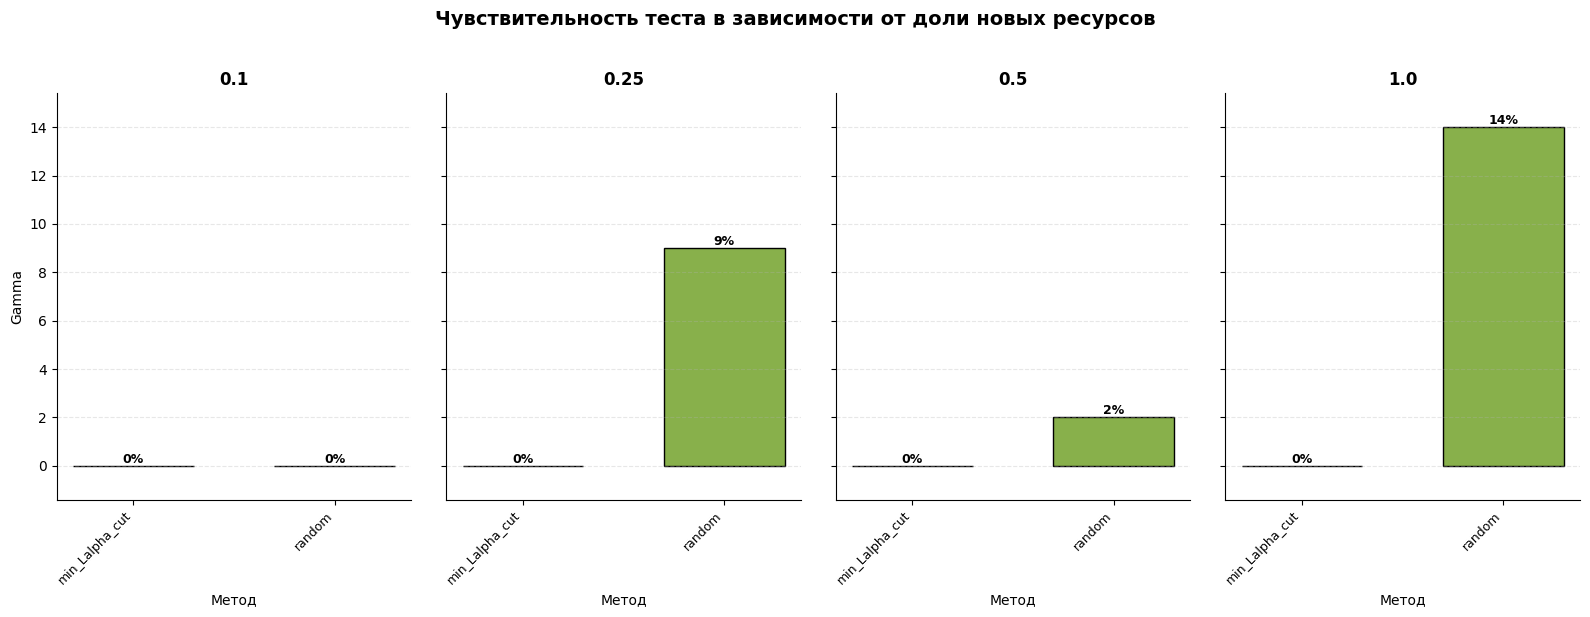

Чувствительность теста на графе cola_t3


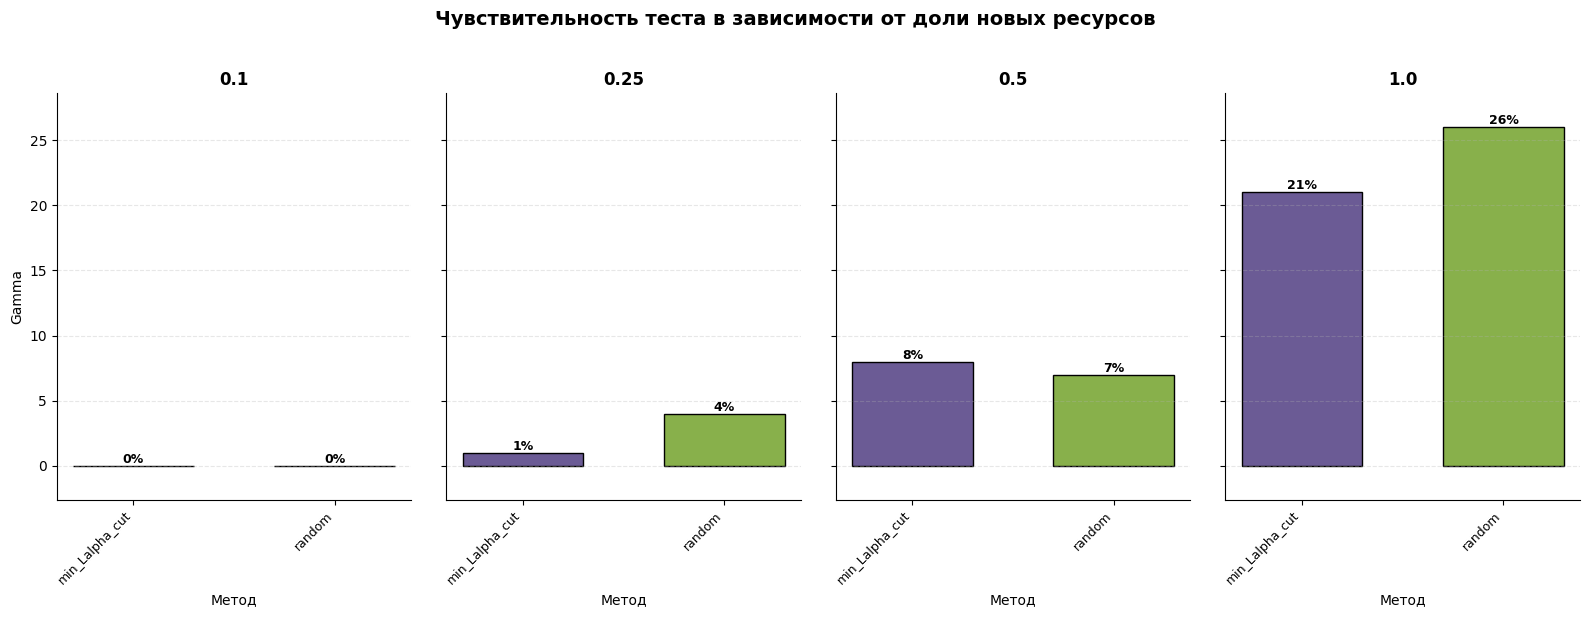

Чувствительность теста на графе cola_t8


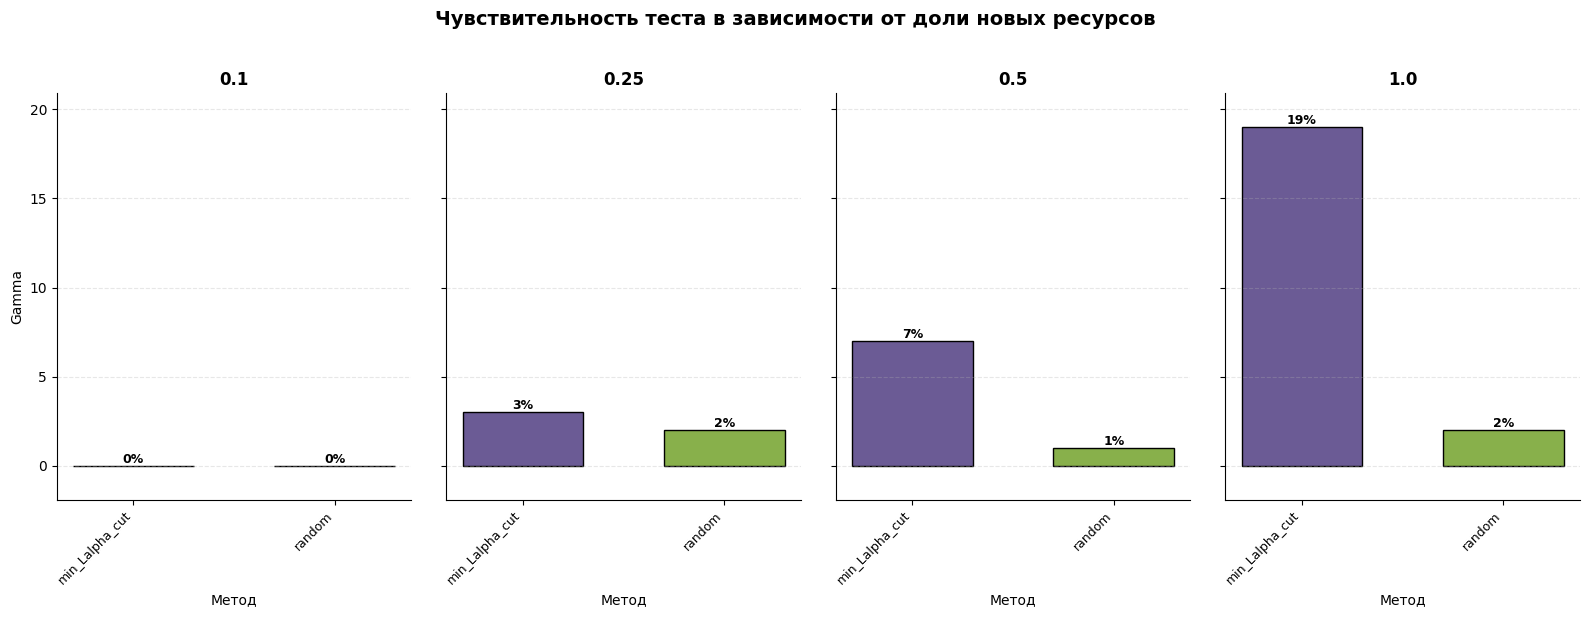

Чувствительность теста на графе cola_t2


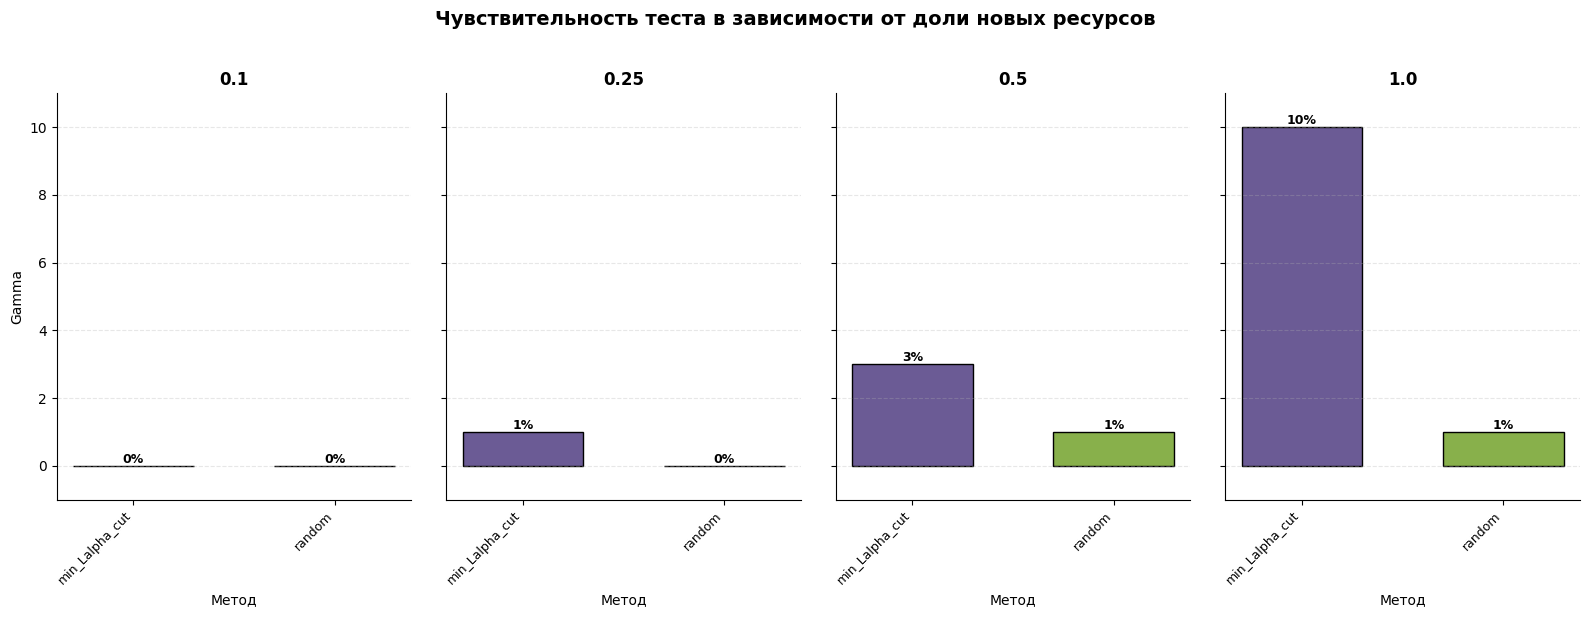

Общая сводка по графам


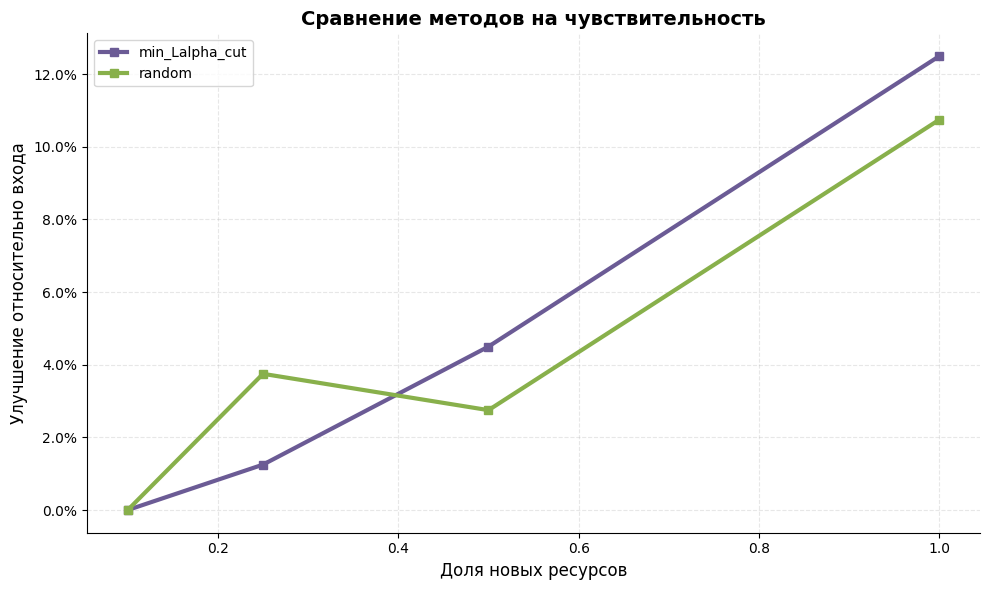

In [13]:
# маленькие кола графы
hu_graphs_names_resources_test = ['cola_t3', 'cola_t2', 'cola_t8', 'cola_t10']
hu_graphs_resources_test = get_hu_graphs(path_to_folder, hu_graphs_names_resources_test, True)

# тест
resources_test(hu_graphs_resources_test)

Смотрим на тех же Ху графах, но с генерацией своего трафика

Gravity - слабая загруженность

Чувствительность теста на графе cola_t3_gravity_0.3


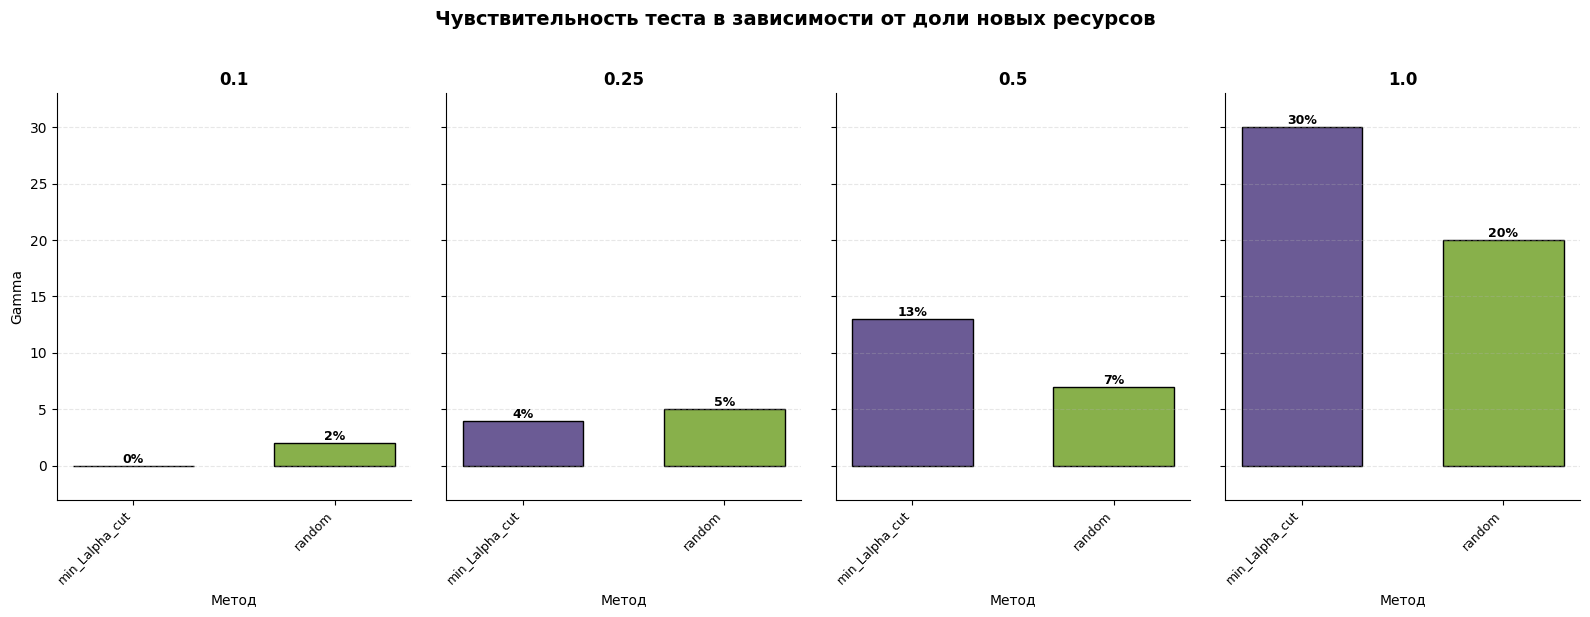

Чувствительность теста на графе cola_t2_gravity_0.3


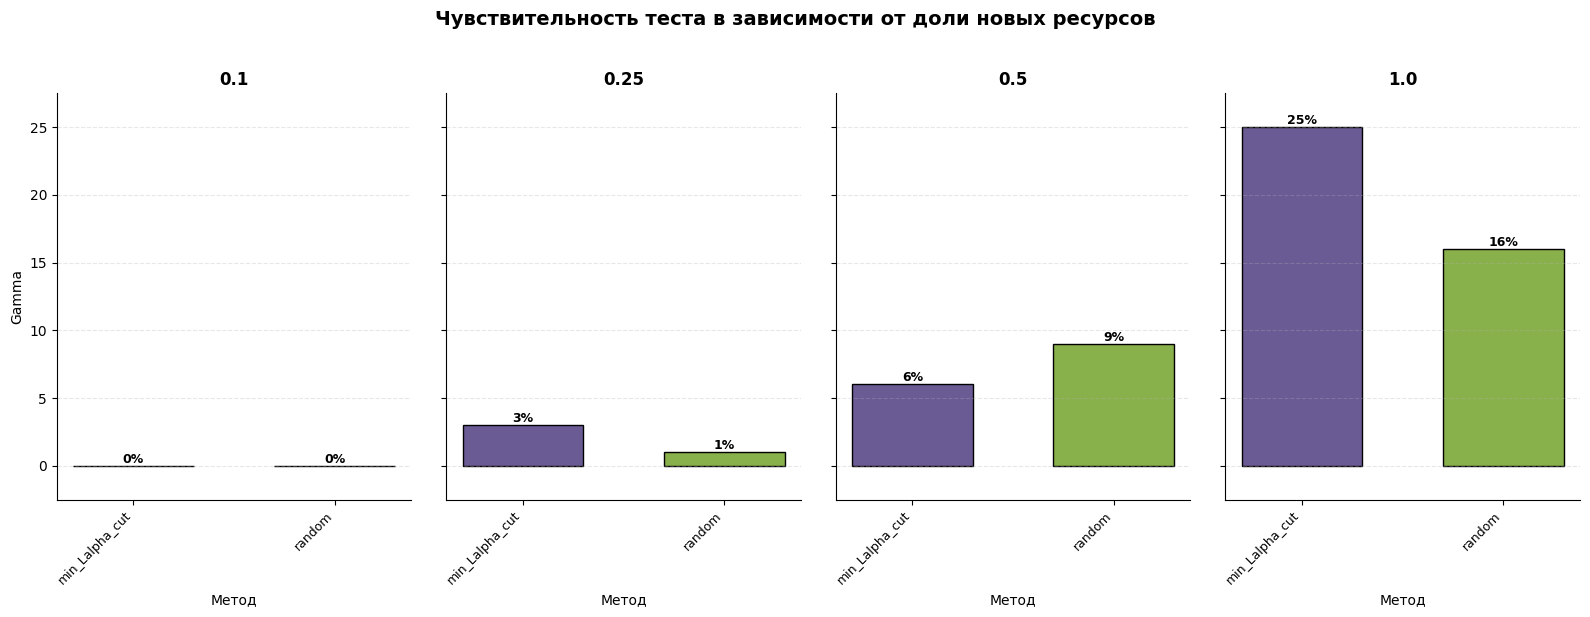

Чувствительность теста на графе cola_t8_gravity_0.3


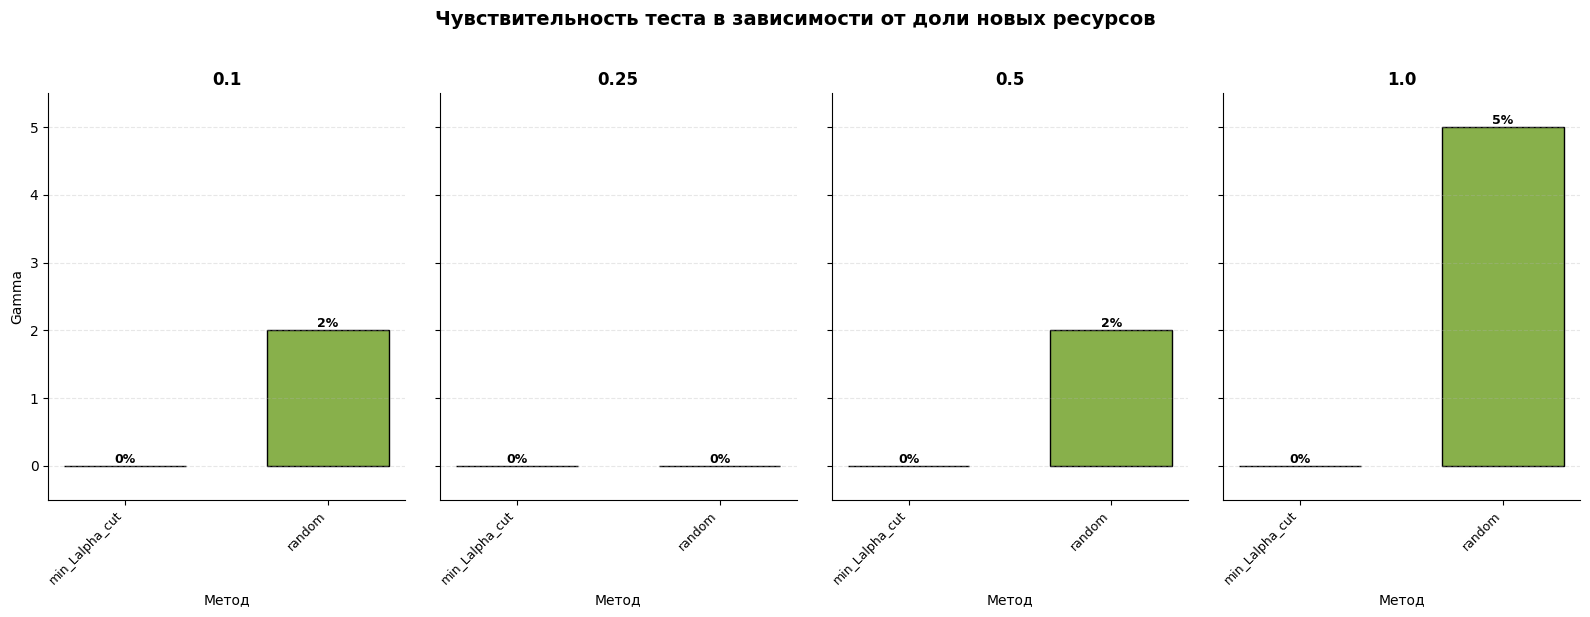

Чувствительность теста на графе cola_t10_gravity_0.3


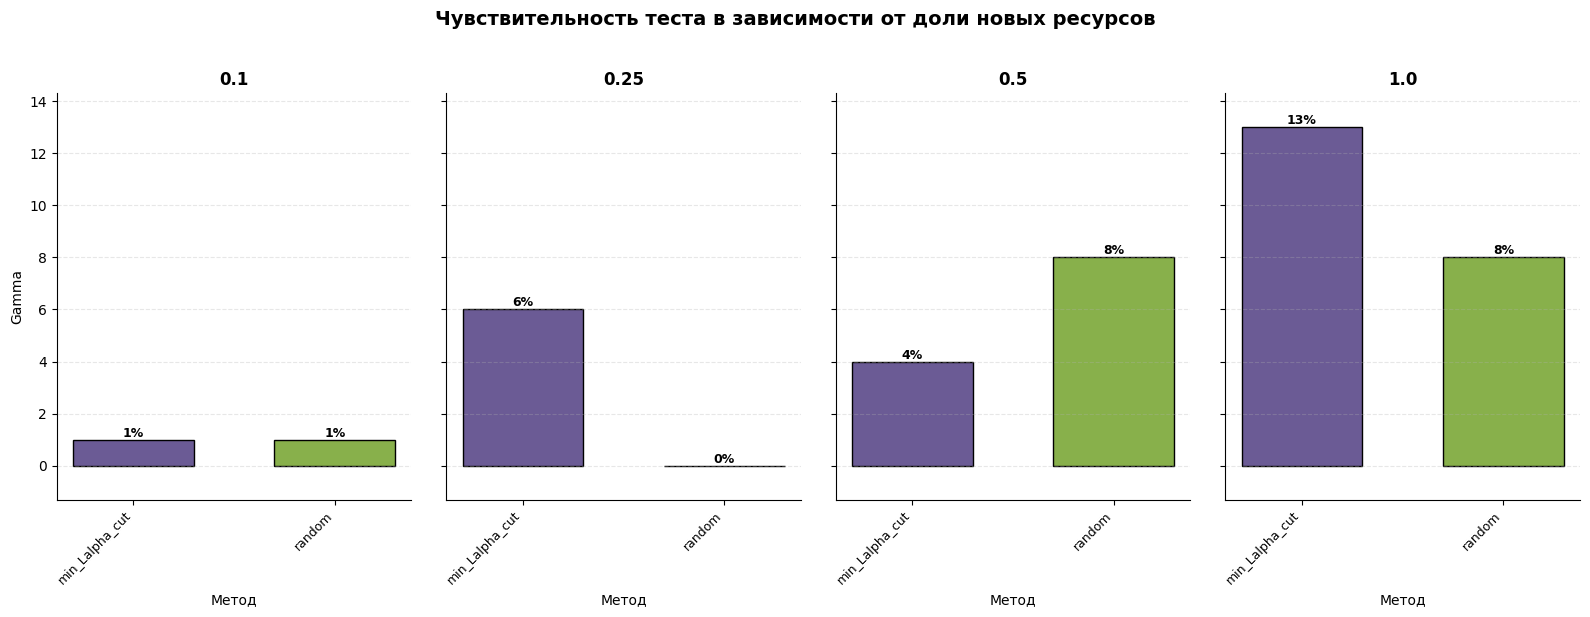

Общая сводка по графам


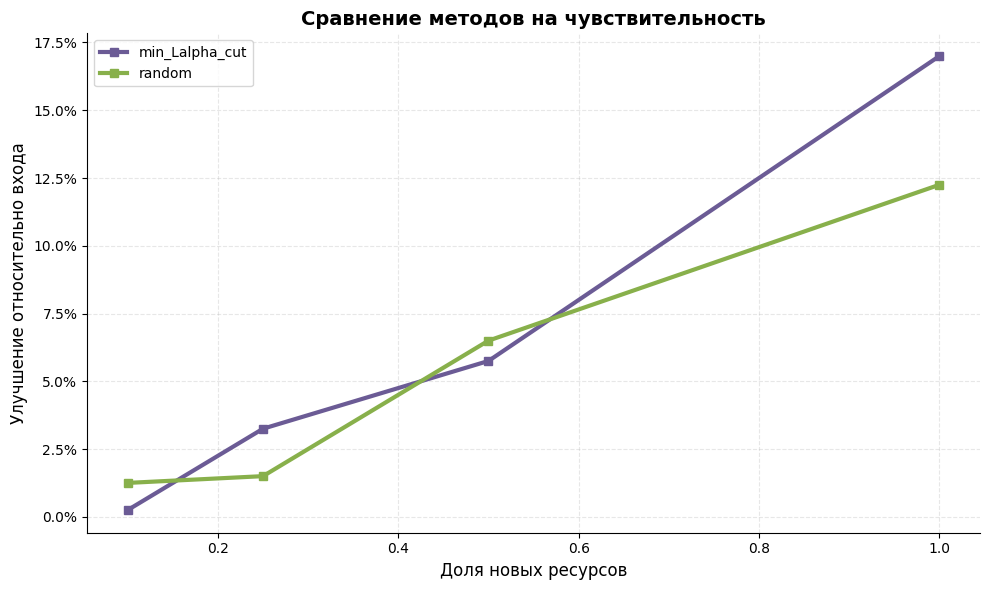

In [14]:
hu_graphs_w_generated_gravity_low_resources_test = get_hu_graphs_w_generated('gravity', [('cola_t3', 0.3), ('cola_t2', 0.3), ('cola_t8', 0.3), ('cola_t10', 0.3)])

# тест
resources_test(hu_graphs_w_generated_gravity_low_resources_test)

Gracity - высокая загруженность

Чувствительность теста на графе cola_t3_gravity_0.7


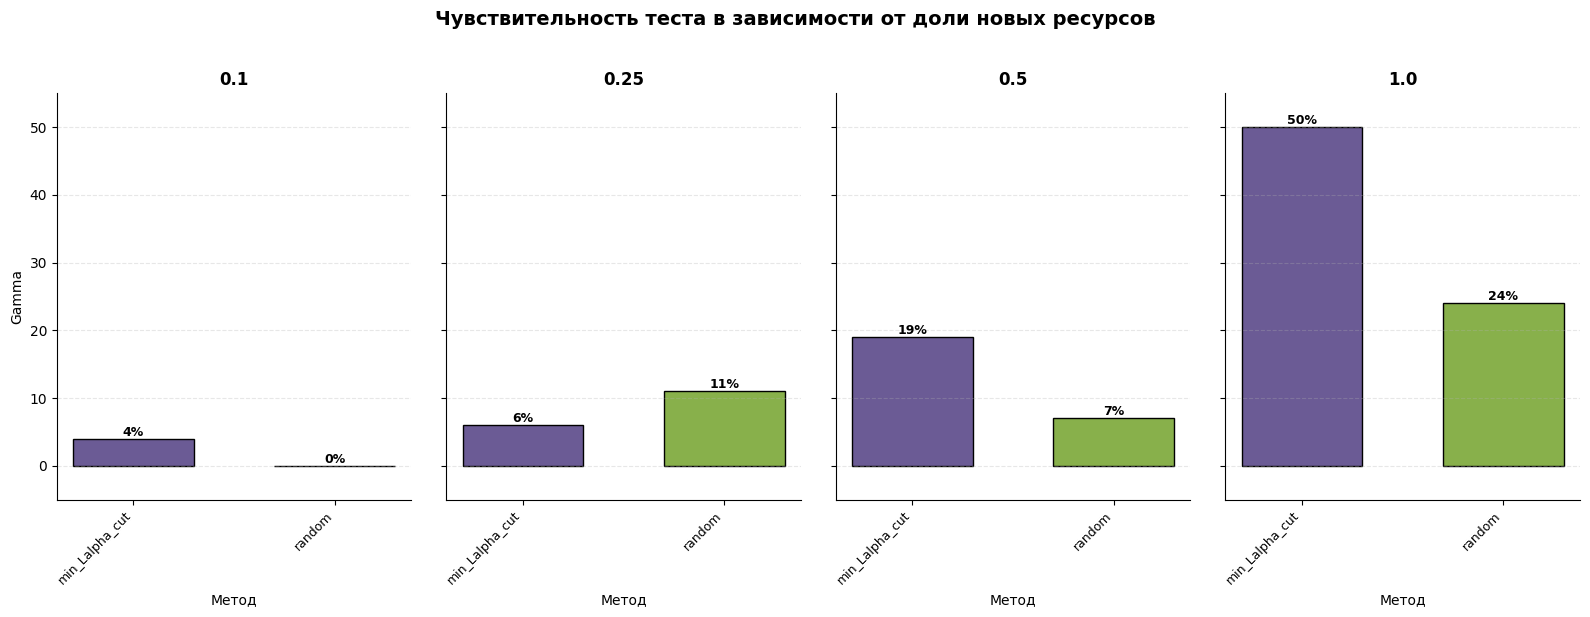

Чувствительность теста на графе cola_t2_gravity_0.7


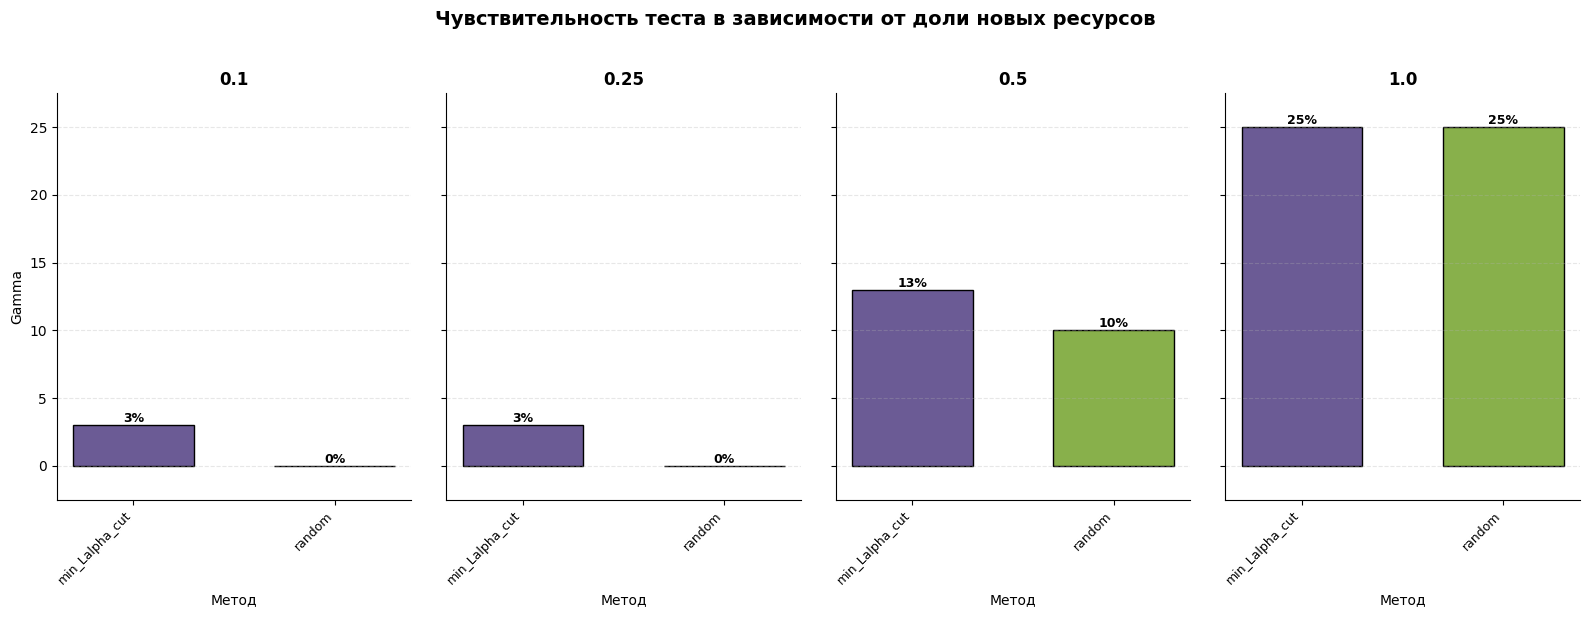

Чувствительность теста на графе cola_t8_gravity_0.7


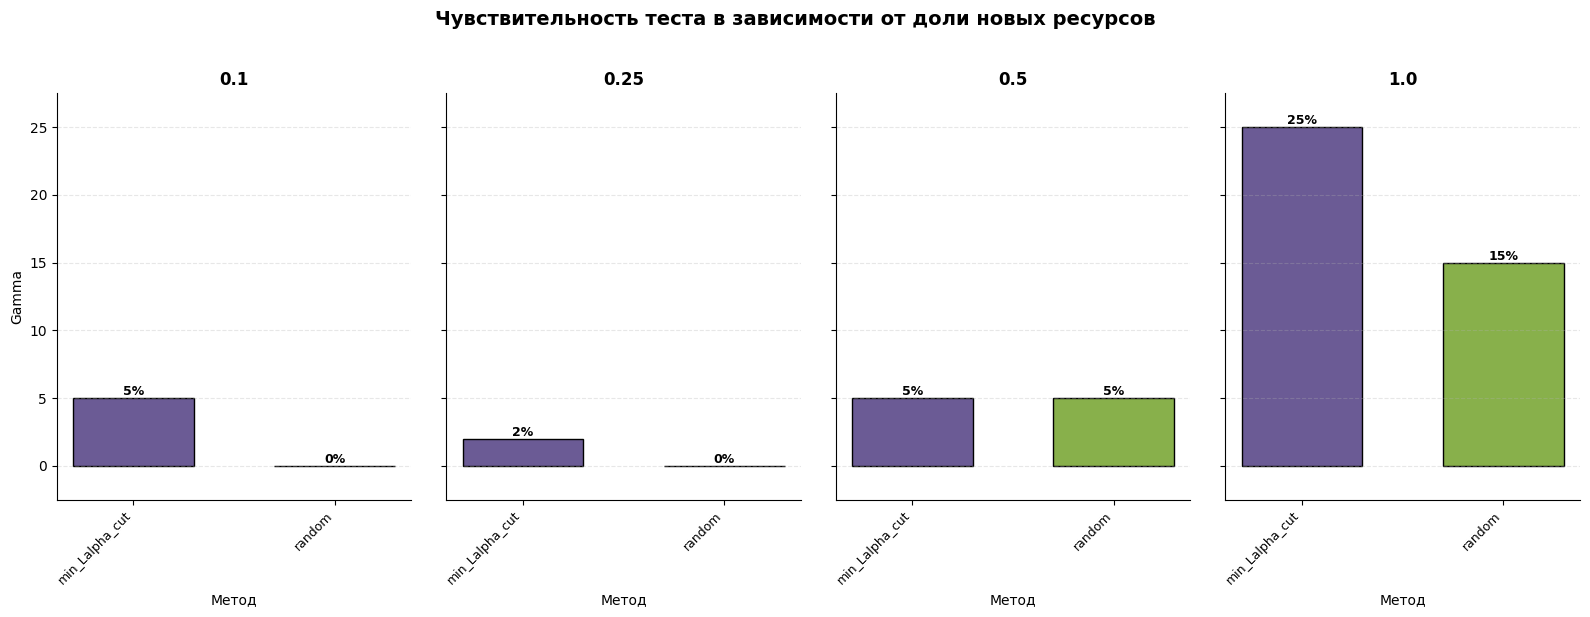

Чувствительность теста на графе cola_t10_gravity_0.7


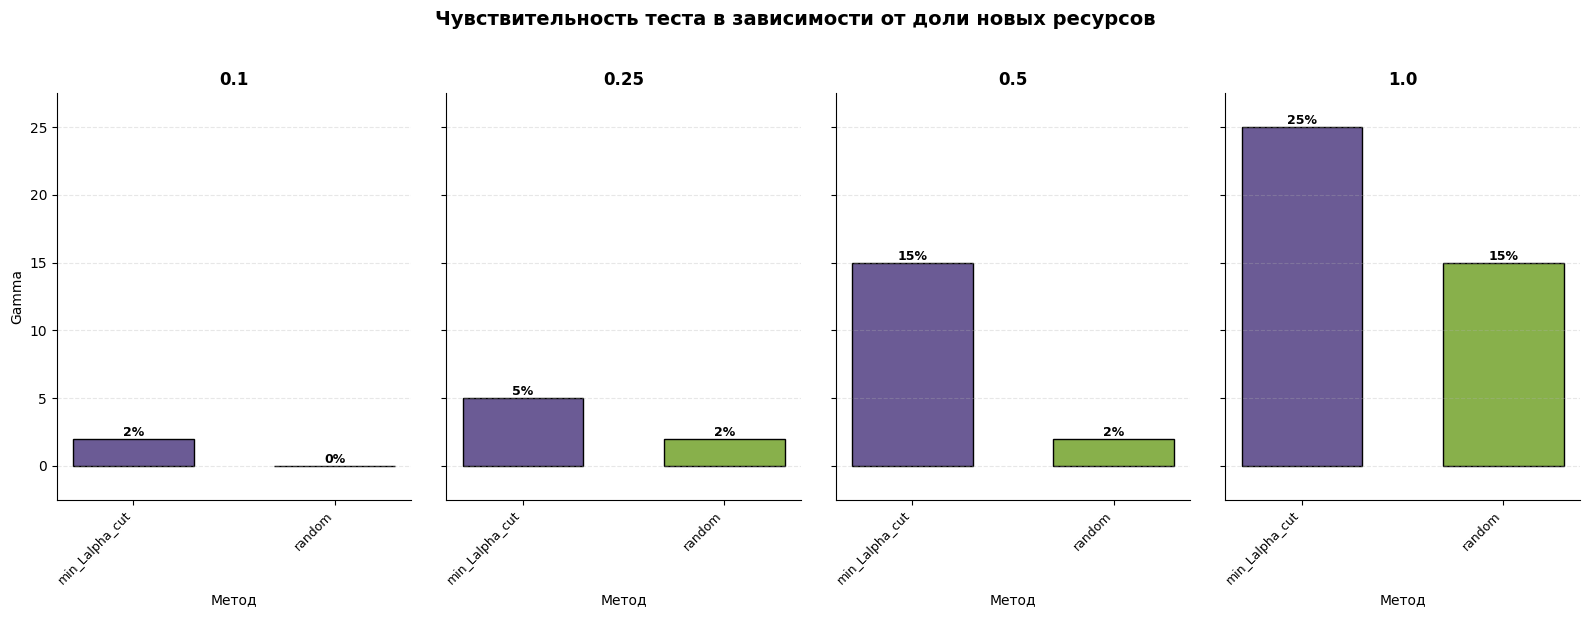

Общая сводка по графам


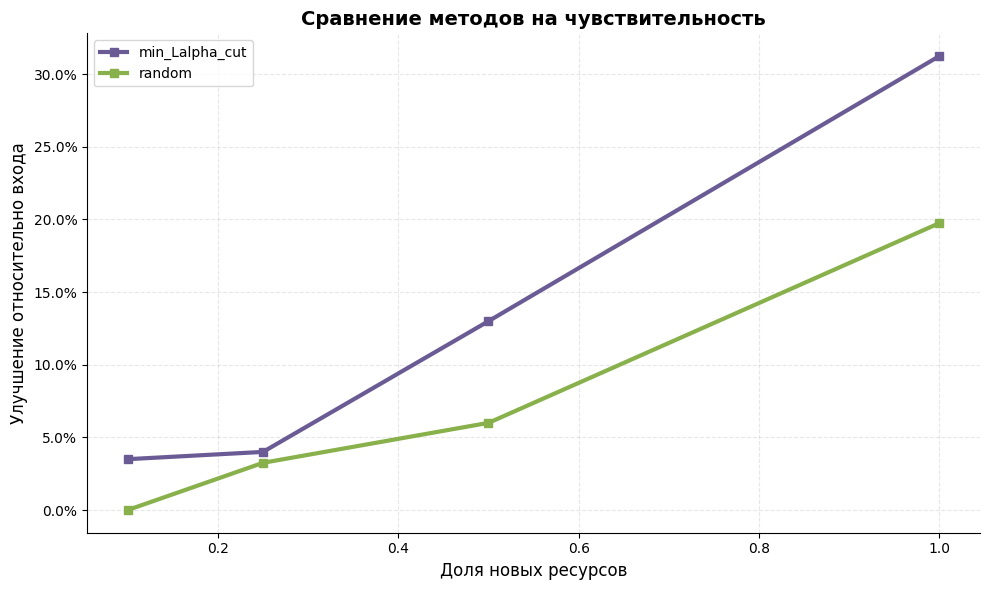

In [15]:
hu_graphs_w_generated_gravity_high_resources_test = get_hu_graphs_w_generated('gravity', [('cola_t3', 0.7), ('cola_t2', 0.7), ('cola_t8', 0.7), ('cola_t10', 0.7)])

# тест
resources_test(hu_graphs_w_generated_gravity_high_resources_test)

Miltialpha - слабая загруженность

Чувствительность теста на графе cola_t3_alpha_0.3


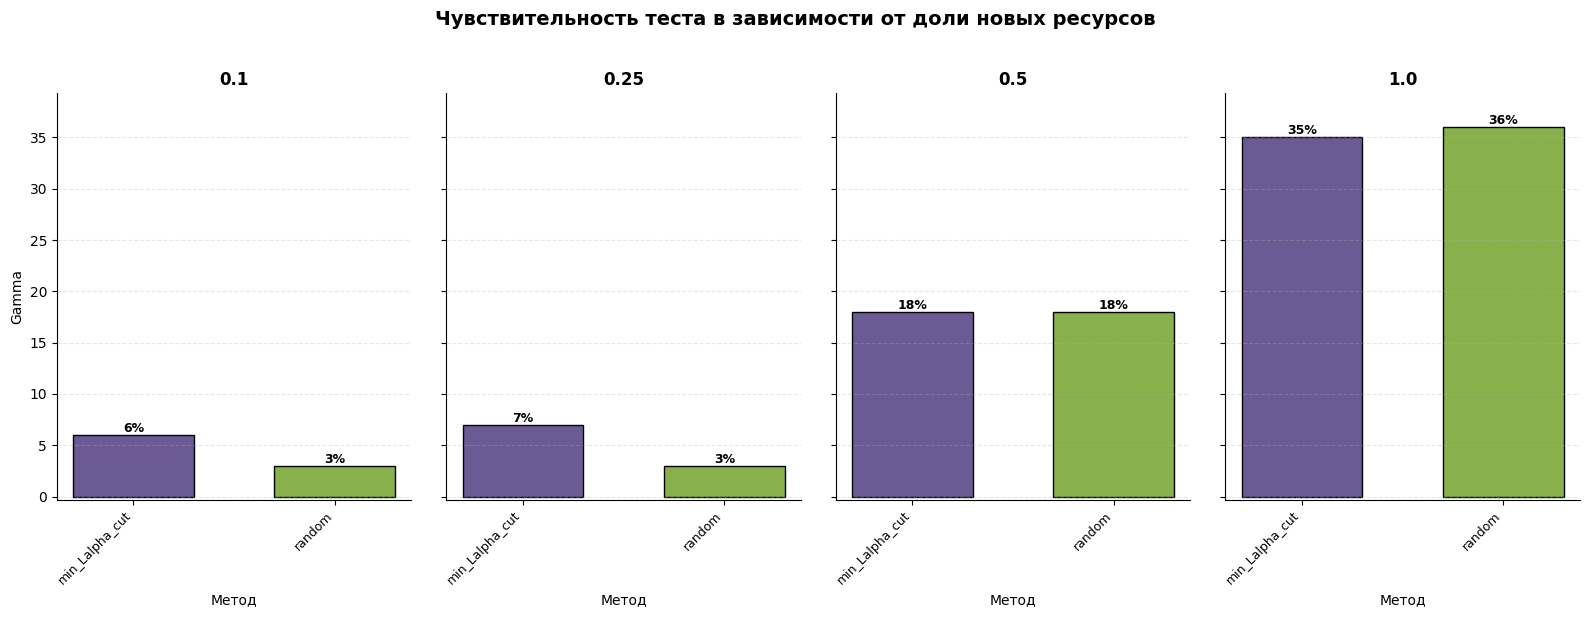

Чувствительность теста на графе cola_t2_alpha_0.3


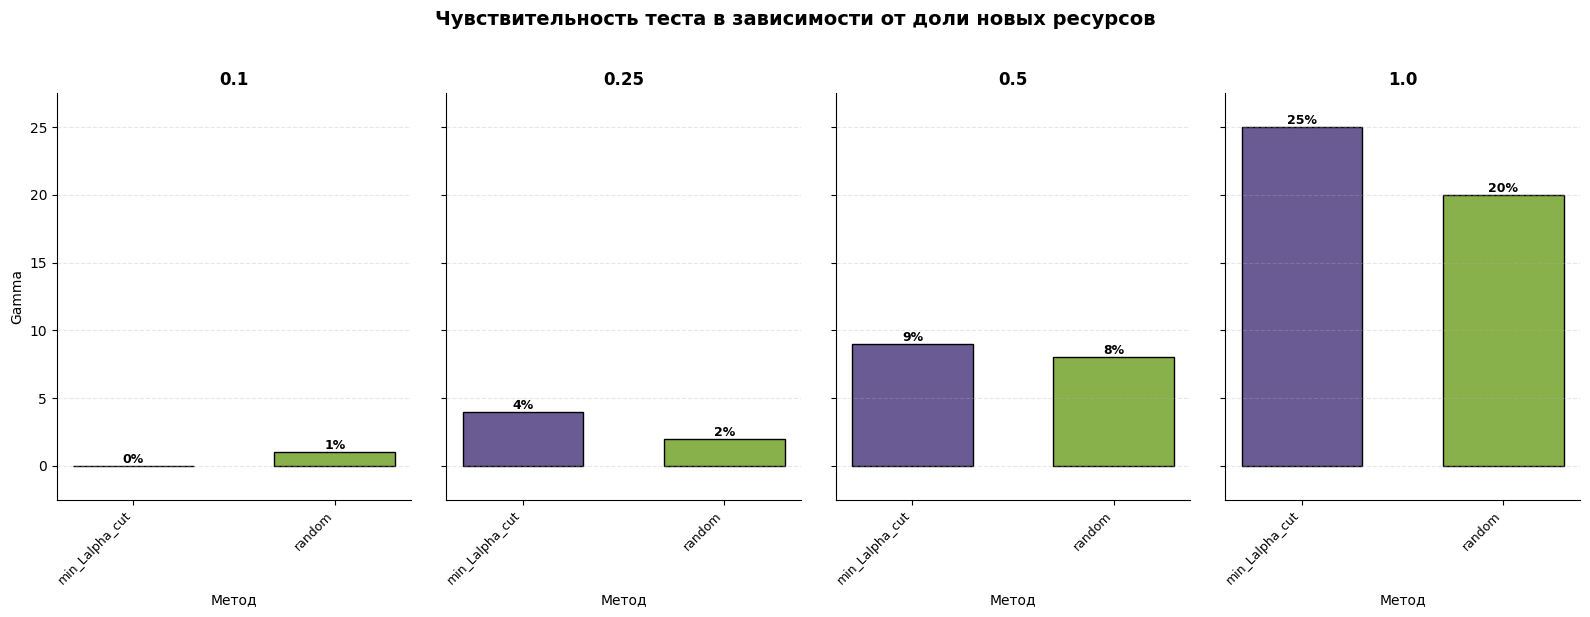

Чувствительность теста на графе cola_t8_alpha_0.3


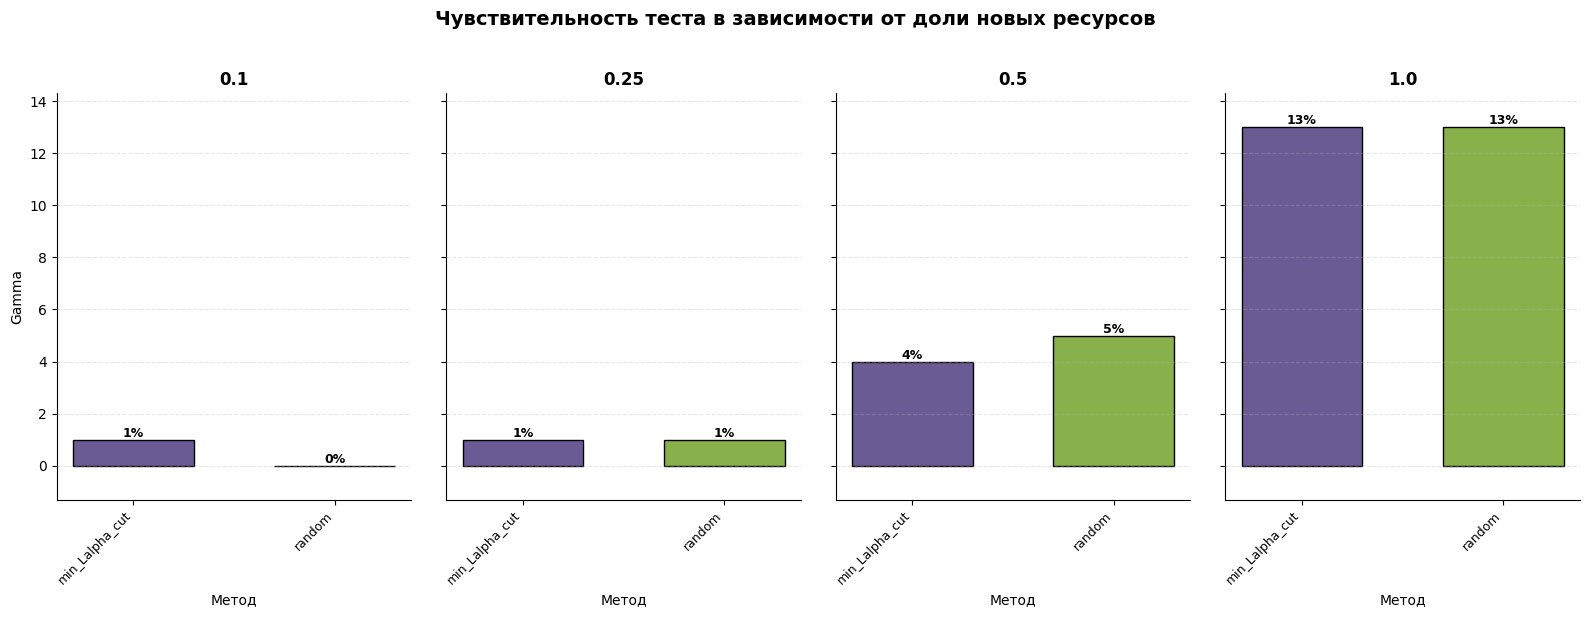

Чувствительность теста на графе cola_t10_alpha_0.3


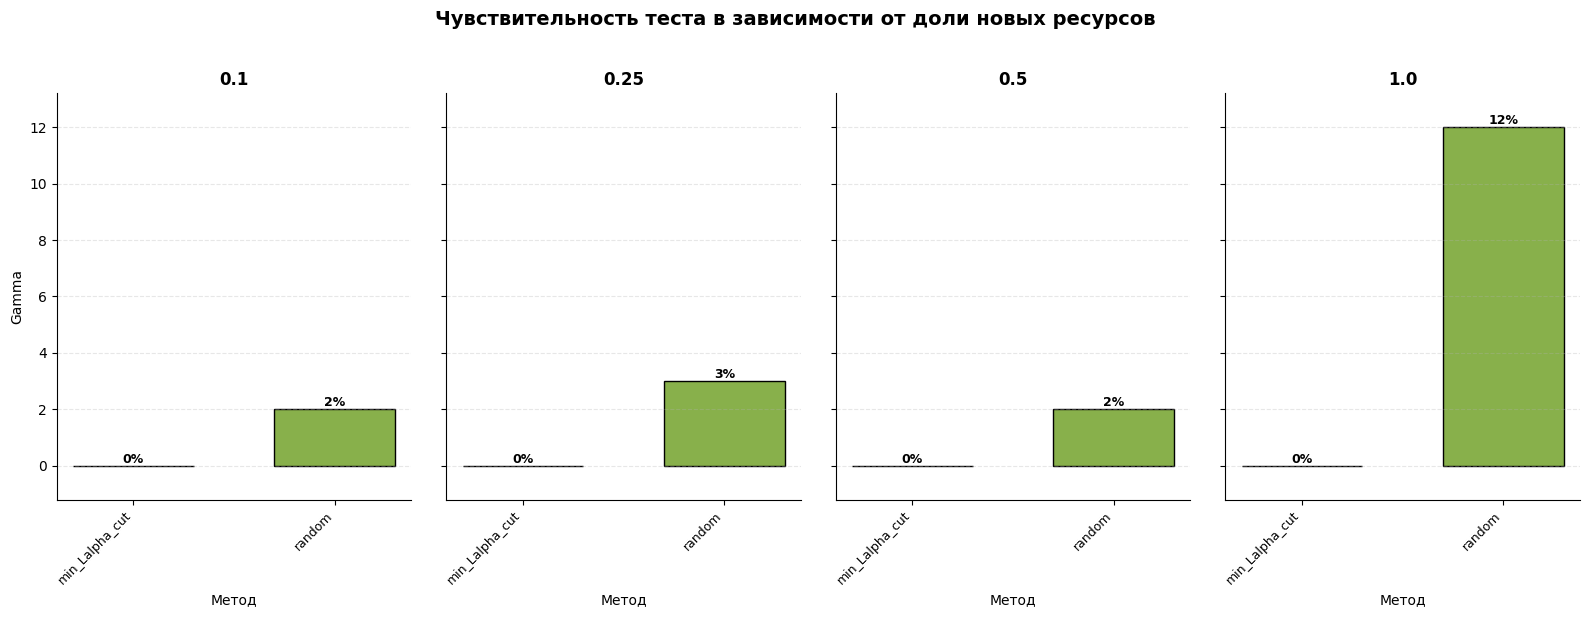

Общая сводка по графам


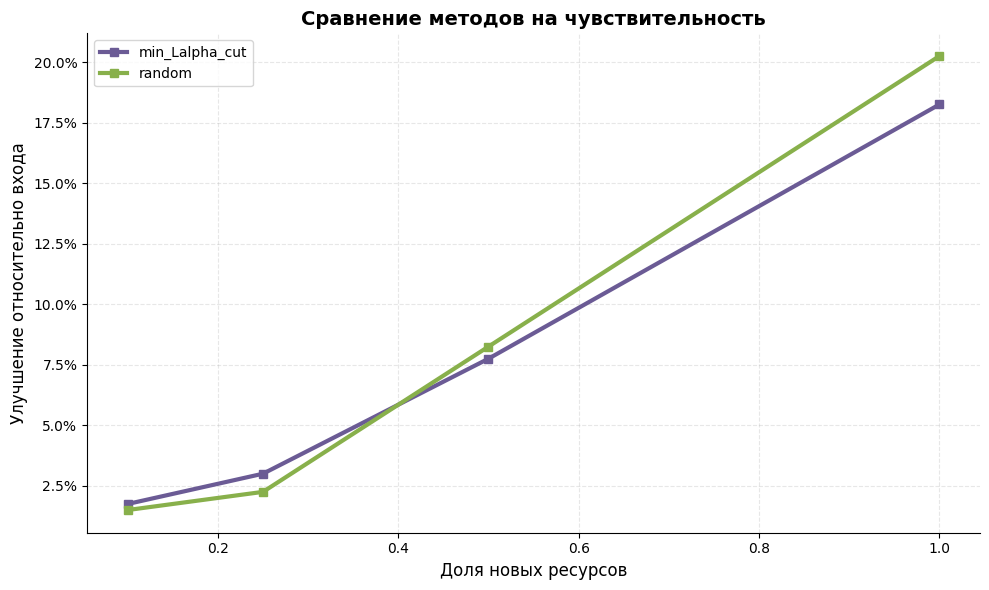

In [17]:
hu_graphs_w_generated_multialpha_low_resources_test = get_hu_graphs_w_generated('alpha', [('cola_t3', 0.3), ('cola_t2', 0.3), ('cola_t8', 0.3), ('cola_t10', 0.3)])

# тест
resources_test(hu_graphs_w_generated_multialpha_low_resources_test)

Multialpha - высокая загруженность

Чувствительность теста на графе cola_t3_alpha_0.5


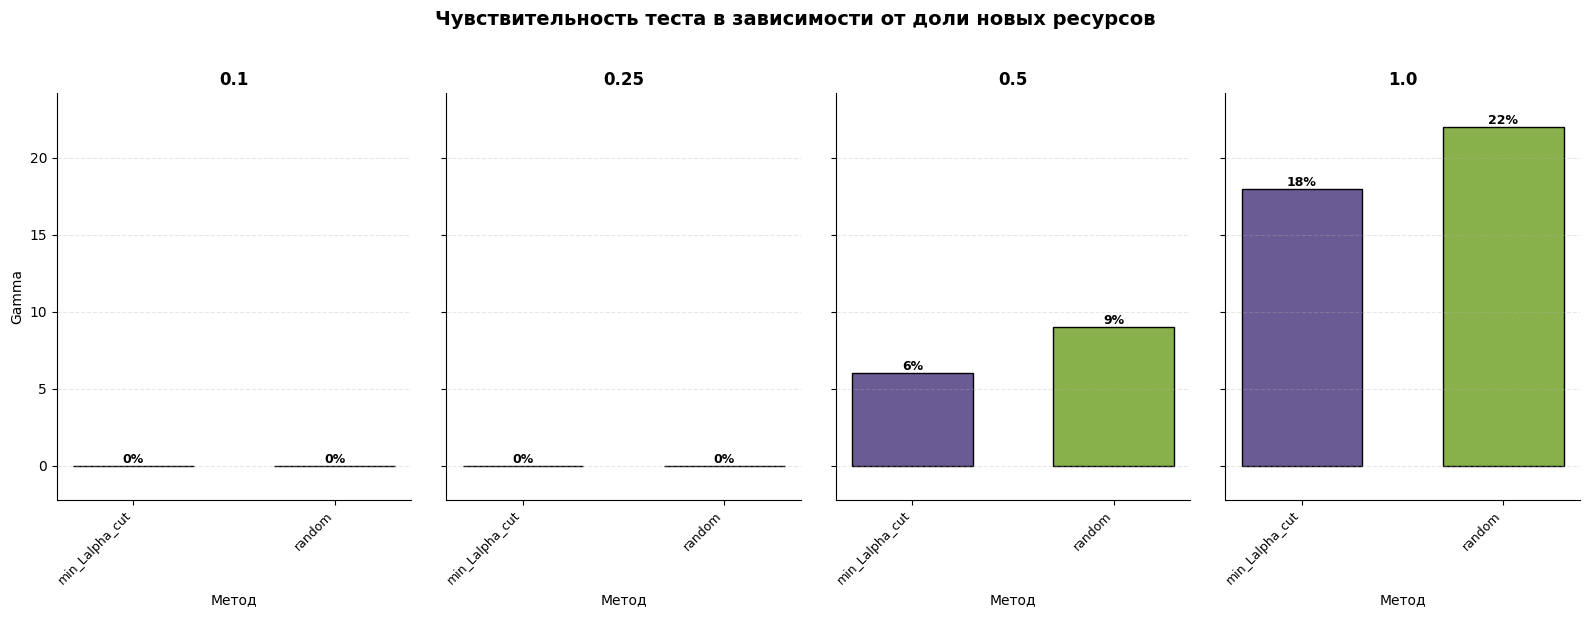

Чувствительность теста на графе cola_t2_alpha_0.5


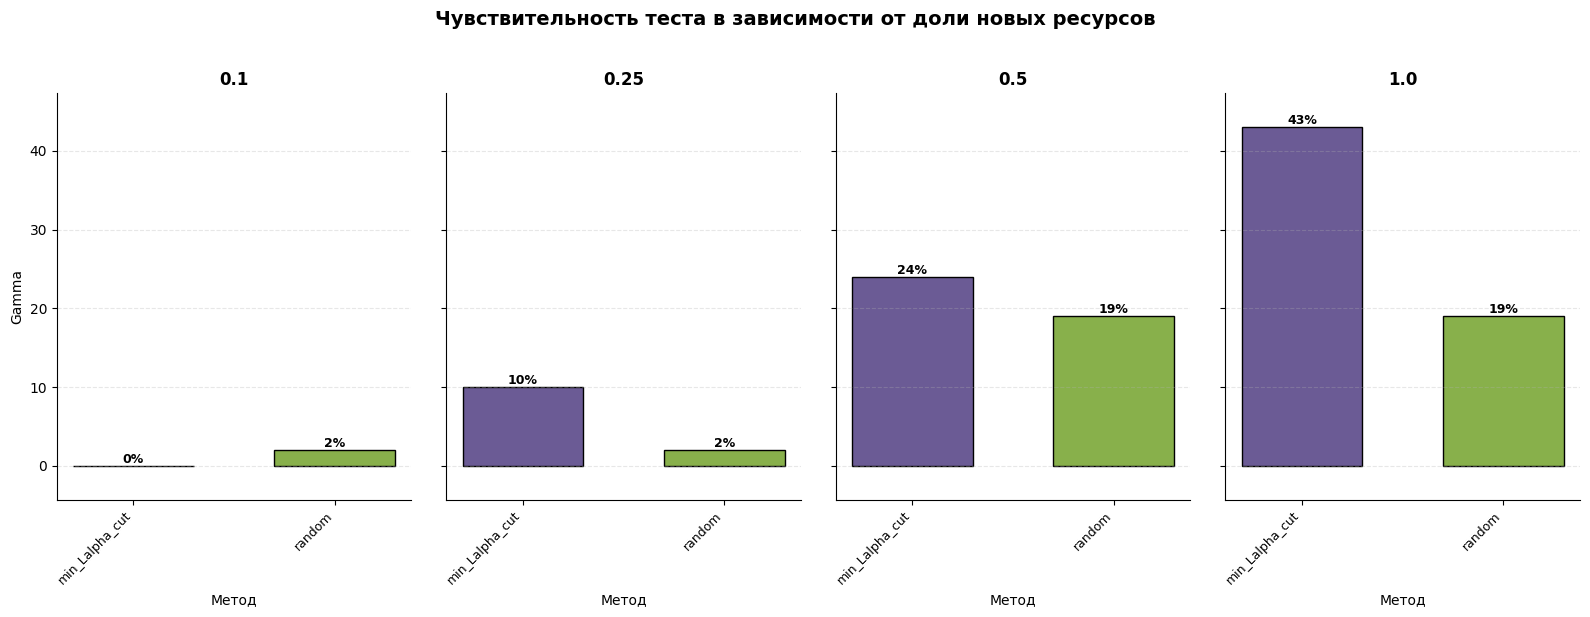

Чувствительность теста на графе cola_t8_alpha_0.45


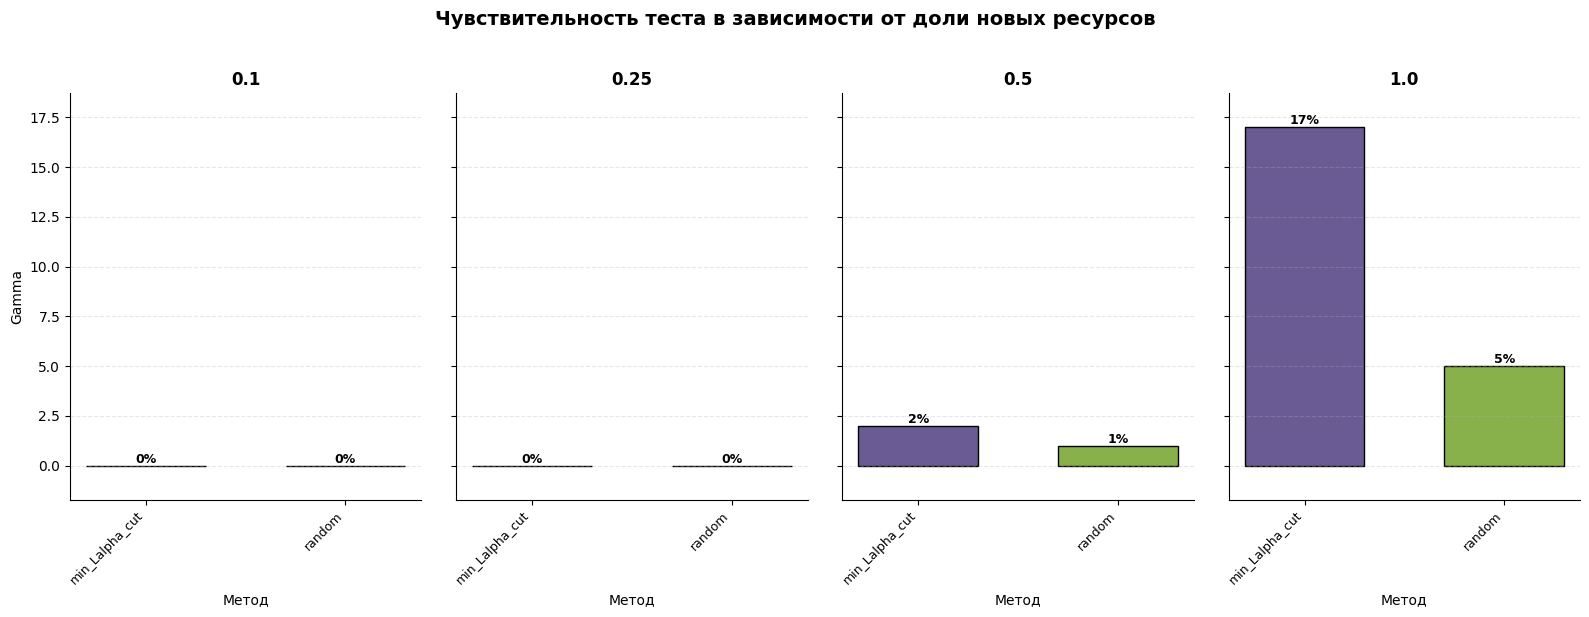

Чувствительность теста на графе cola_t10_alpha_0.45


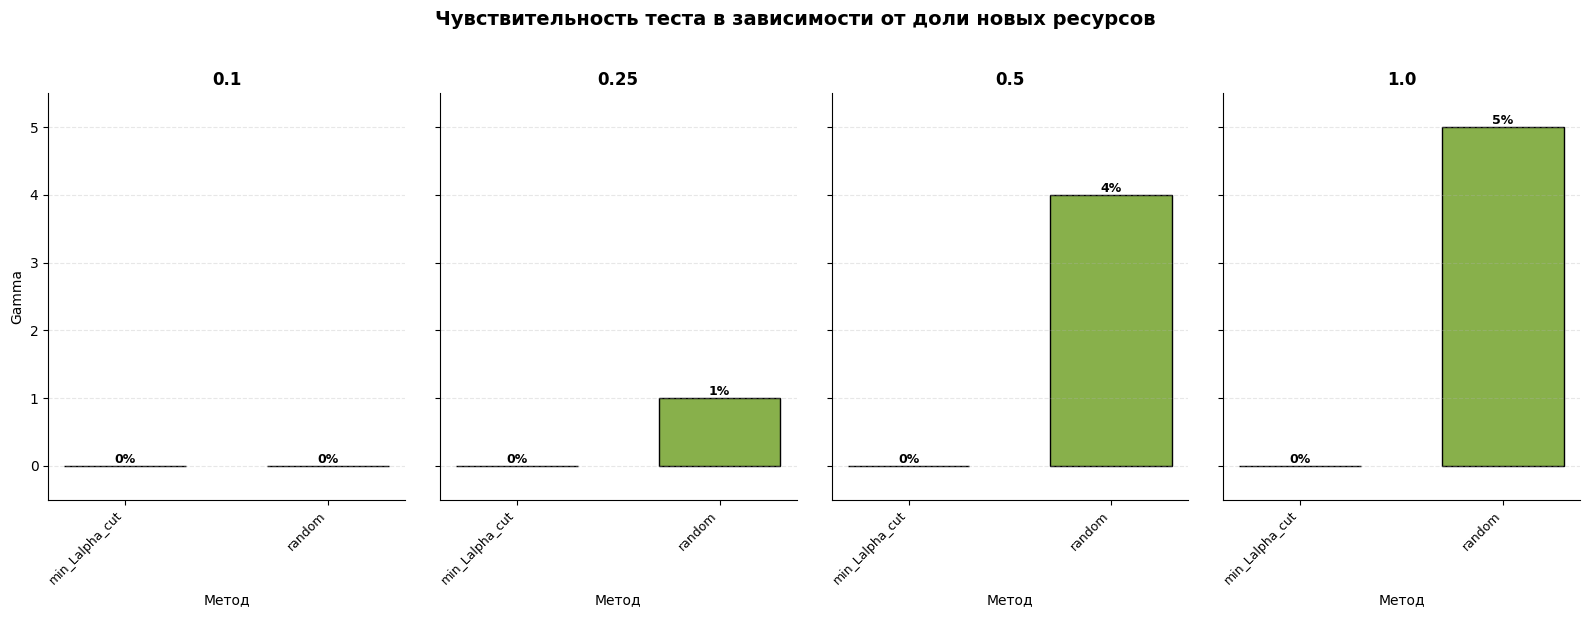

Общая сводка по графам


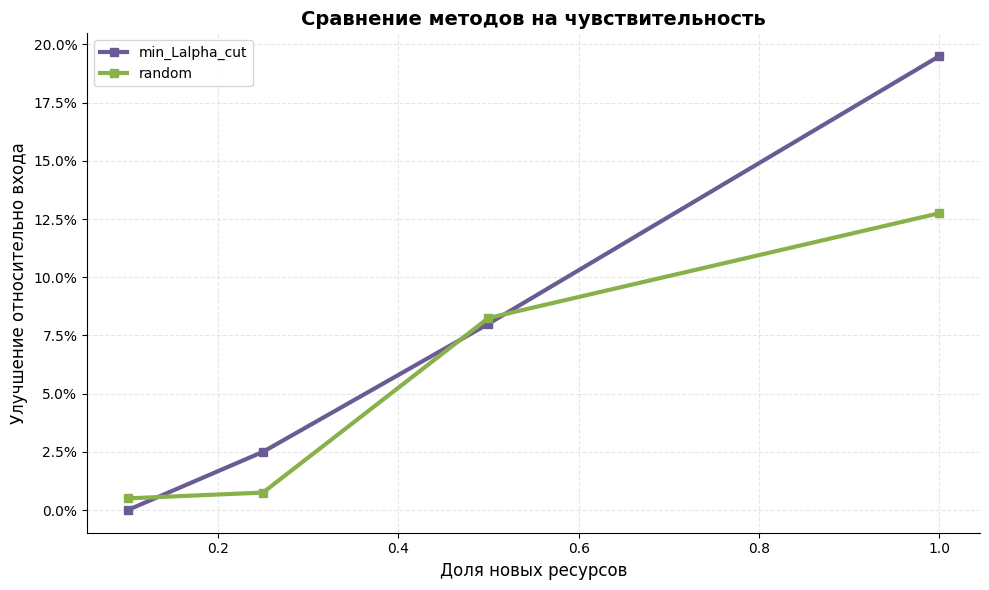

In [18]:
hu_graphs_w_generated_multialpha_high_resources_test = get_hu_graphs_w_generated('alpha', [('cola_t3', 0.5), ('cola_t2', 0.5), ('cola_t8', 0.45), ('cola_t10', 0.45)])

# тест
resources_test(hu_graphs_w_generated_multialpha_high_resources_test)

Смотрим на SNR BA

Gravity - слабая загруженность

Чувствительность теста на графе SNR-BA_30_gravity_0.3_#1


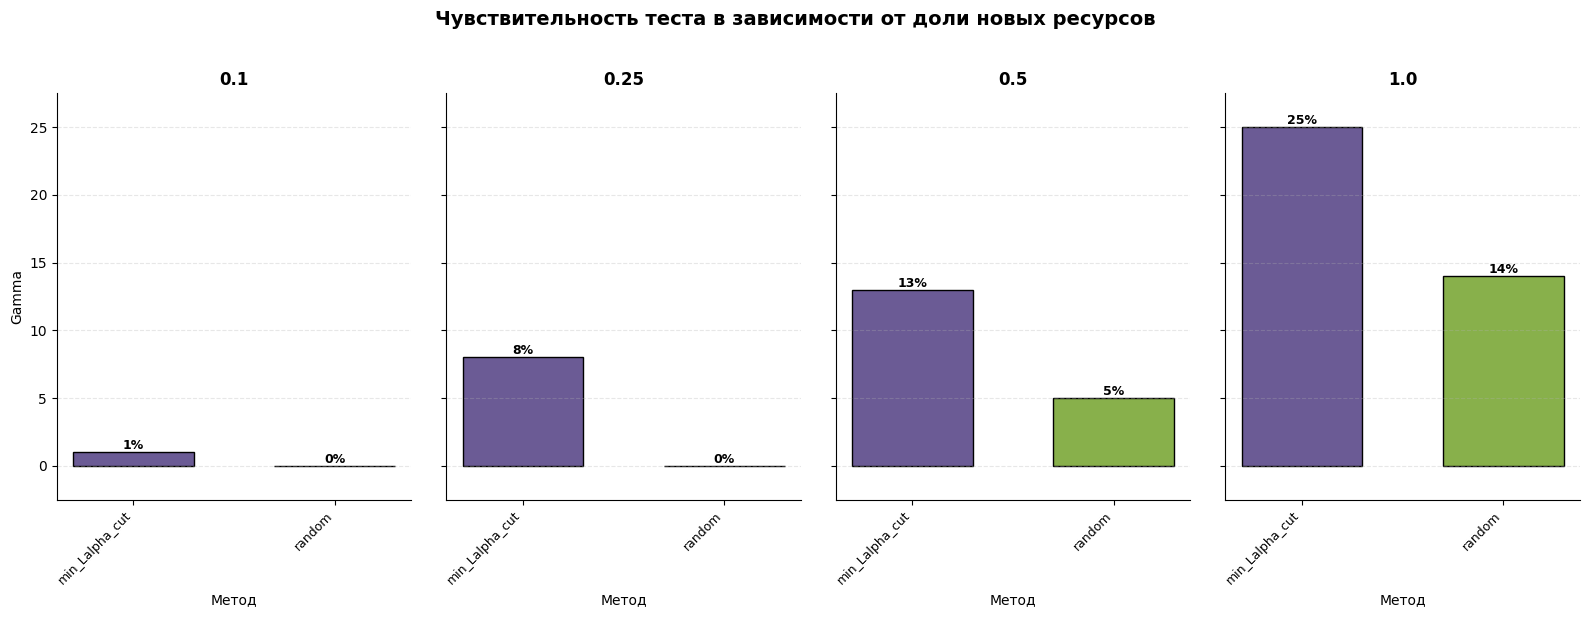

Чувствительность теста на графе SNR-BA_30_gravity_0.3_#2


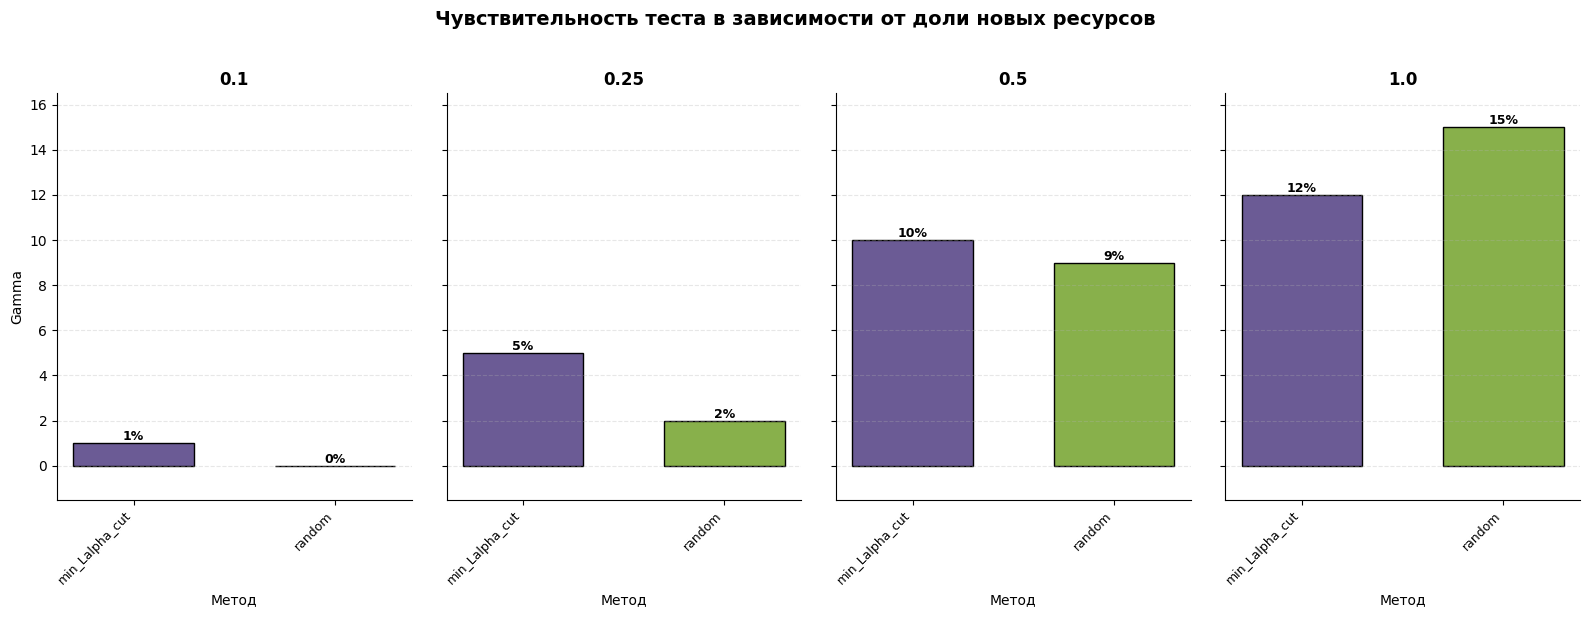

Чувствительность теста на графе SNR-BA_30_gravity_0.3_#3


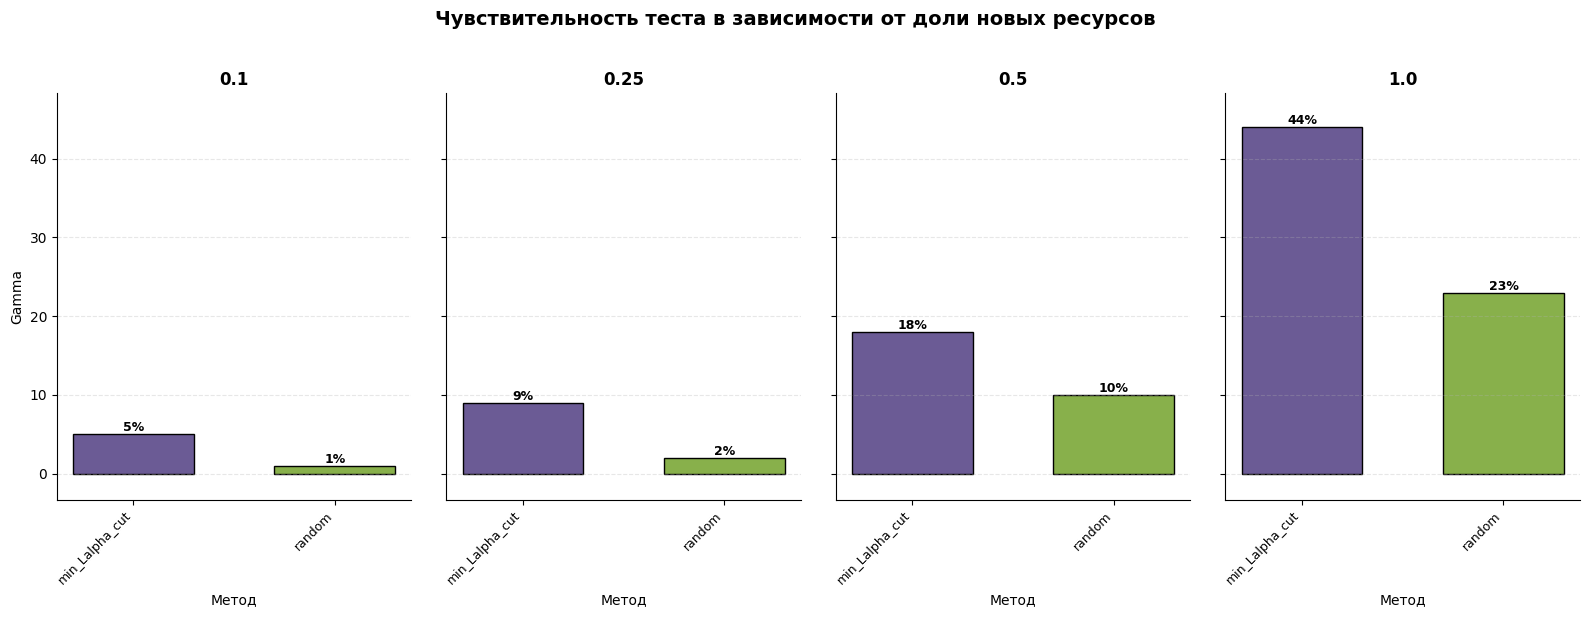

Чувствительность теста на графе SNR-BA_30_gravity_0.3_#4


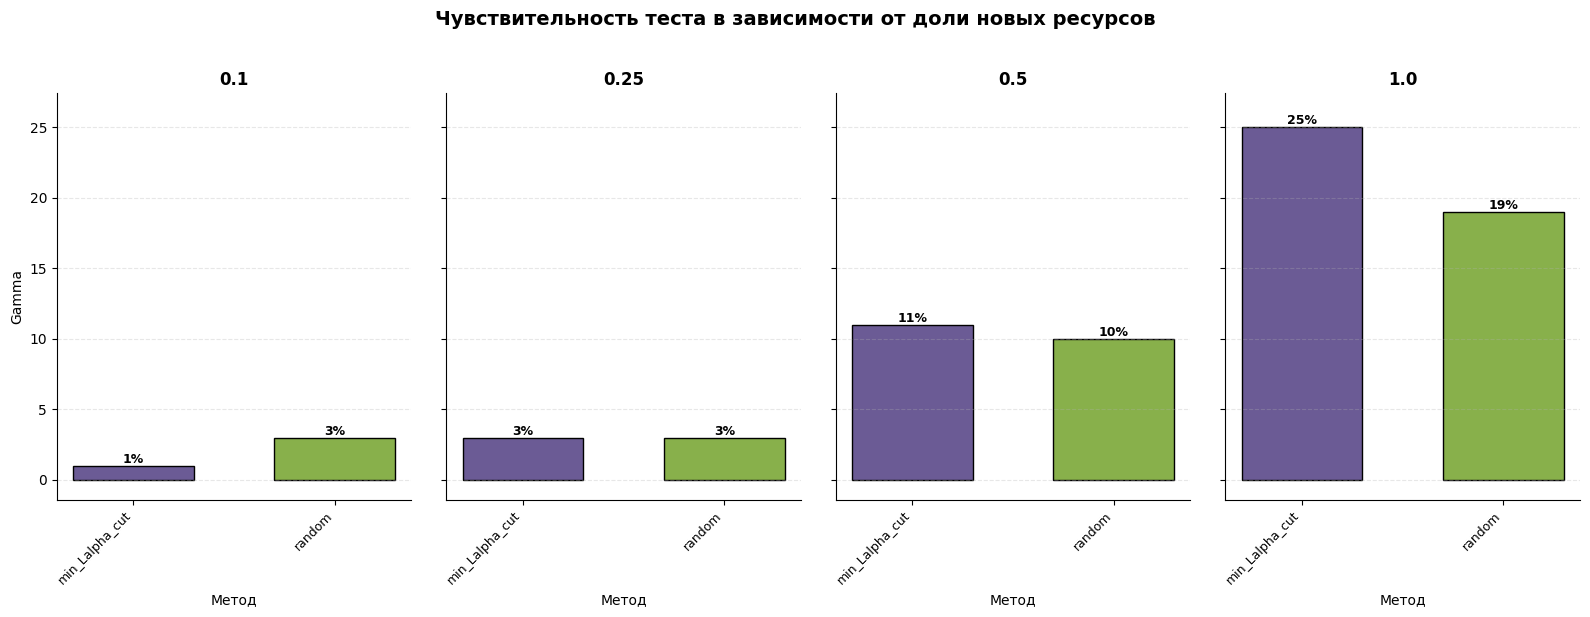

Общая сводка по графам


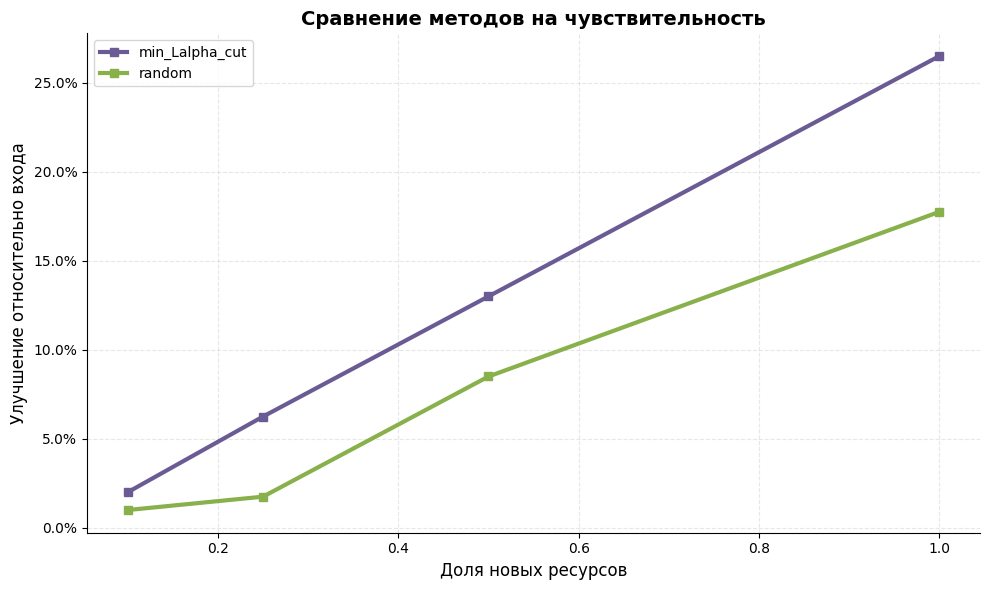

In [9]:
snr_ba_graphs_w_generated_gravity_low_resources_test = get_snr_ba_graphs_w_generated(4, 30, 80.0, 'gravity', [0.3, 0.3, 0.3, 0.3])

# тест
resources_test(snr_ba_graphs_w_generated_gravity_low_resources_test)

Gravity - высокая загруженность

Чувствительность теста на графе SNR-BA_30_gravity_0.7_#1


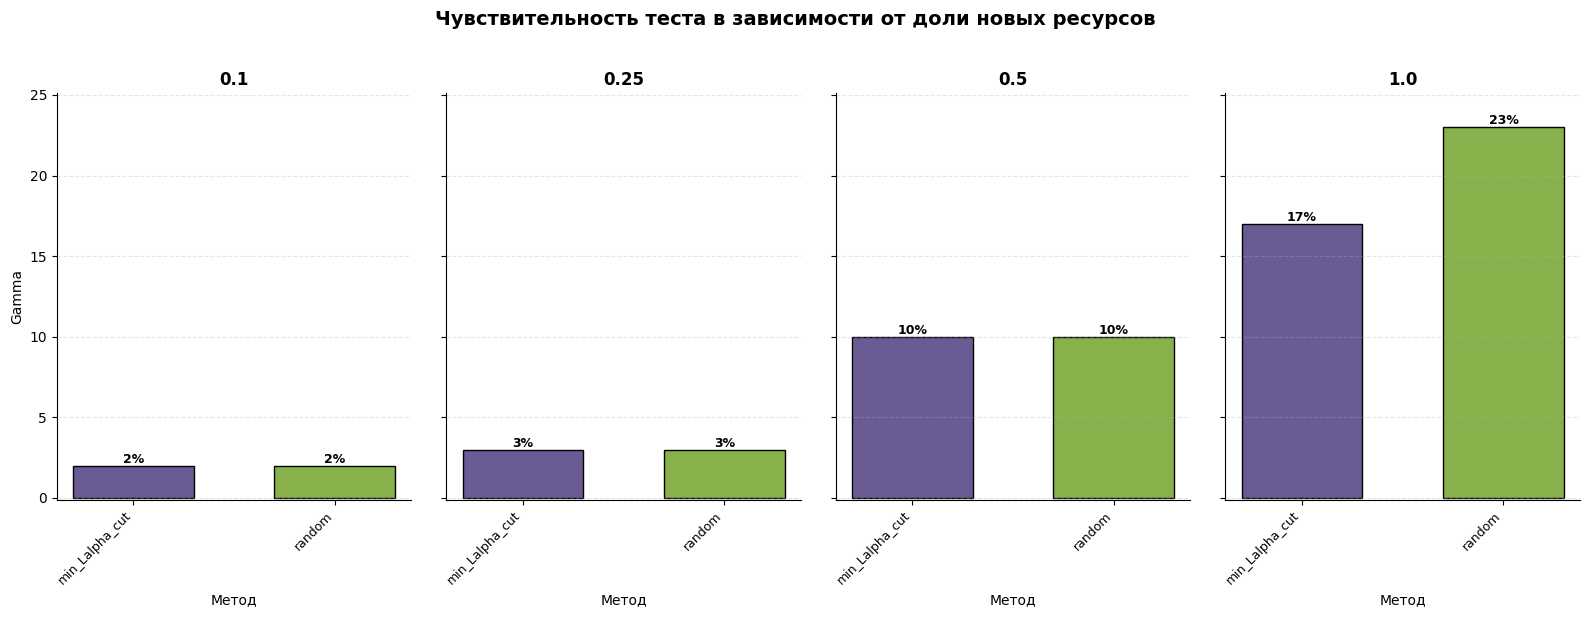

Чувствительность теста на графе SNR-BA_30_gravity_0.7_#2


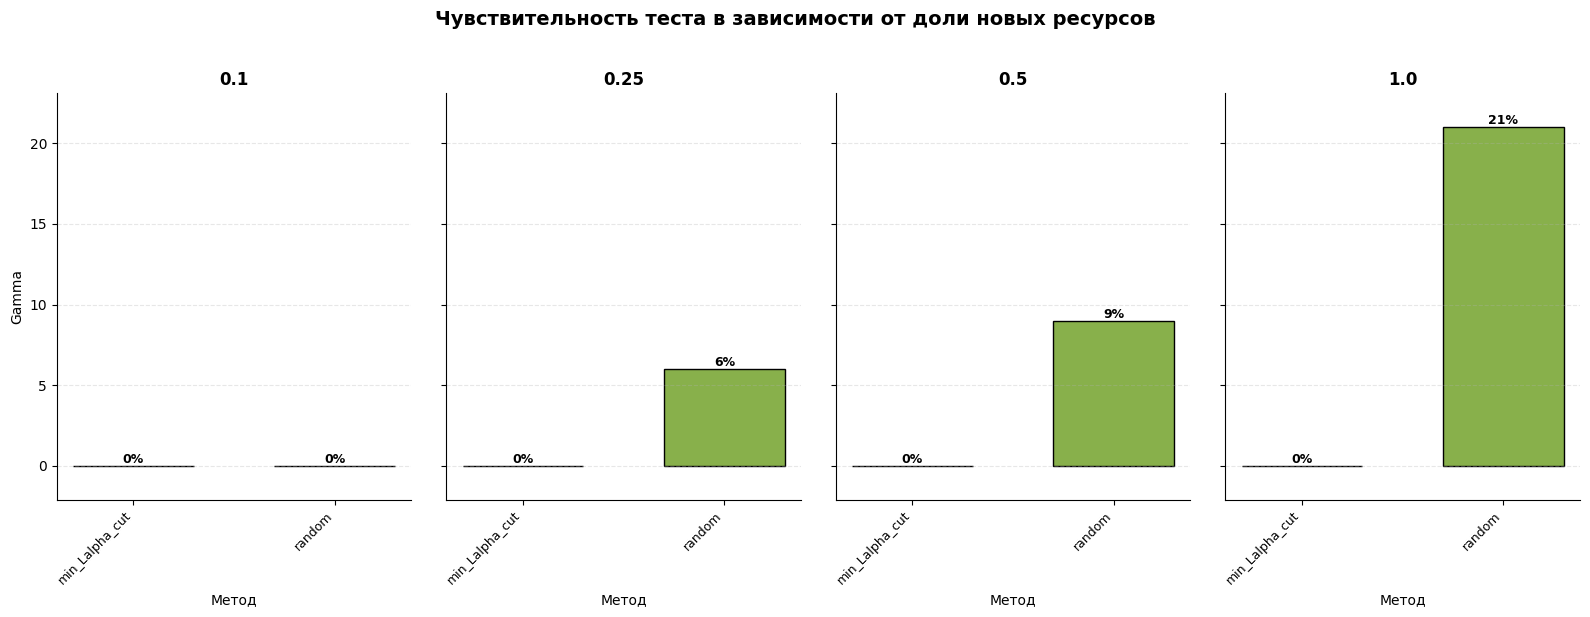

Чувствительность теста на графе SNR-BA_30_gravity_0.7_#3


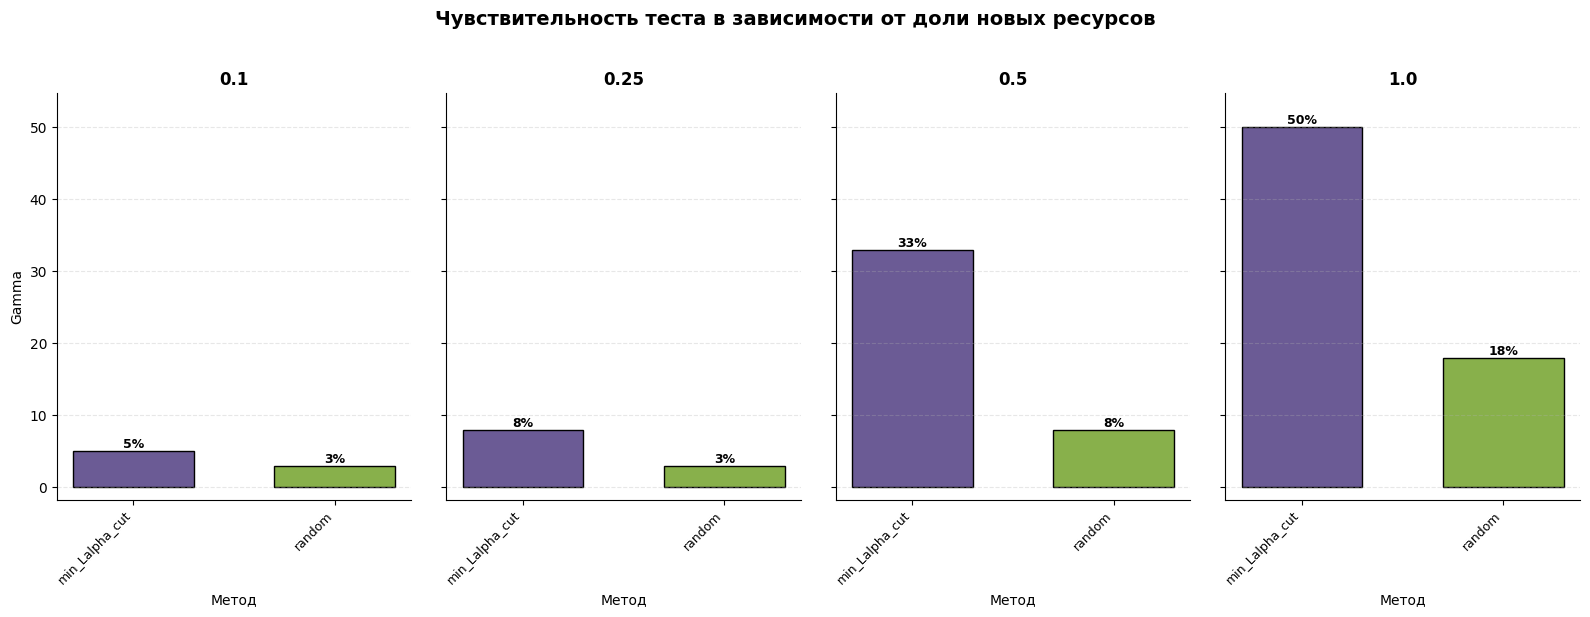

Чувствительность теста на графе SNR-BA_30_gravity_0.7_#4


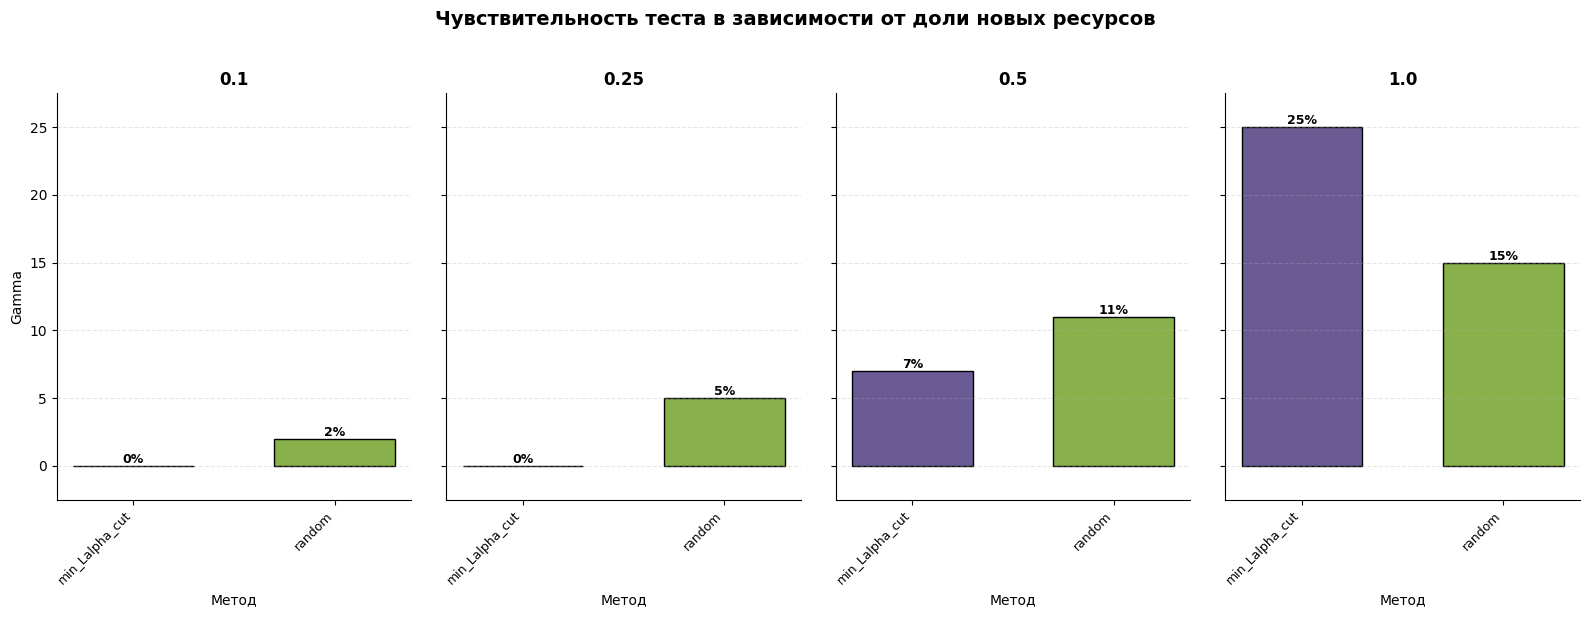

Общая сводка по графам


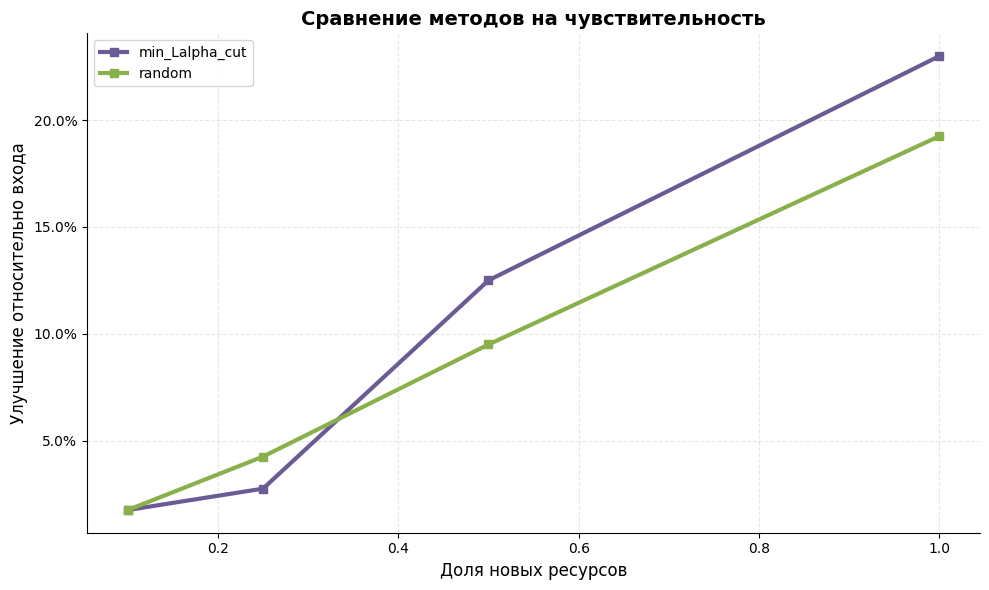

In [10]:
snr_ba_graphs_w_generated_gravity_high_resources_test = get_snr_ba_graphs_w_generated(4, 30, 80.0, 'gravity', [0.7, 0.7, 0.7, 0.7])

# тест
resources_test(snr_ba_graphs_w_generated_gravity_high_resources_test)

Multialpha - слабая загруженность

Чувствительность теста на графе SNR-BA_30_alpha_0.3_#1


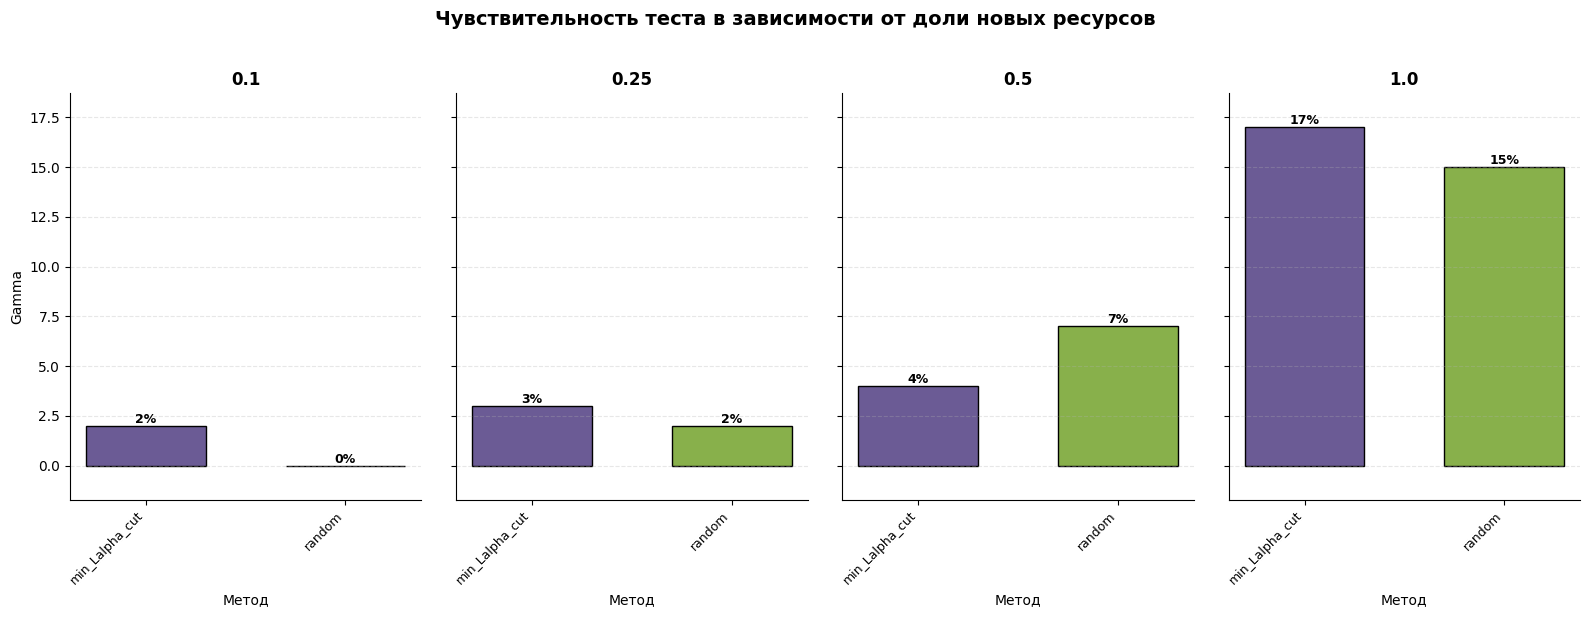

Чувствительность теста на графе SNR-BA_30_alpha_0.3_#2


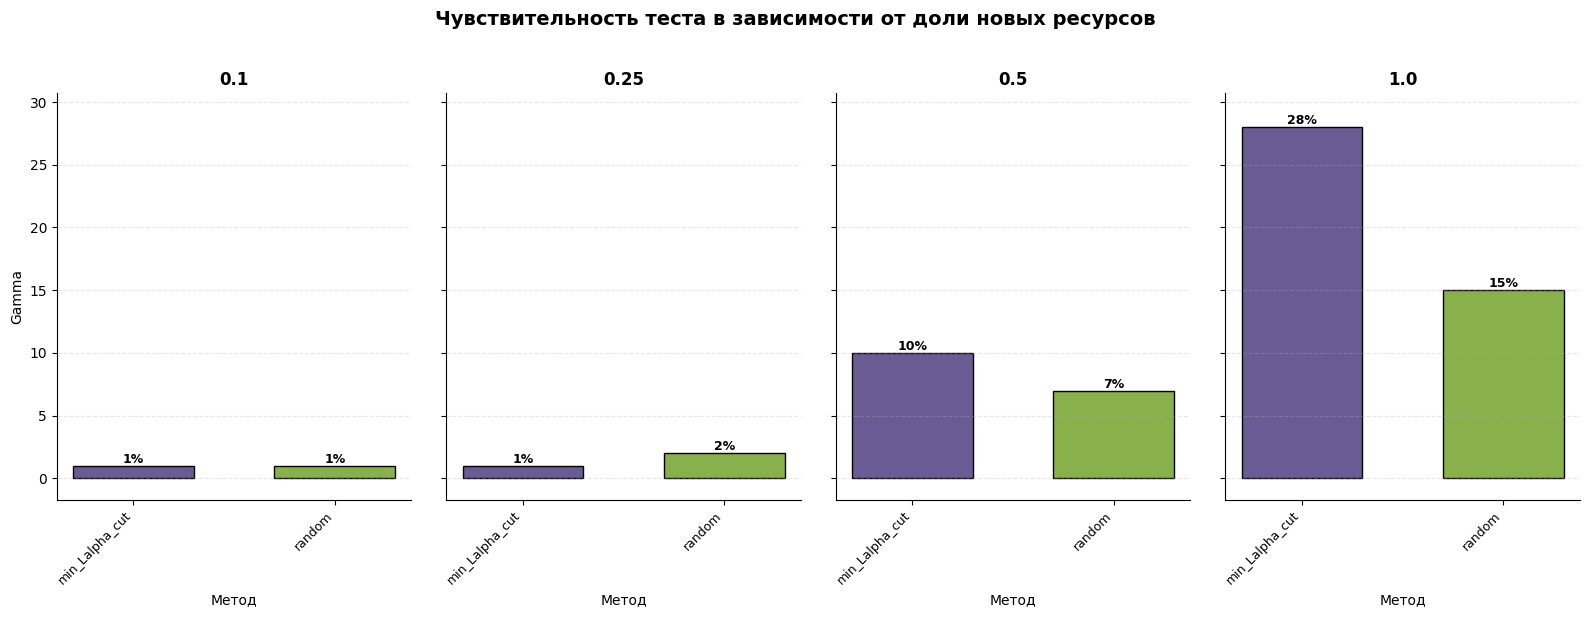

Чувствительность теста на графе SNR-BA_30_alpha_0.3_#3


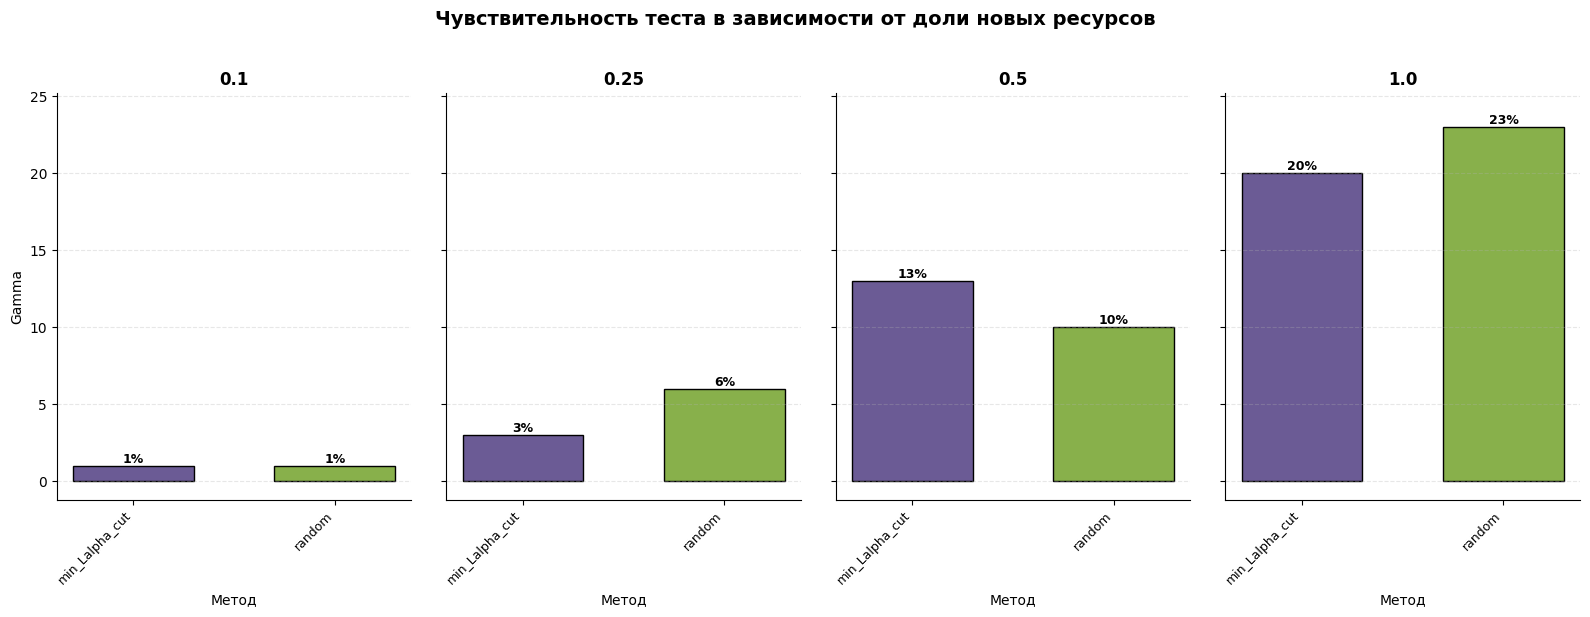

Чувствительность теста на графе SNR-BA_30_alpha_0.3_#4


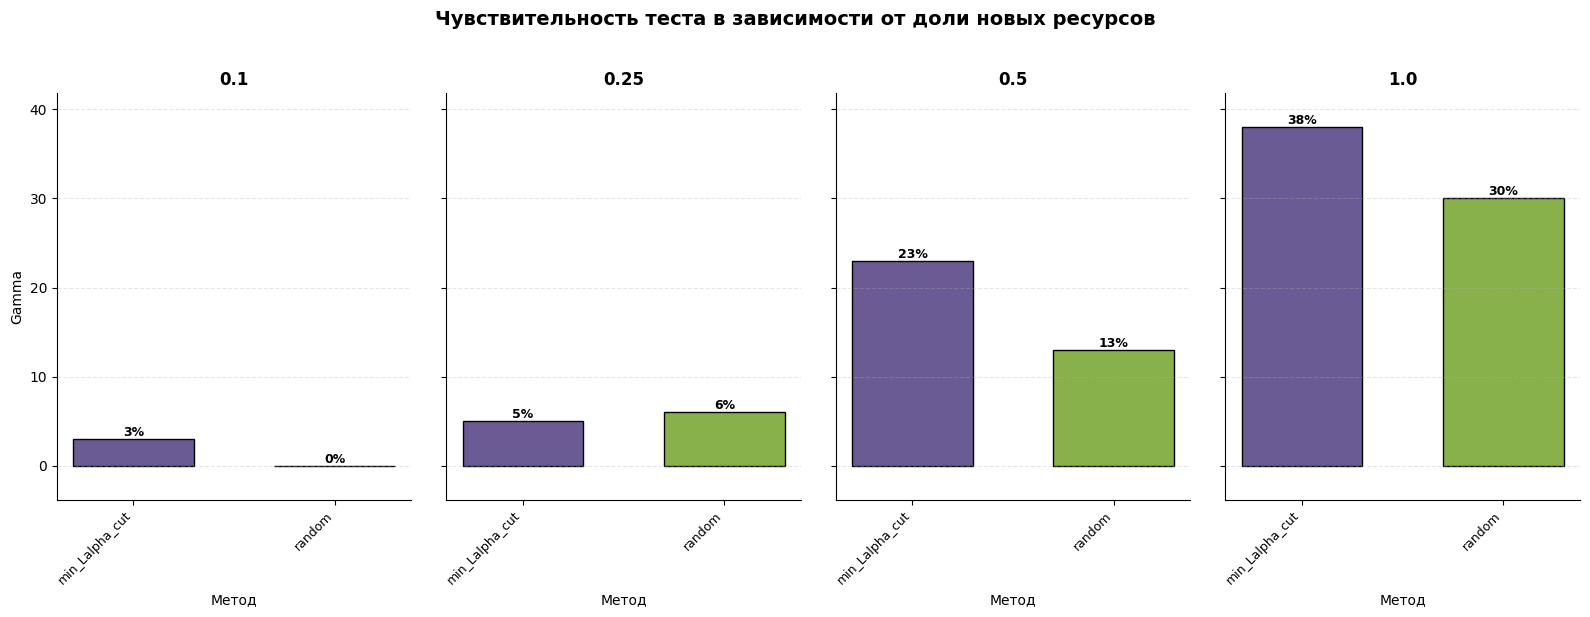

Общая сводка по графам


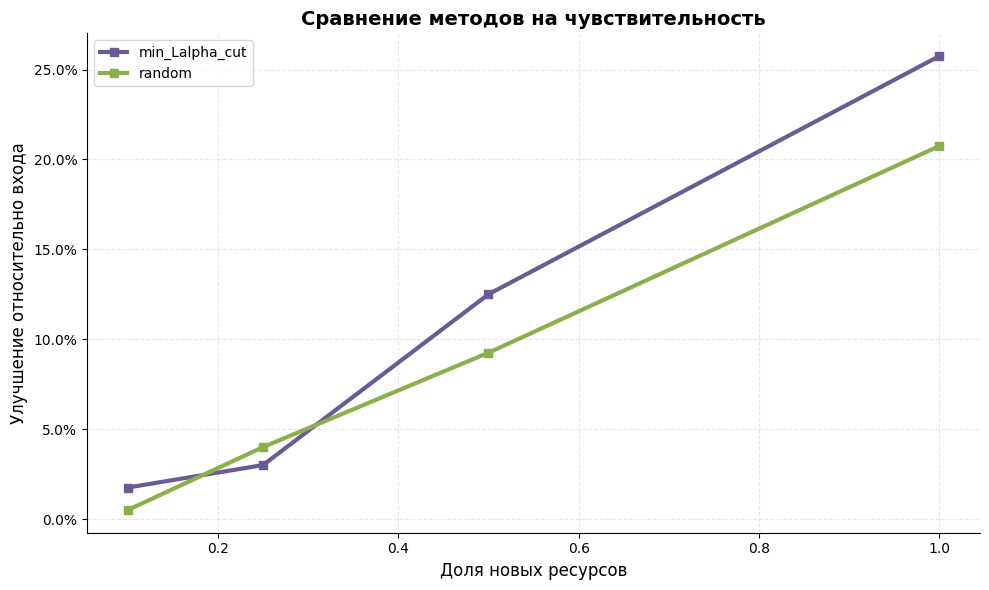

In [11]:
snr_ba_graphs_w_generated_multialpha_low_resources_test = get_snr_ba_graphs_w_generated(4, 30, 80.0, 'alpha', [0.3, 0.3, 0.3, 0.3])

# тест
resources_test(snr_ba_graphs_w_generated_multialpha_low_resources_test)

Multialpha - высокая загруженность

Чувствительность теста на графе SNR-BA_30_alpha_0.45_#1


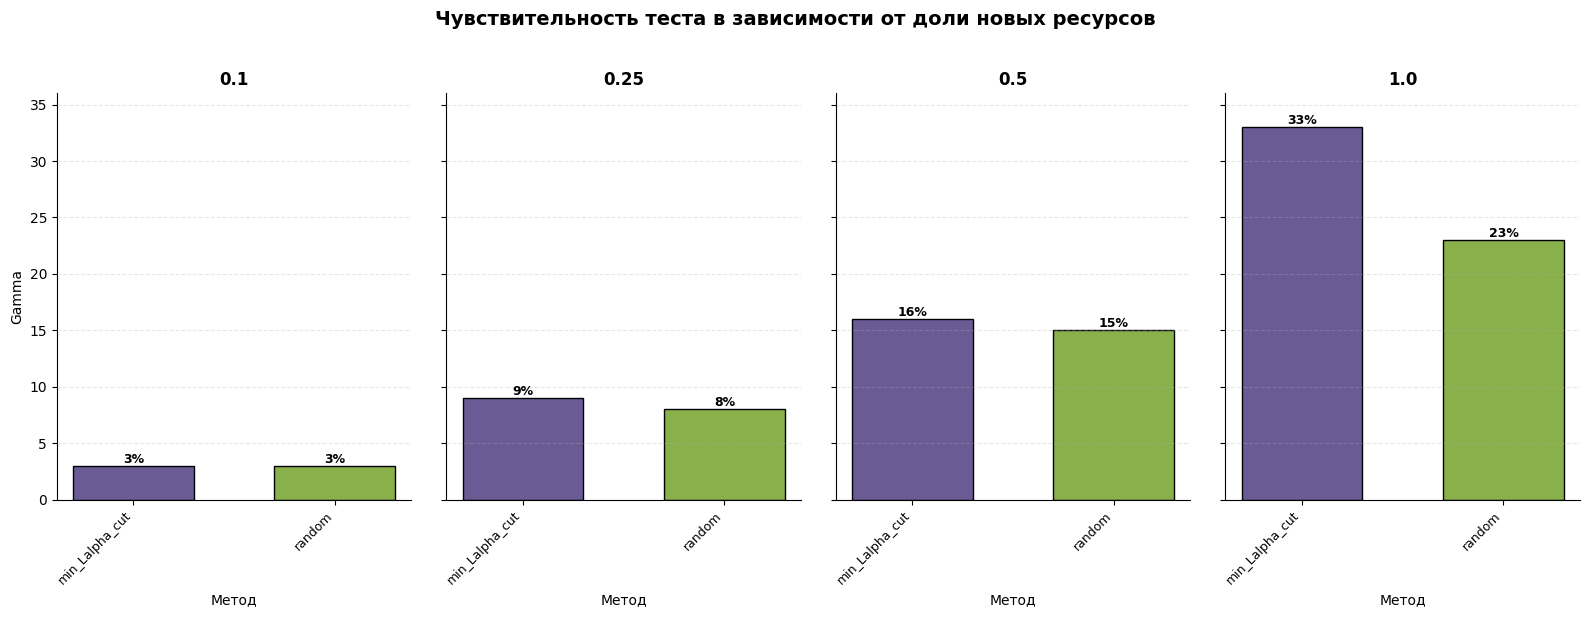

Чувствительность теста на графе SNR-BA_30_alpha_0.45_#2


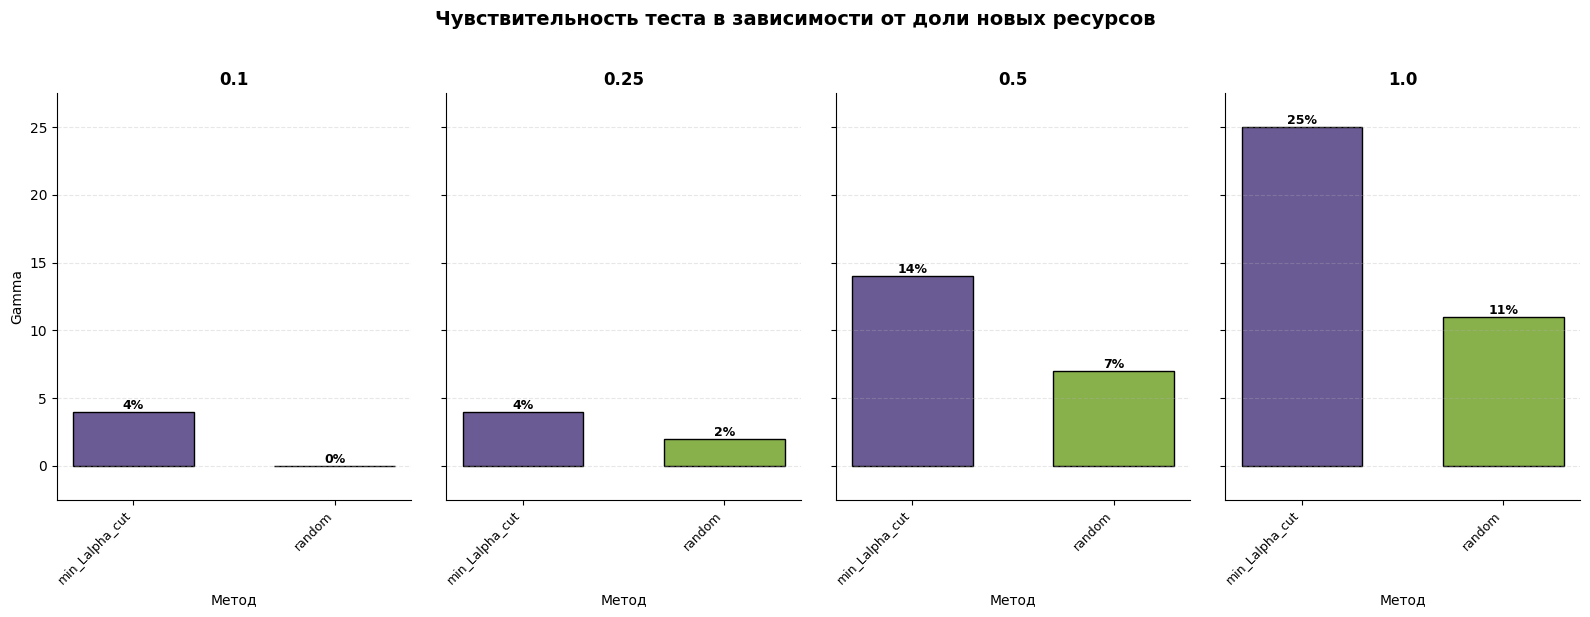

Чувствительность теста на графе SNR-BA_30_alpha_0.45_#3


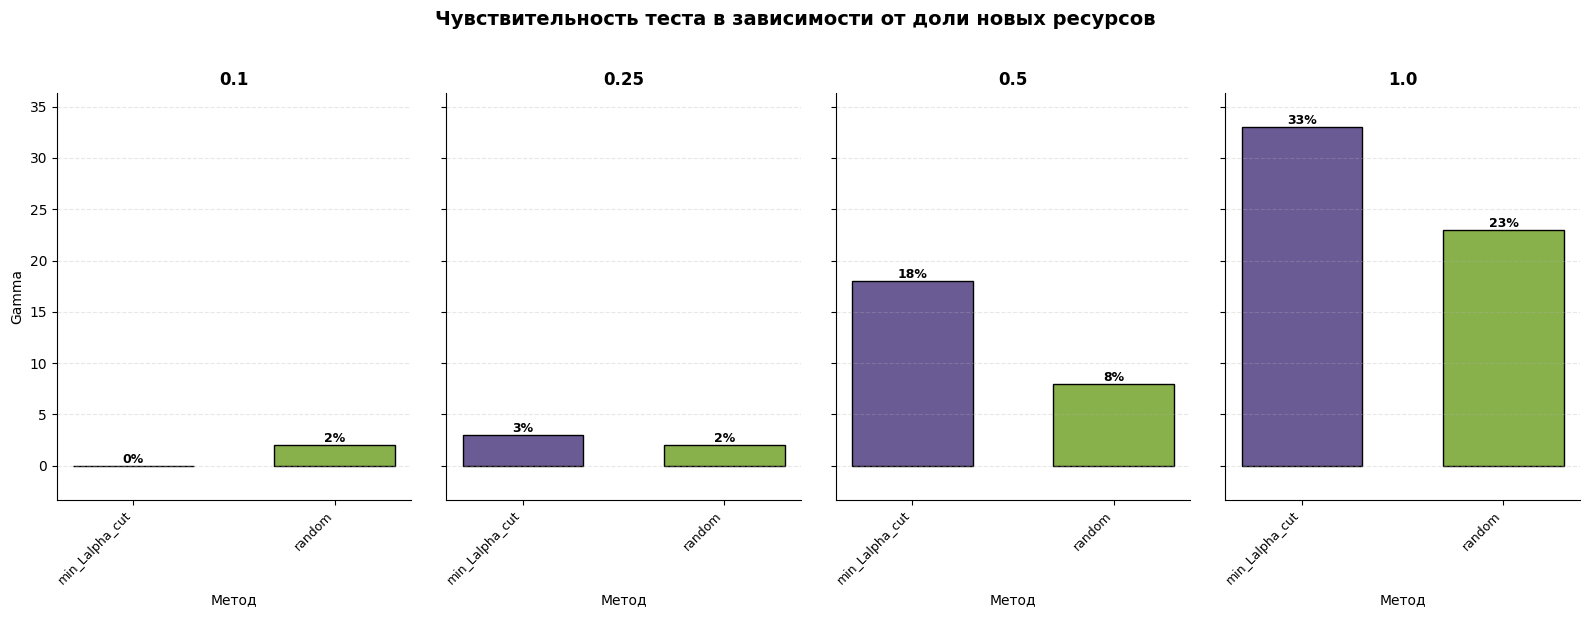

Чувствительность теста на графе SNR-BA_30_alpha_0.45_#4


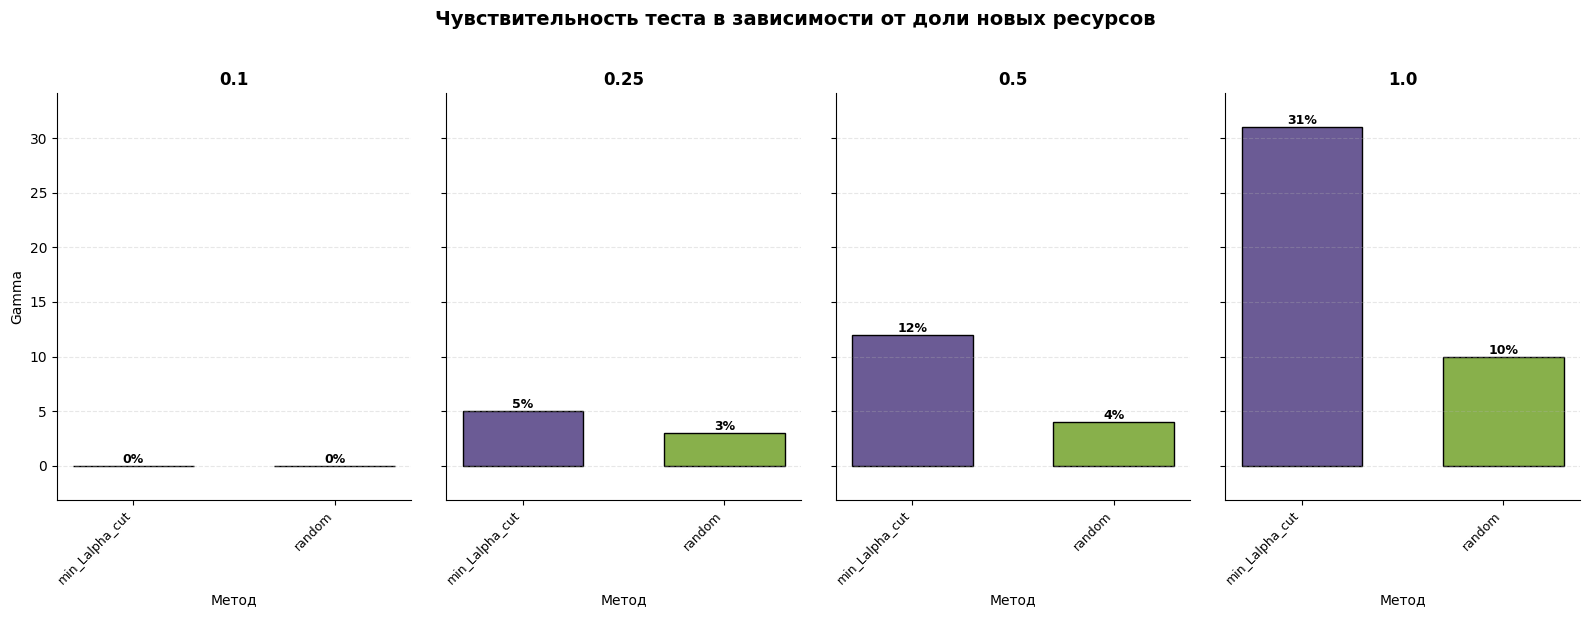

Общая сводка по графам


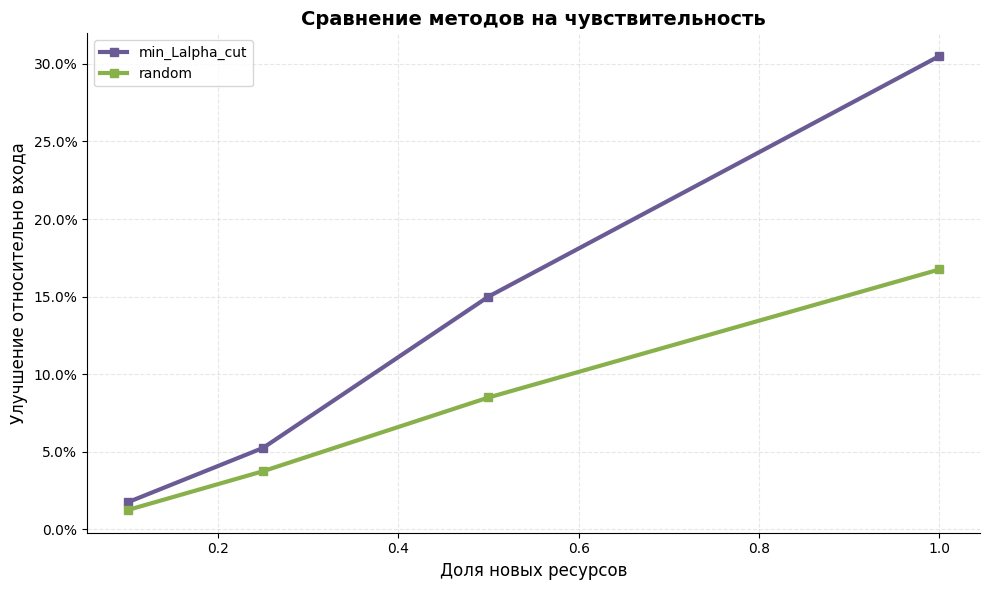

In [12]:
snr_ba_graphs_w_generated_multialpha_high_resources_test = get_snr_ba_graphs_w_generated(4, 30, 80.0, 'alpha', [0.45, 0.45, 0.45, 0.45])

# тест
resources_test(snr_ba_graphs_w_generated_multialpha_high_resources_test)

Проводим эксперимент на расширение

Вспомогательные функции

In [28]:
import networkx as nx
import numpy as np

from graphmcfexps.expand_test import *

def exp_get_sequence(graph, type):
  if type == "min_Lalpha_cut":
    sequence = graph.generate_cut(type="min_Lalpha")
  elif type == "random":
    sequence = [(source, target) for source, target in graph.graph.edges()]
  return sequence

def exp_get_mean(graph, sequence, number_to_add, additional_capacities, tries):
  gammas = []
  for i in range(tries):
    random.shuffle(sequence)
    sequences_to_edges(sequence[:number_to_add], additional_capacities, graph)
    gamma_for_test = graph.solve_mcfp()
    gammas.append(gamma_for_test)
    graph.restore_graph()
  return float(np.mean(gammas))

def main_exp(graphs, mincut_fraction):
  methods = ["initial", "alpha", "min_Lalpha_cut", "random", "betweenness_unweighted"]
  alpha_type = "min_Lalpha"
  tries_for_random = 10
  general_results = {method: [] for method in methods[1:]}

  for name, graph in graphs.items():
    adj_graph, traffic_graph, capacity_value = graph['adj_graph'], graph['traffic_graph'], graph['capacity_value']
    graph_for_exp = GraphMCFexps(adj_graph, traffic_graph)
    graph_results = {}

    number_in_mincut = get_number_in_mincut(graph_for_exp, alpha_type)
    number_to_add = int(number_in_mincut * mincut_fraction)
    additional_capacities = [capacity_value] * number_to_add

    for method in methods:
      if method == "initial":
        gamma_initial = float(graph_for_exp.solve_mcfp())
      elif method in ("min_Lalpha_cut", "random"):
        sequence = exp_get_sequence(graph_for_exp, method)
        gamma = exp_get_mean(graph_for_exp, sequence, number_to_add, additional_capacities, tries_for_random)
      elif method in ("alpha", "betweenness_unweighted"):
        gamma = expand_network_test(additional_capacities, graph_for_exp, method, alpha_type)
      if method != "initial":
        graph_results[method] = int(100 * round(gamma/gamma_initial - 1.0, 2))
        general_results[method].append(int(100 * round(gamma/gamma_initial - 1.0, 2)))

    print(f'Результаты эксперимента на графе {name}')
    exp_visualize_bars(
        data_dict=graph_results,
        title=f'Сравнение методов на графе {name}',
        color_dict=exp_colors
    )

  for method, value in general_results.items():
    processed_value = []
    for x in value:
      if not (math.isnan(x) or math.isinf(x)):
        processed_value.append(x)
    general_results[method] = int(np.mean(processed_value))
  print(f'Общая сводка по графам')
  exp_visualize_bars(
        data_dict=general_results,
        title='Сравнение методов в среднем',
        color_dict=exp_colors
    )

Смотрим на Ху графах с оригинальным трафиком

Результаты эксперимента на графе cola_t10


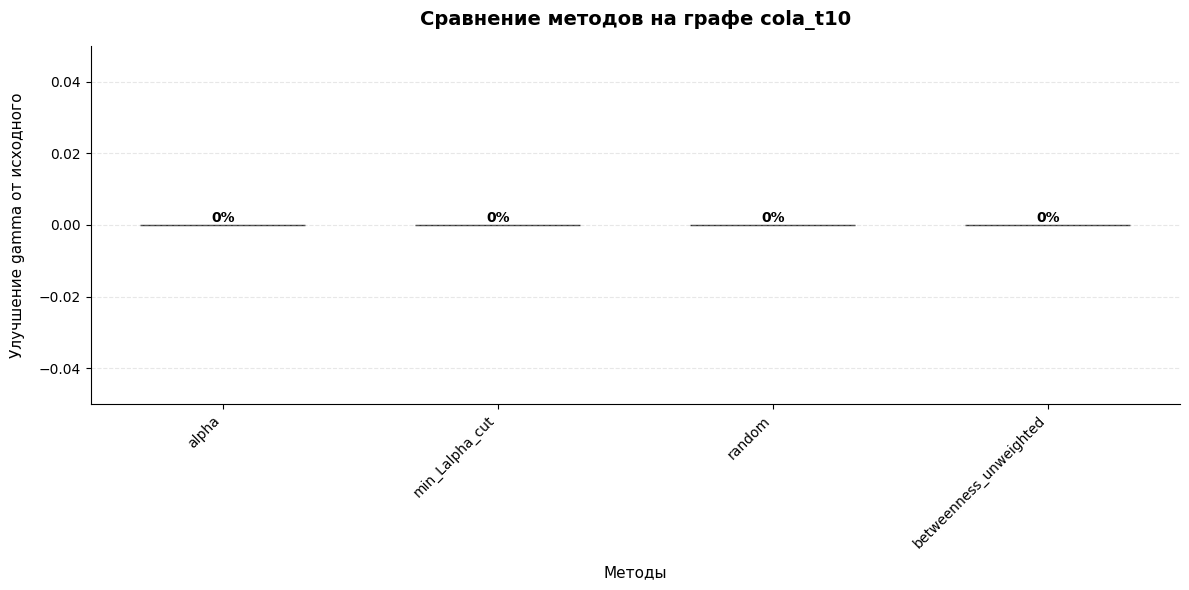

Результаты эксперимента на графе cola_t3


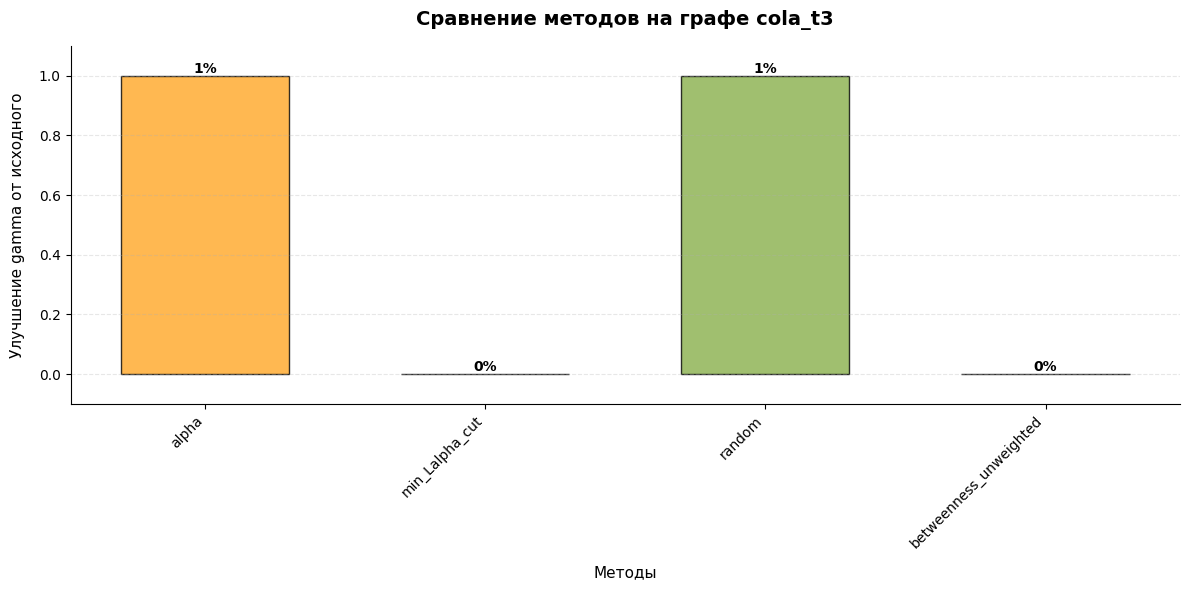

Результаты эксперимента на графе cola_t8


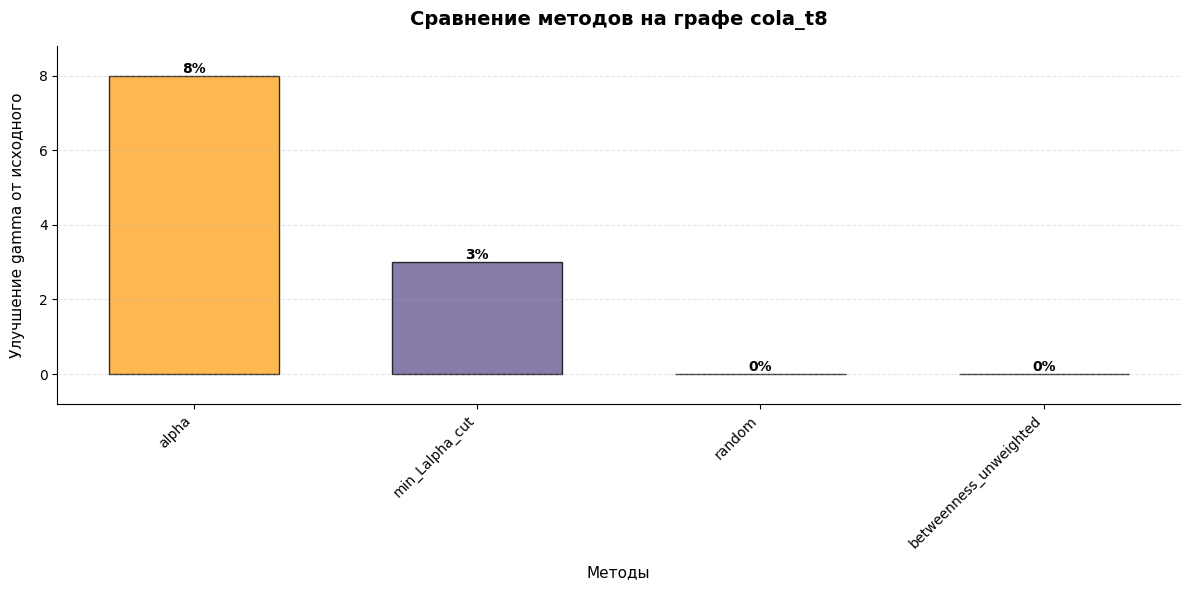

Результаты эксперимента на графе cola_t2


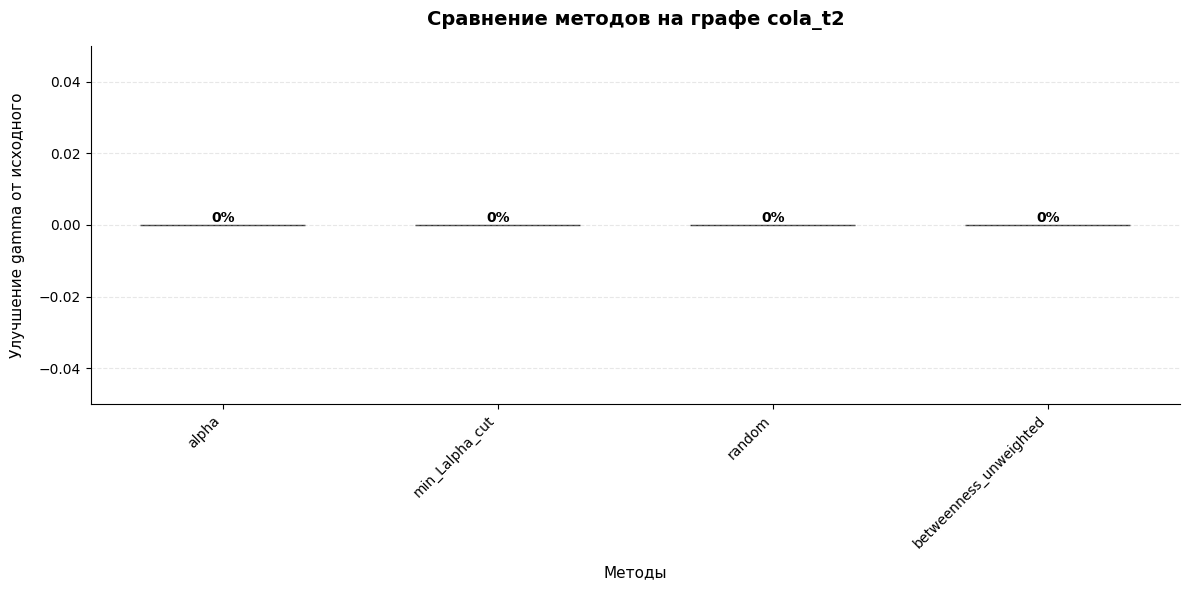

Общая сводка по графам


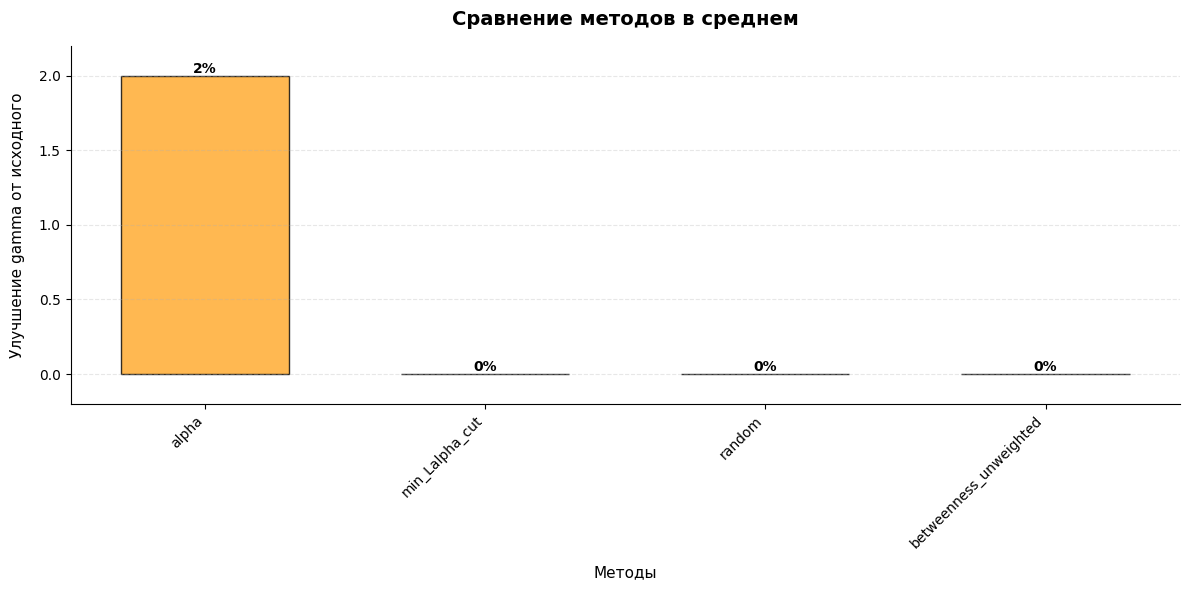

In [29]:
# маленькие кола графы
hu_graphs_names_exp = ['cola_t3', 'cola_t2', 'cola_t8', 'cola_t10']
hu_graphs_exp = get_hu_graphs(path_to_folder, hu_graphs_names_exp, True)

# тест
main_exp(hu_graphs_exp, 0.25)

Смотрим на тех же Ху графах, но с генерацией своего трафика

Gravity - слабая загруженность

Результаты эксперимента на графе cola_t3_gravity_0.3


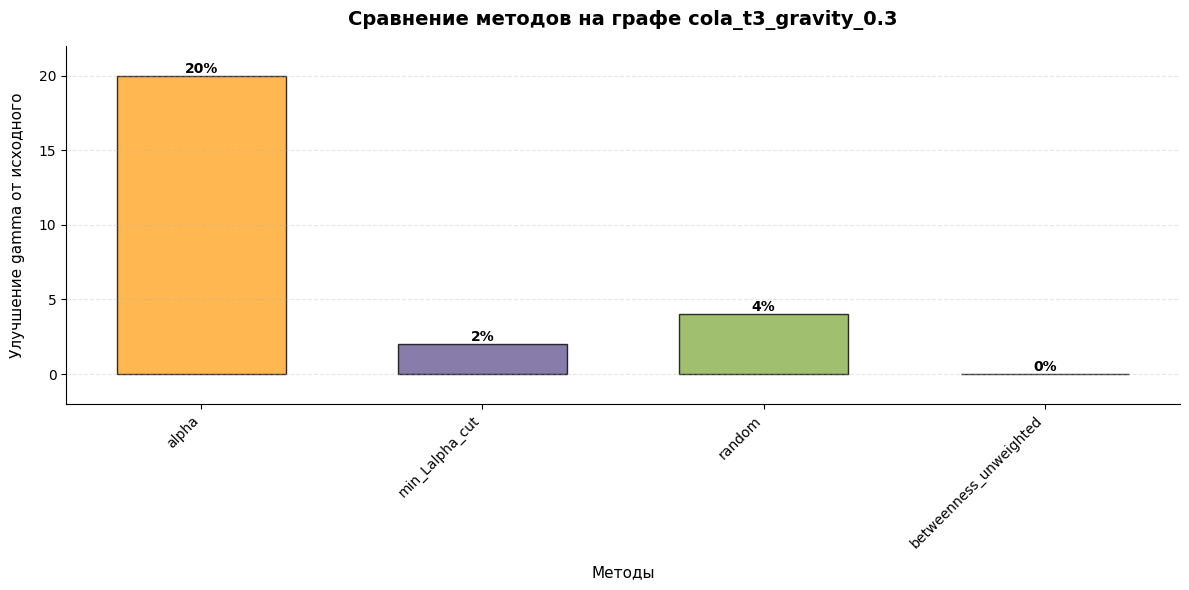

Результаты эксперимента на графе cola_t2_gravity_0.3


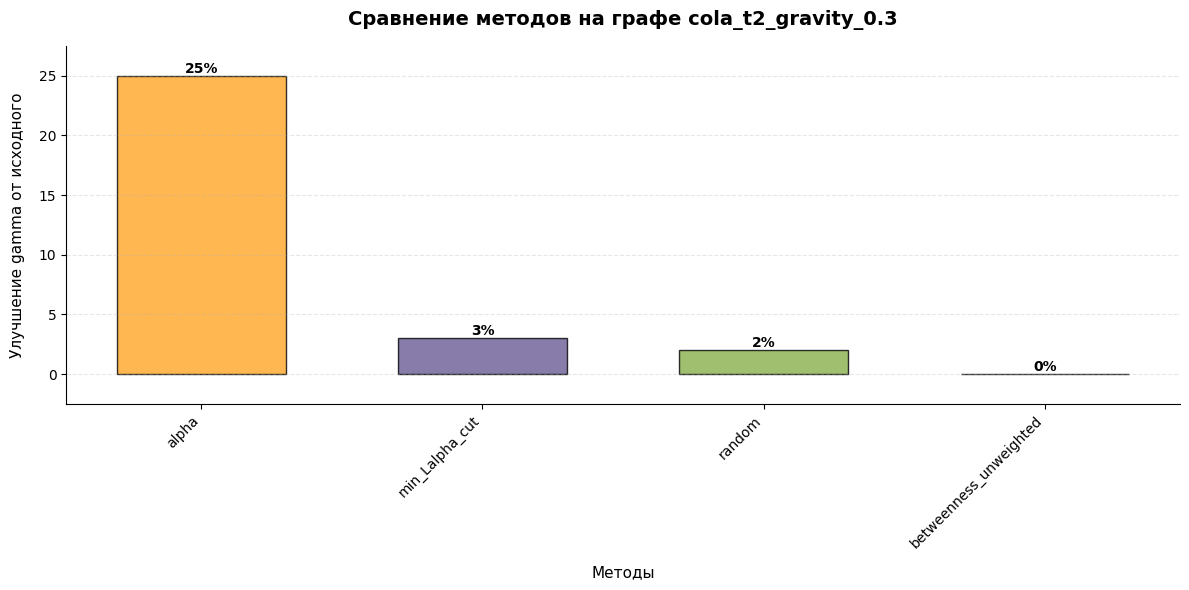

Результаты эксперимента на графе cola_t8_gravity_0.3


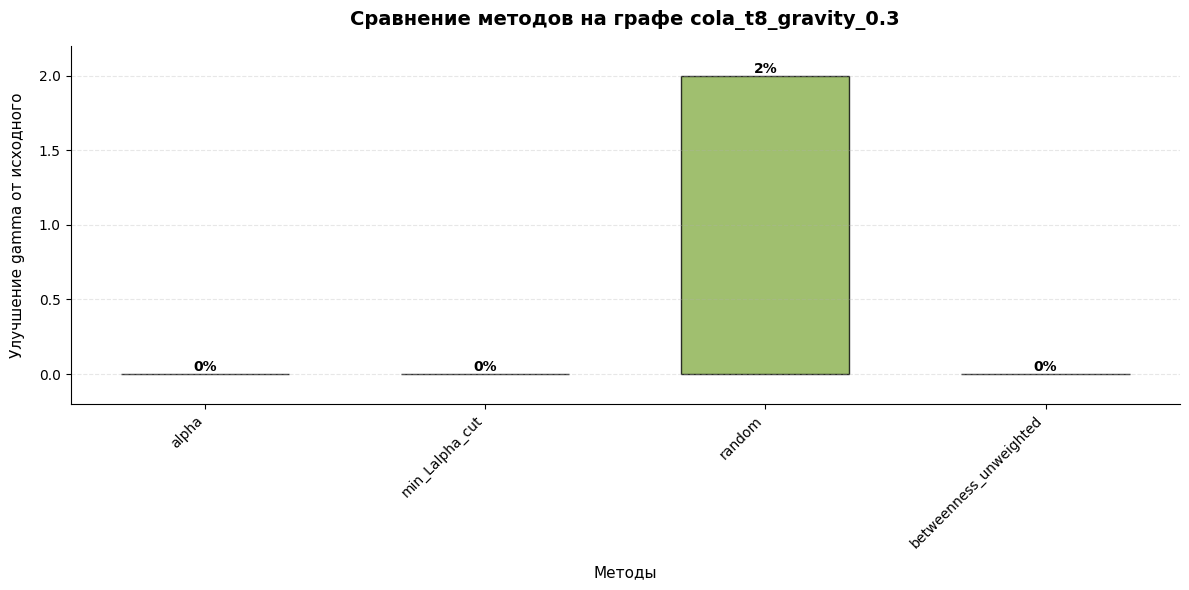

Результаты эксперимента на графе cola_t10_gravity_0.3


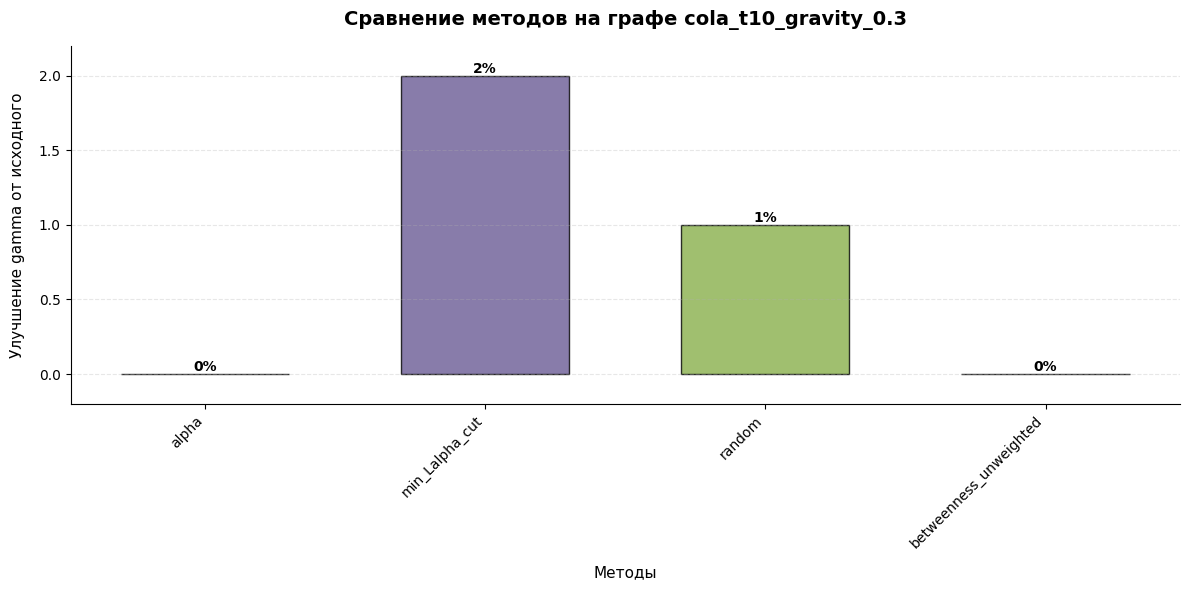

Общая сводка по графам


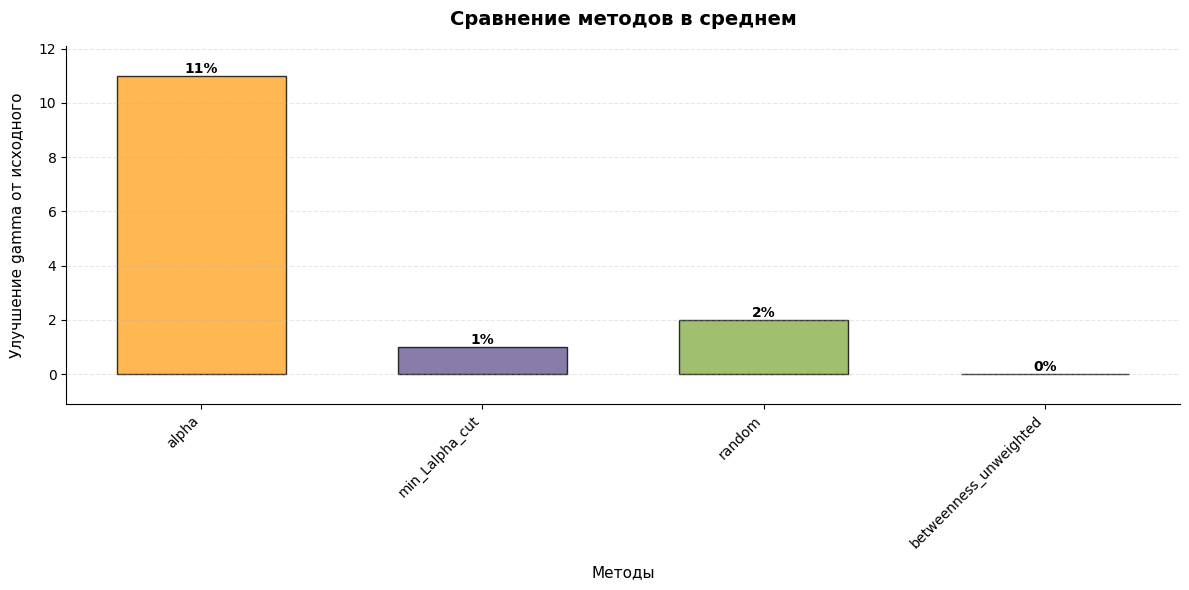

In [31]:
hu_graphs_w_generated_gravity_low_exp = get_hu_graphs_w_generated('gravity', [('cola_t3', 0.3), ('cola_t2', 0.3), ('cola_t8', 0.3), ('cola_t10', 0.3)])

# тест
main_exp(hu_graphs_w_generated_gravity_low_exp, 0.25)

Gravity - высокая загруженность

Результаты эксперимента на графе cola_t3_gravity_0.7


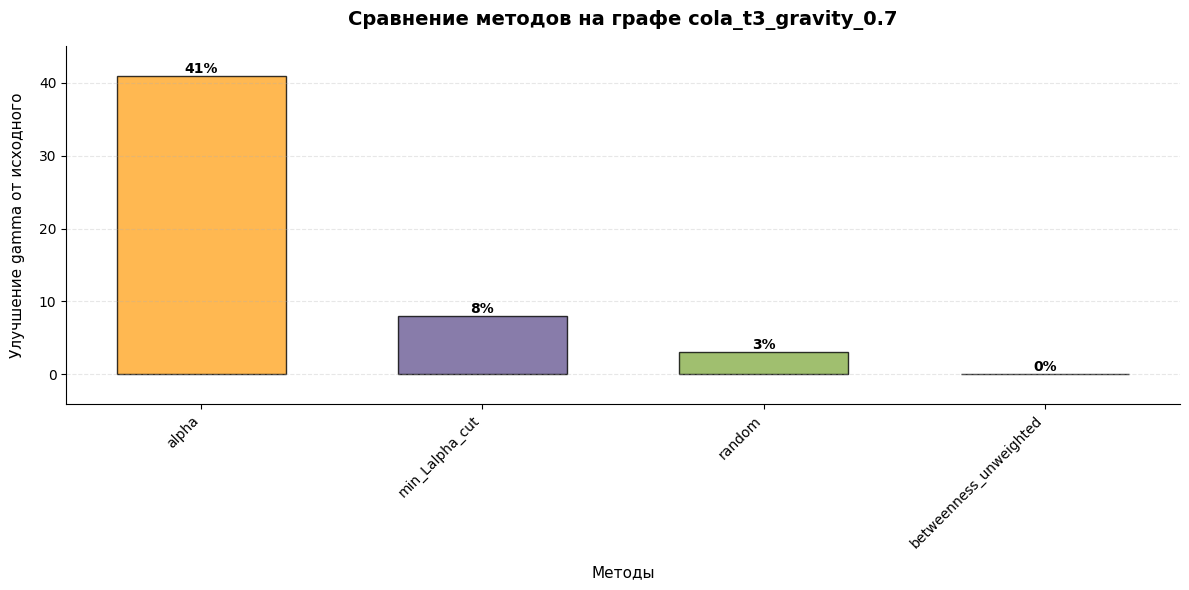

Результаты эксперимента на графе cola_t2_gravity_0.7


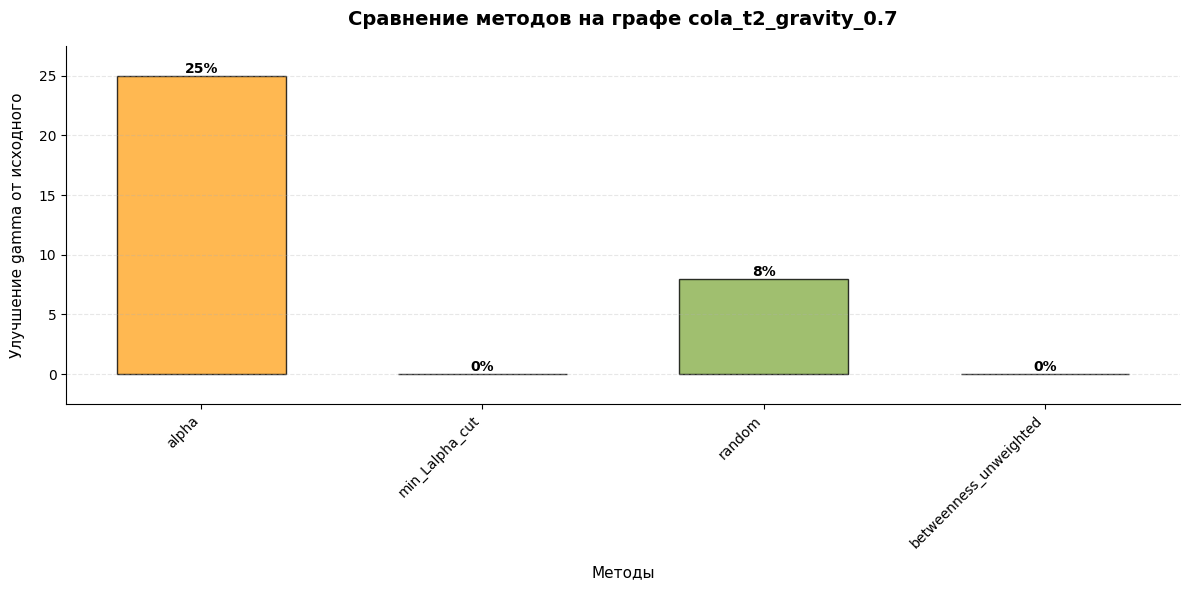

Результаты эксперимента на графе cola_t8_gravity_0.7


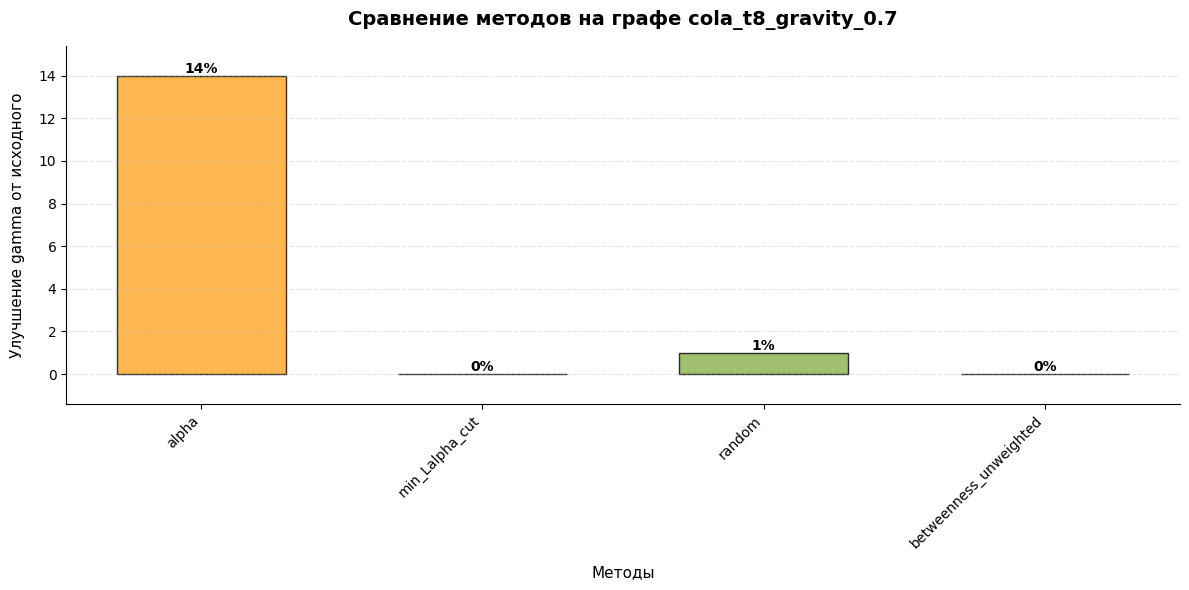

Результаты эксперимента на графе cola_t10_gravity_0.7


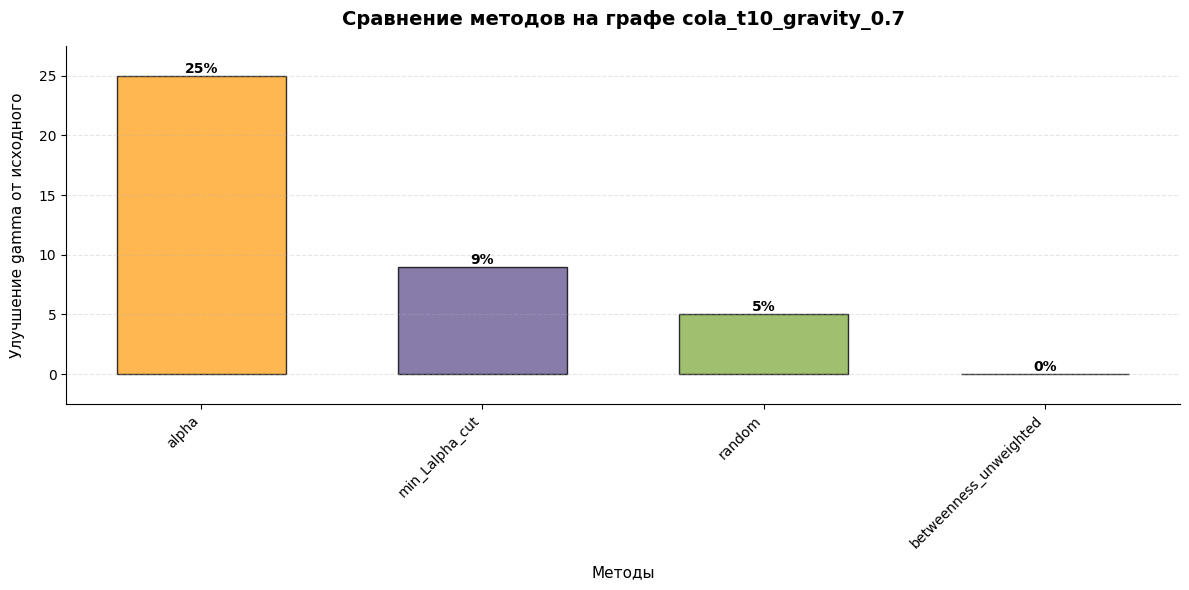

Общая сводка по графам


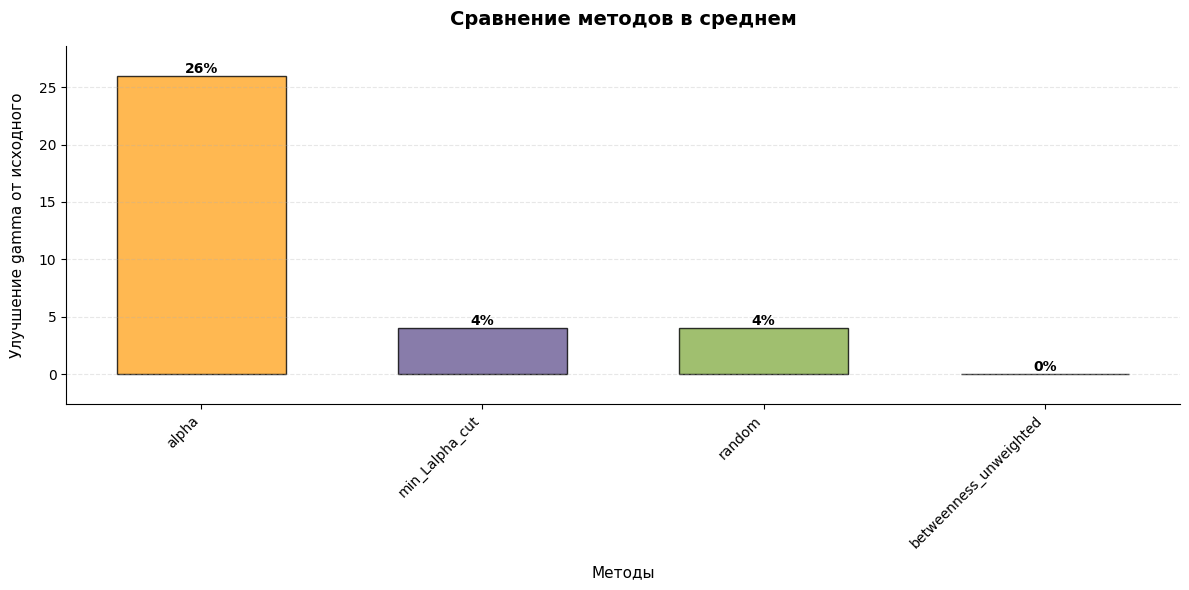

In [32]:
hu_graphs_w_generated_gravity_high_exp = get_hu_graphs_w_generated('gravity', [('cola_t3', 0.7), ('cola_t2', 0.7), ('cola_t8', 0.7), ('cola_t10', 0.7)])

# тест
main_exp(hu_graphs_w_generated_gravity_high_exp, 0.25)

Miltialpha - слабая загруженность

Результаты эксперимента на графе cola_t3_alpha_0.25


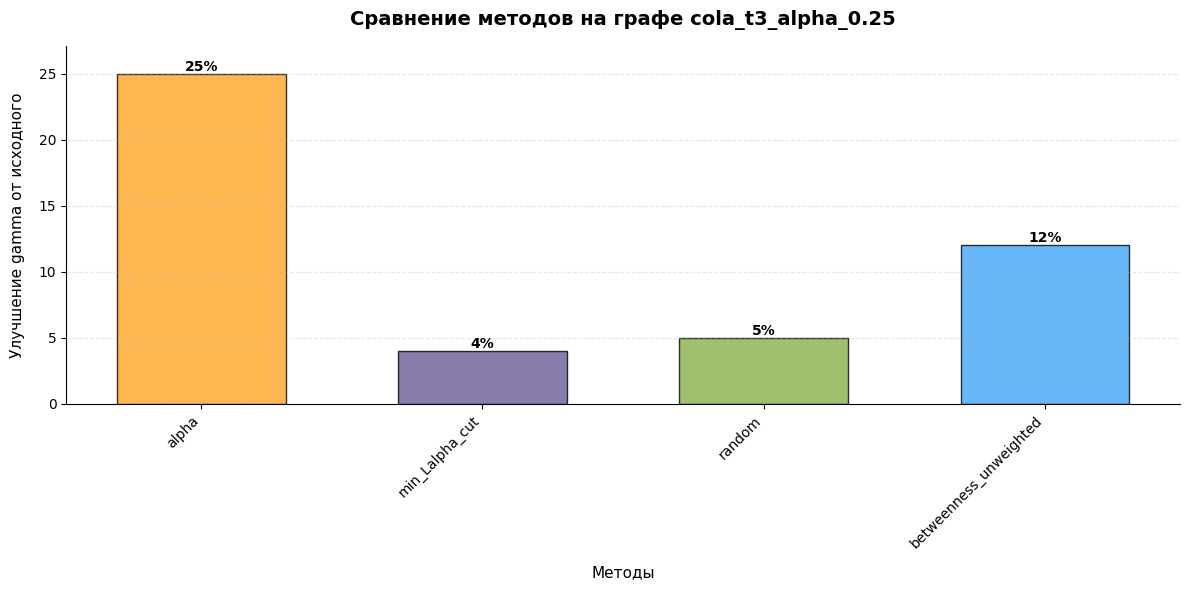

Результаты эксперимента на графе cola_t2_alpha_0.25


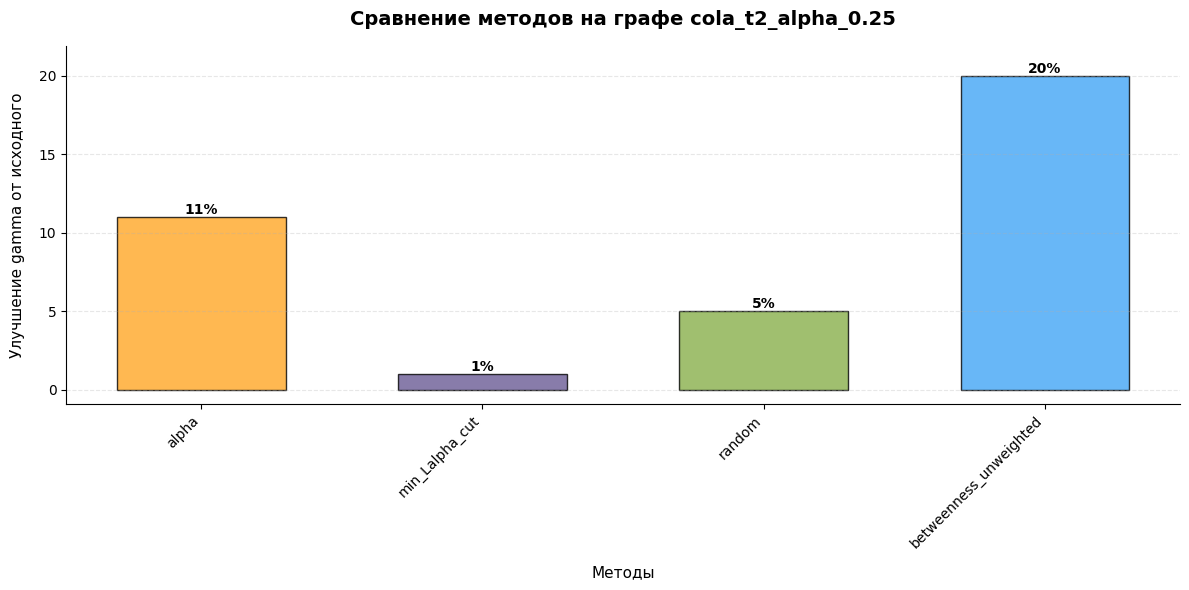

Результаты эксперимента на графе cola_t8_alpha_0.25


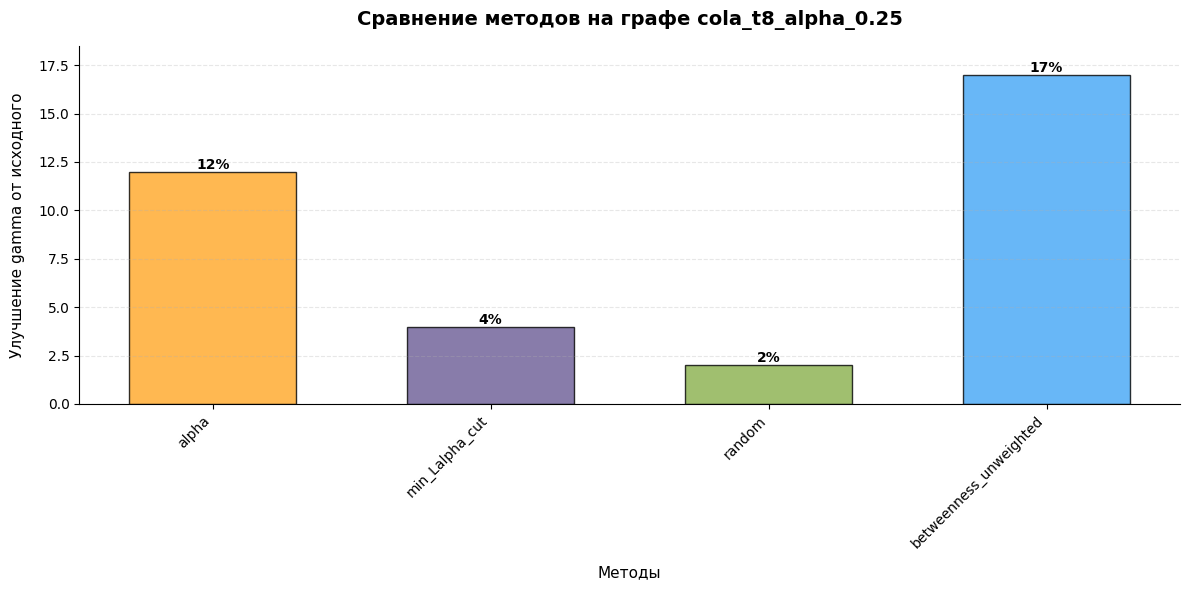

Результаты эксперимента на графе cola_t10_alpha_0.25


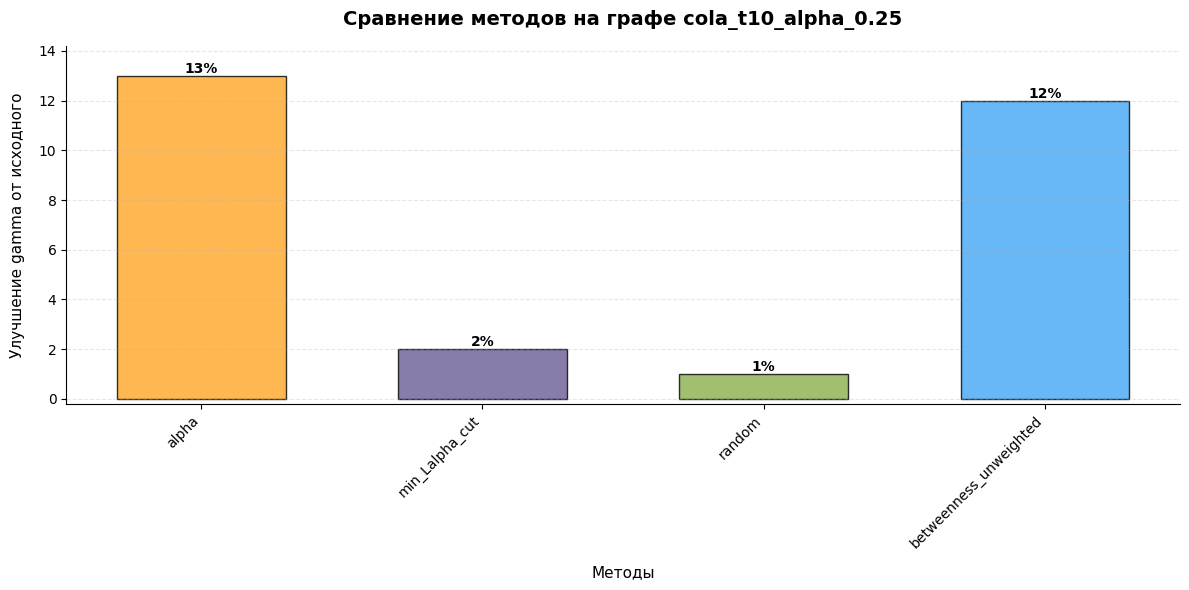

Общая сводка по графам


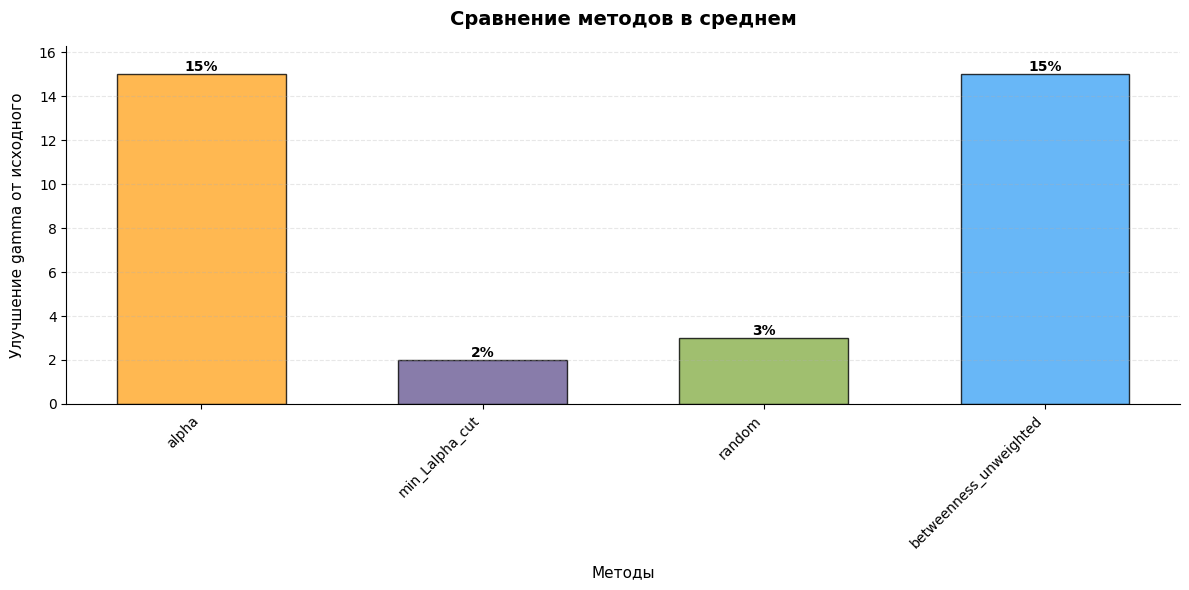

In [33]:
hu_graphs_w_generated_multialpha_low_exp = get_hu_graphs_w_generated('alpha', [('cola_t3', 0.25), ('cola_t2', 0.25), ('cola_t8', 0.25), ('cola_t10', 0.25)])

# тест
main_exp(hu_graphs_w_generated_multialpha_low_exp, 0.25)

Multialpha - высокая загруженность

Результаты эксперимента на графе cola_t3_alpha_0.45


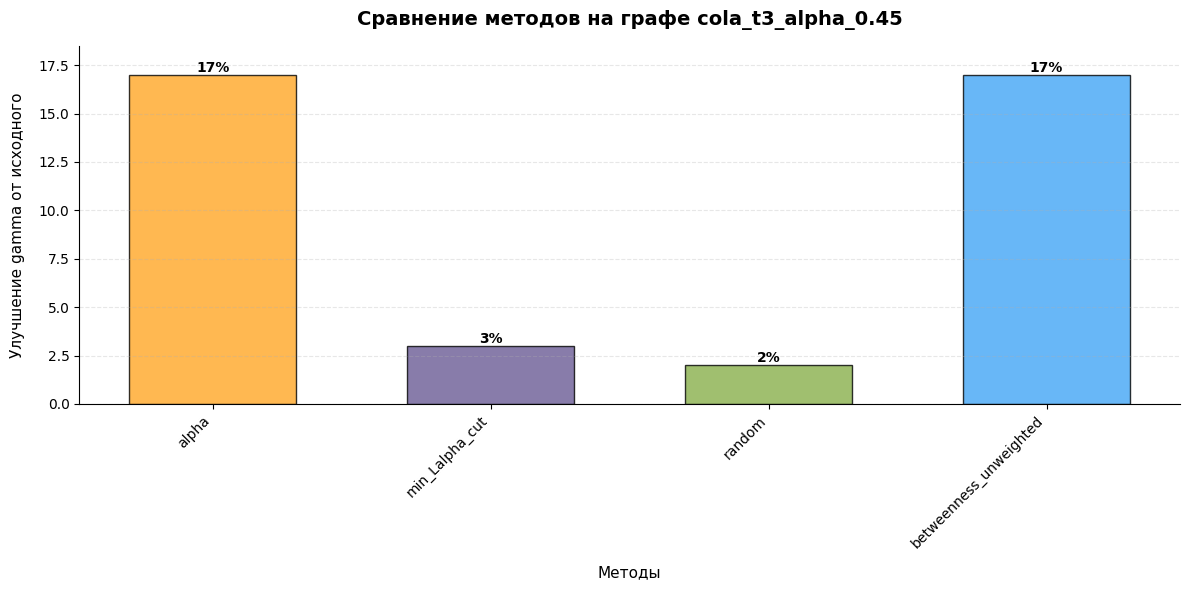

Результаты эксперимента на графе cola_t2_alpha_0.45


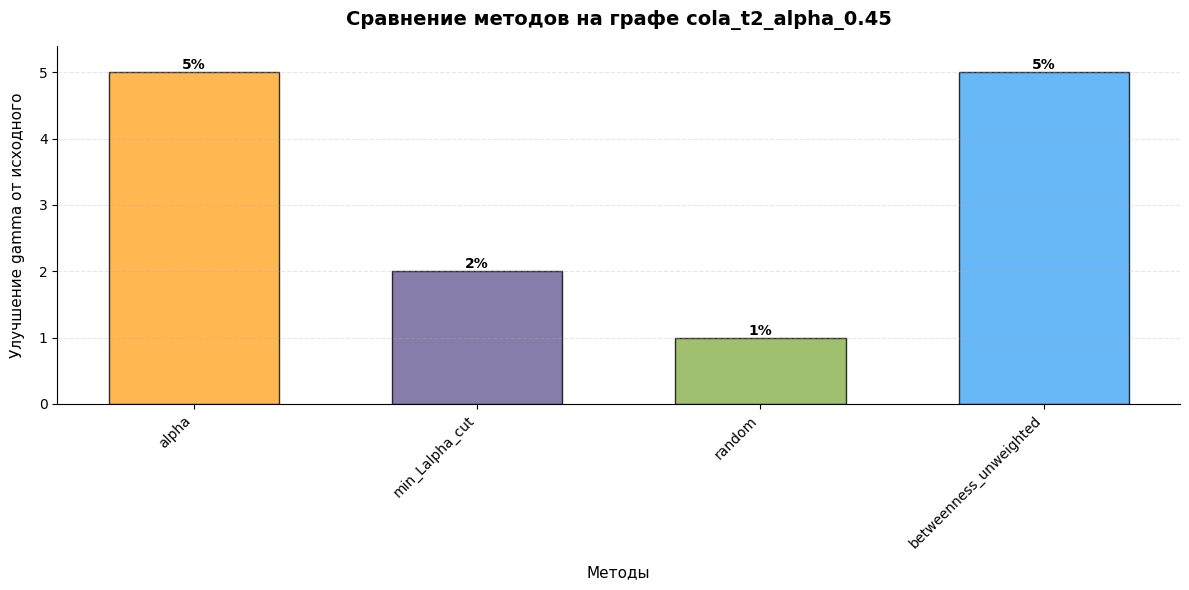

Результаты эксперимента на графе cola_t8_alpha_0.45


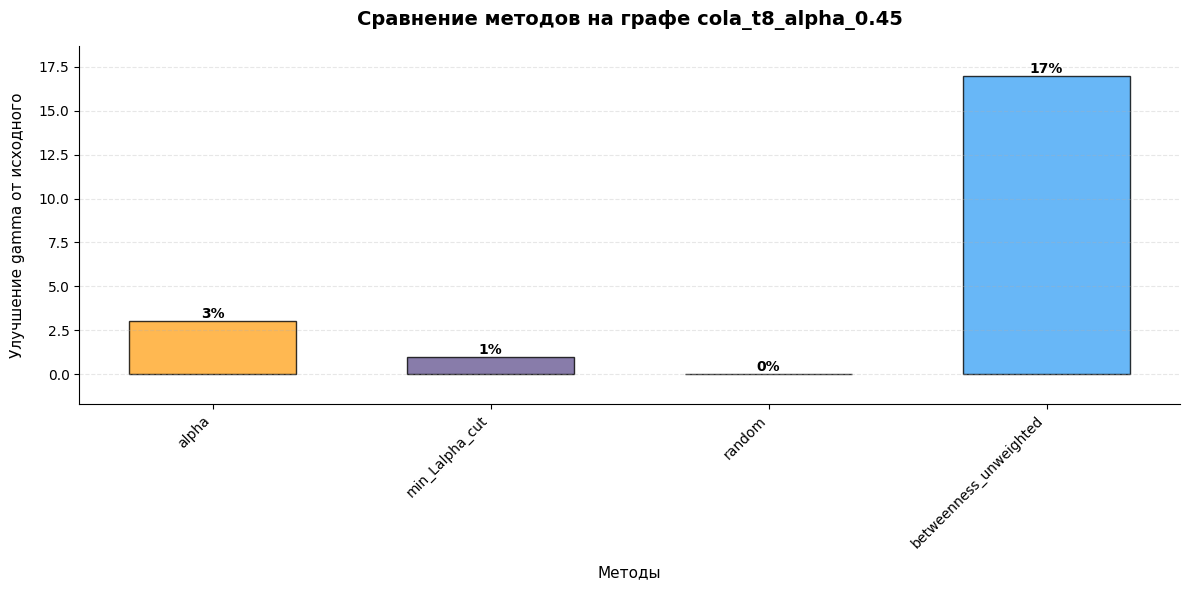

Результаты эксперимента на графе cola_t10_alpha_0.45


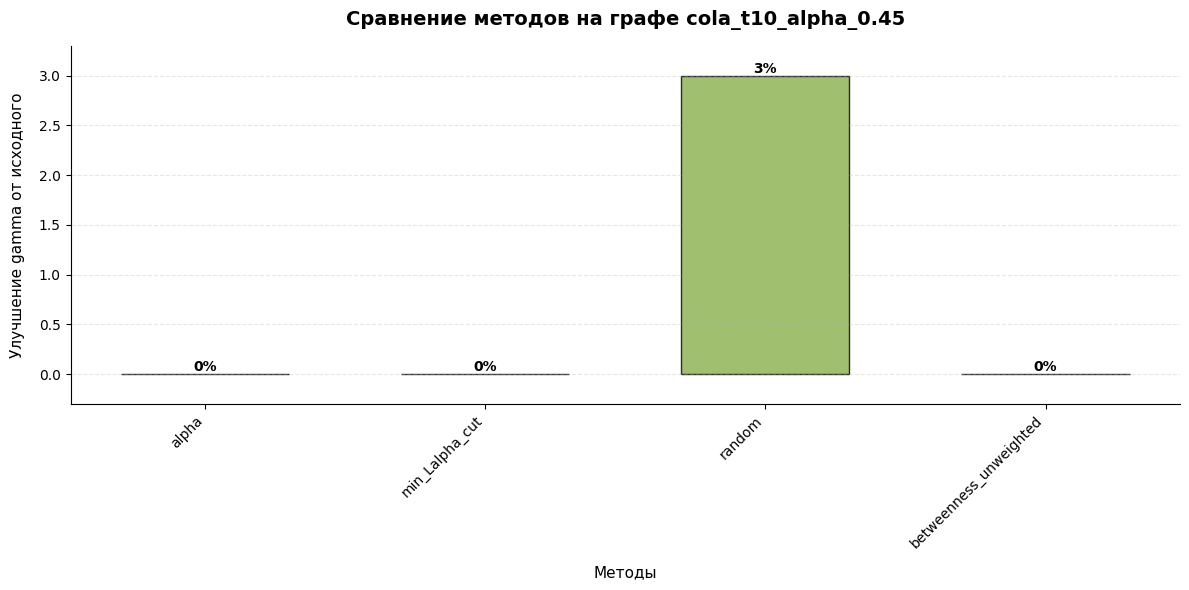

Общая сводка по графам


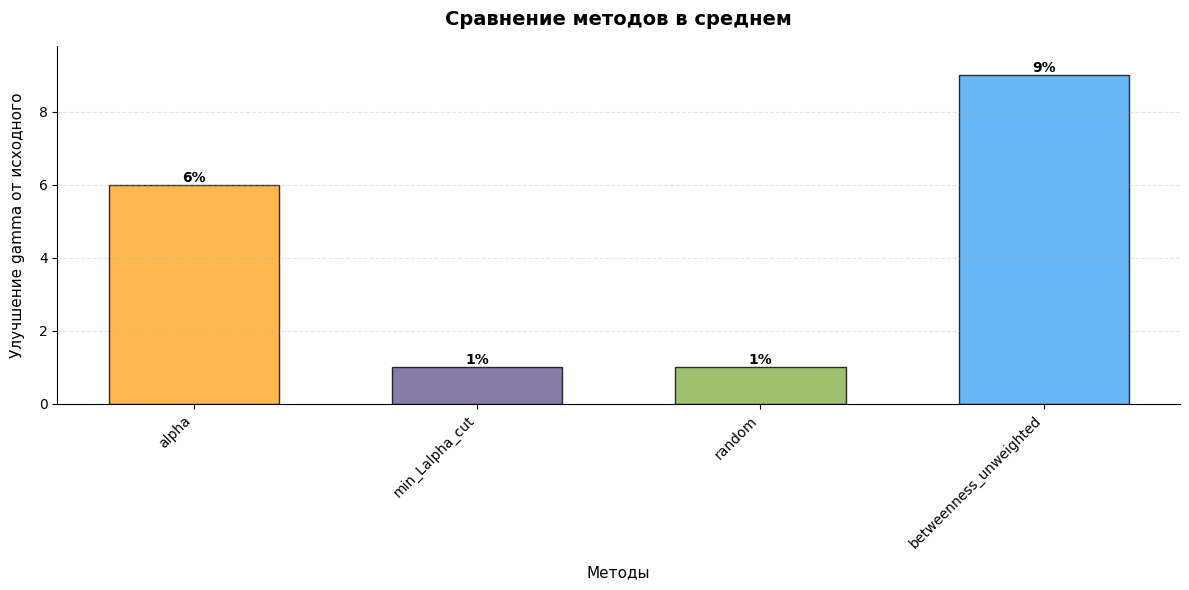

In [34]:
hu_graphs_w_generated_multialpha_high_exp = get_hu_graphs_w_generated('alpha', [('cola_t3', 0.45), ('cola_t2', 0.45), ('cola_t8', 0.45), ('cola_t10', 0.45)])

# тест
main_exp(hu_graphs_w_generated_multialpha_high_exp, 0.25)

Смотрим на SNR BA

Gravity - слабая загруженность

In [ ]:
snr_ba_graphs_w_generated_gravity_low_exp = get_snr_ba_graphs_w_generated(4, 100, 80.0, 'gravity', [0.3, 0.3, 0.3, 0.3])

# тест
main_exp(snr_ba_graphs_w_generated_gravity_low_exp, 0.25)

Gravity - высокая загруженность

In [ ]:
snr_ba_graphs_w_generated_gravity_high_exp = get_snr_ba_graphs_w_generated(4, 100, 80.0, 'gravity', [0.7, 0.7, 0.7, 0.7])

# тест
main_exp(snr_ba_graphs_w_generated_gravity_high_exp, 0.25)

Multialpha - слабая загруженность

In [ ]:
snr_ba_graphs_w_generated_multialpha_low_exp = get_snr_ba_graphs_w_generated(4, 100, 80.0, 'alpha', [0.25, 0.25, 0.25, 0.25])

# тест
main_exp(snr_ba_graphs_w_generated_multialpha_low_exp, 0.25)

Multialpha - высокая загруженность

In [ ]:
snr_ba_graphs_w_generated_multialpha_high_exp = get_snr_ba_graphs_w_generated(4, 100, 80.0, 'alpha', [0.45, 0.45, 0.45, 0.45])

# тест
main_exp(snr_ba_graphs_w_generated_multialpha_high_exp, 0.25)